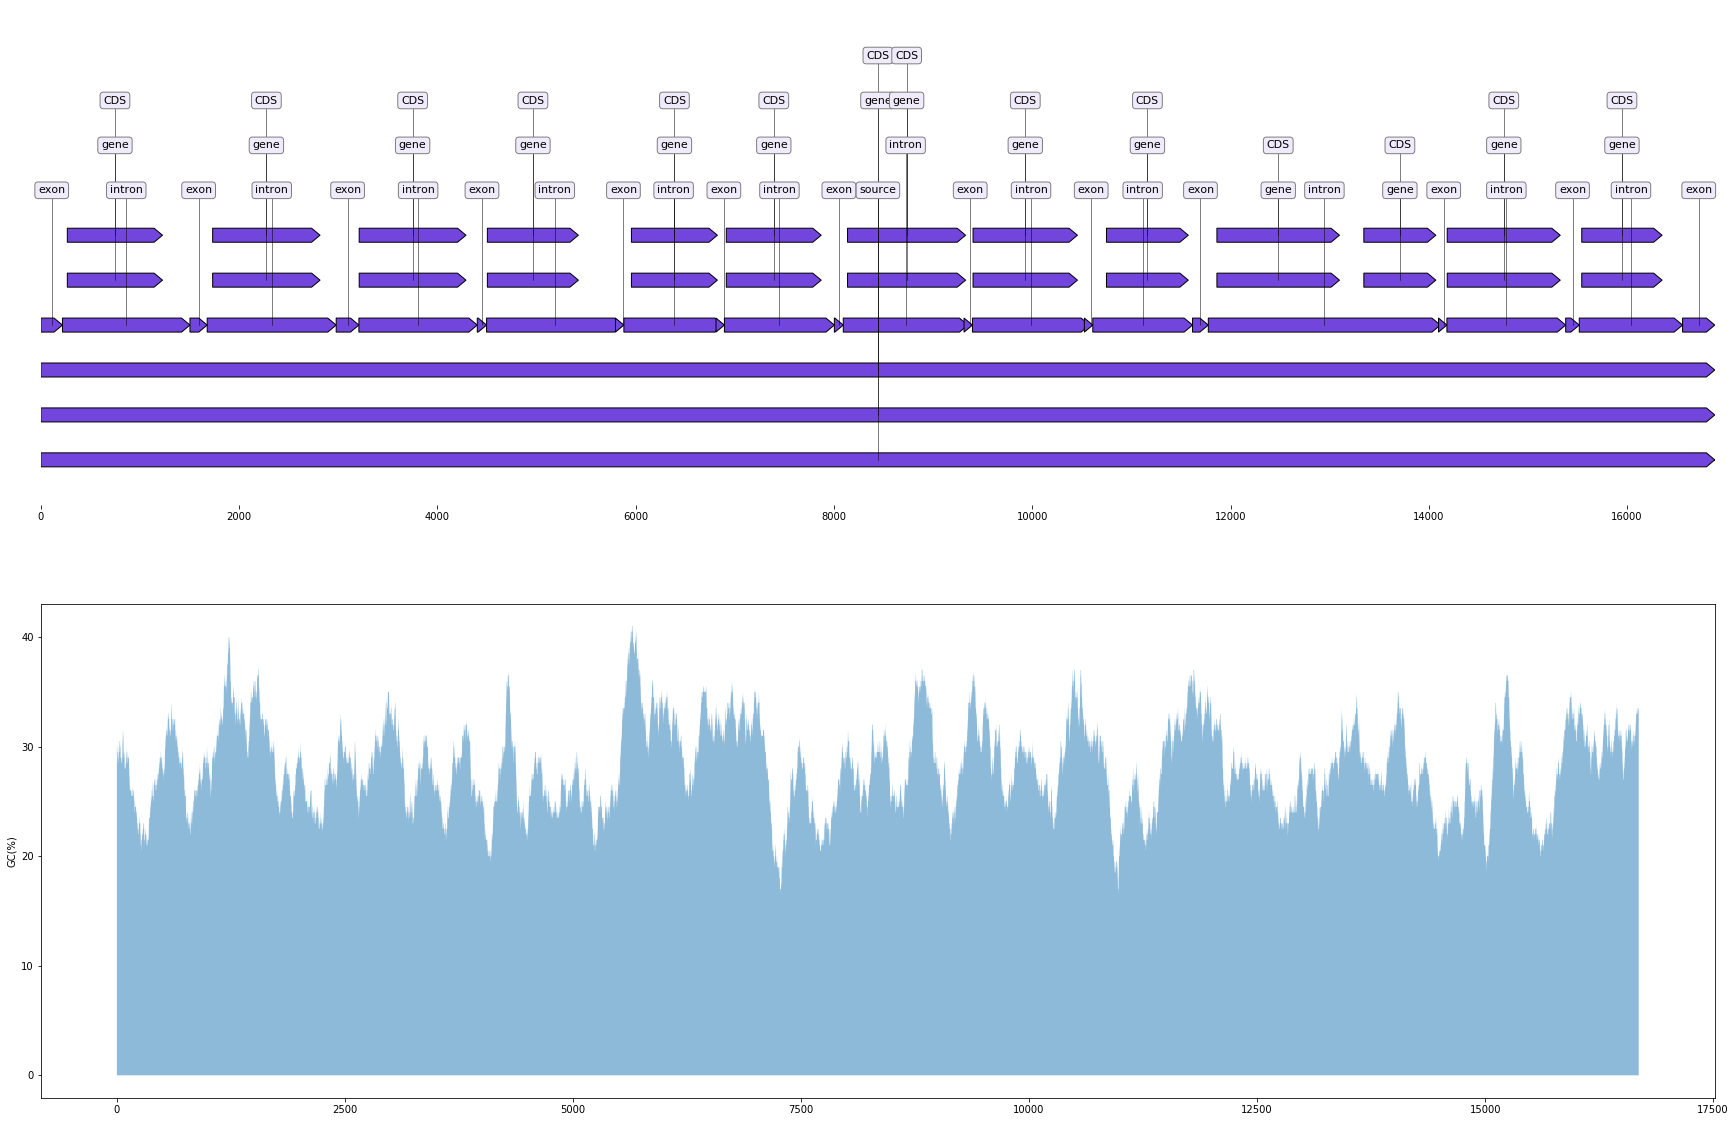

In [3]:
# only for short seqs
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20), sharex=False)

# Parse the genbank file, plot annotations
record = SeqIO.read("/home/pavel/Desktop/ORF_SMTB/ORF_finder/sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
#ax, levels = graphic_record.plot()
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=200, ax=ax2)

# Resize the figure
fig.savefig("with_plot.png")
#Image(filename='with_plot.png') 

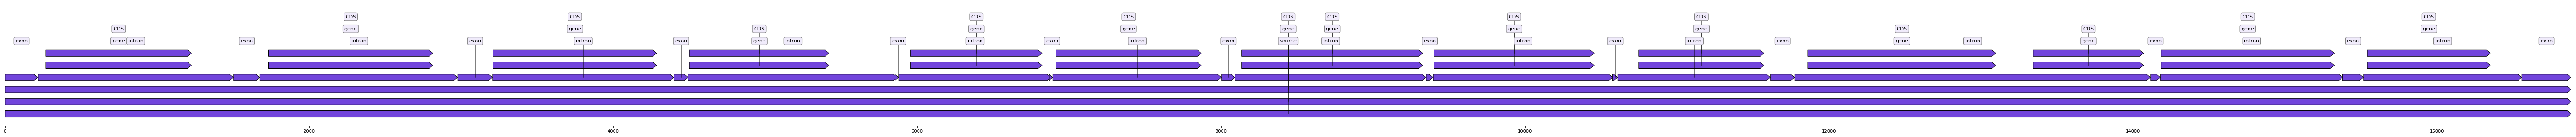

In [2]:
from dna_features_viewer import BiopythonTranslator
graphic_record = BiopythonTranslator().translate_record("/home/pavel/Desktop/ORF_SMTB/ORF_finder/sequence.gb")

ax, _ = graphic_record.plot(figure_width=100)

Start script
Type the name of fasta file /home/pavel/Desktop/ORF_SMTB/Mitochondrial complete sequences/Amphioctopus fangsiao mitochondrion sequence.fasta
Type the minimal protein length 10
Do you want to have a codon log file? [y]/[n] y
Do you want to see a prot histogram visualization? [y]/[n] y
Type the bin size for protein histogram 10
Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2

Basic information about the sequence...

Nucleotide composition:
A 101382
T 83895
G 17544
C 36902

Codone composition:
UUU 5701
UUC 988
UUA 5727
UUG 1963
UCU 1091
UCC 321
UCA 913
UCG 208
UAU 4492
UAC 863
UAA 0
UAG 0
UGU 1490
UGC 292
UGA 0
UGG 633
CUU 711
CUC 366
CUA 766
CUG 327
CCU 678
CCC 264
CCA 283
CCG 89
CAU 953
CAC 296
CAA 1196
CAG 236
CGU 200
CGC 65
CGA 214
CGG 186
AUU 4853
AUC 1064
AUA 5249
AUG 4270
ACU 891
ACC 305
ACA 601
ACG 165
AAU 3414
AAC 812
AAA 3051
AAG 1247
AGU 1522
AGC 343
AGA 1035
AGG 1031
GUU 1914
GUC 316
GUA 1314
GUG 521
GCU 605
GCC 45
GCA 295
GCG 104
GAU 122

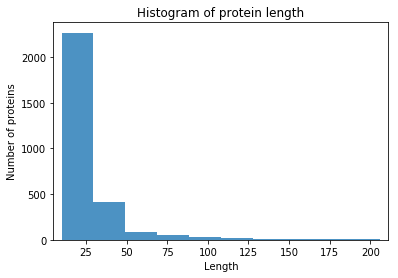


Done


In [10]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

import sys # импортируем библиотеки
import numpy
import math
import datetime



print("Start script") # задаем стартовые параметры
try:
    file = str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")
    
minimal_len_prot = int(input("Type the minimal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
codone_log_button = str(input("Do you want to have a codon log file? [y]/[n] "))
hist = str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = int(input("Type the bin size for protein histogram "))

code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}


log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


@log_wrapper("protein_translator log")
def protein_translator(line_in, codone_log_button = "y", code_calc = code_calc):
    code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}

    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    line_out = []
    amino_info_collector = {}

    if len(line_in) % 3 == 0:
        for i in range(0, len(line_in), 3):

            codon = line_in[i:(i + 3)]
            if codon in code_calc.keys(): # считаем кодоны
                code_calc[codon] = int(code_calc[codon]) + 1

                
            if codon in code.keys(): # считаем аминокислоты, но другим способом
                ama = code[codon]
                line_out = line_out + list(ama)
                if ama in amino_info_collector.keys():
                    amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
                else:
                    amino_info_collector[ama] = 1

    if codone_log_button == "y": # пишем в файл то, что насчиталось
        out_stat_file.write(">" + "frame_" + str(i) + "_" + str(j) + "_stat" + "\n")
        for i in amino_info_collector.keys():
            out_stat_file.write(str(i) + "\t" + str(amino_info_collector[i]) + "\n")

    if len(line_in) % 3 != 0: # добавляем N, пока длина последовательности не будет кратна 3м 
        while len(line_in) % 3 != 0:
            line_in = line_in + "N"
            protein_translator(line_in)
    line_out = "".join(line_out)
    return line_out


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector



with open(file, "r") as in_file: # открываем файл с одной последовательностью и считываем по строчкам
    sequence = []
    name = ""
    read_lines = in_file.readlines()
    for i in range(len(read_lines)):
        if read_lines[i][0] != ">":
            sequence.append(read_lines[i].strip())
        else:
            name = read_lines[i]
    
sequence = "".join(sequence)  # собираем все строчки в последовательность

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

nuc_stat = nuc_stat_counter(sequence)

orf_dict = {}
for i in range(3):  # перебираем каждую из рамок на прямой цепи
    print("Iteration", i)
    frame = i
    orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
    orf_dict[i] = orfs

for j in range(3): # и на обратной
    print("Iteration", -j)
    frame_rev = j
    orfs_rev = orf_finder(sequence_rev, frame_rev)
    orf_dict[j + 3] = orfs_rev

    
    # получили словари с ORFs
prot_calc = 0 # заводим счетчики для полипептидов
prot_calc_min = 0
bin_len_list = []
with open("out_protein_orf.fasta", "w") as out_file:
    with open("out_codon_stat.fasta", "w") as out_stat_file:
        for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
            for j in orf_dict[i]:  # for orf in frame --- для каждой ORF

                prot_calc += 1
                if int(i) <= 2 and len(orf_dict[i][j]) == 2: # задаем границы для каждого ORF
                    left_border = int(orf_dict[i][j][0]) - 1
                    right_border = int(orf_dict[i][j][1]) - 1

                    if len(sequence[left_border:right_border]) >= minimal_len_prot_3: # проверяем длину
                        line = protein_translator(sequence[left_border:right_border], codone_log_button)
                        bin_len_list = bin_len_list + [len(line)]
                        out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n") # пишем новую строчку с именем ORF
                        module_fasta_writer(out_file, line) # пишем последовательность
                        prot_calc_min += 1
                    else:
                        pass

                if int(i) > 2 and len(orf_dict[i][j]) == 2: # можно называть обратную цепь -1, -2, -3
                    left_border = int(orf_dict[i][j][0]) - 1
                    right_border = int(orf_dict[i][j][1]) - 1

                    if len(sequence[left_border:right_border]) >= minimal_len_prot_3:
                        line = protein_translator(sequence_rev[left_border:right_border], codone_log_button)
                        bin_len_list = bin_len_list + [len(line)]
                        out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n")
                        module_fasta_writer(out_file, line)
                        prot_calc_min += 1
                    else:
                        pass

print("")
print("Basic information about the sequence...")
print("")
print("Nucleotide composition:")
for i in nuc_stat.keys():
    print(str(i), nuc_stat[i])
print("")

print("Codone composition:")
for i in code_calc.keys():
    print(str(i), code_calc[i])
print("")

print("It has been found " + str(prot_calc) + " proteins")
print("There were " + str(prot_calc_min) + " proteins with min length " + str(minimal_len_prot))
print("")

print("Protein length by bins:")
print("Bin size =", bin_size)
l = numpy.array(bin_len_list)
bins = numpy.arange(0, max(l), bin_size)
print("Bin" + "\t" + "Score")
for i in range(1,len(bins)):
    print(str(i) + "\t" + str(len(l[numpy.digitize(l, bins) == i])))
print("")

if hist == "y":
    from matplotlib import pyplot as plt
    plt.hist(l, bin_size, alpha = 0.8)
    plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
    plt.title("Histogram of protein length")
    plt.xlabel('Length')
    plt.ylabel('Number of proteins')
    plt.show()
print("")


print("Done")  # the end

Start script
Type the name of fasta file /home/pavel/Desktop/ORF_SMTB/Mitochondrial complete sequences/Scomberomorus_mitochondrion_complete_genome.fasta
Type the minimal protein length 10
Do you want to have a codon log file? [y]/[n] y
Do you want to see a prot histogram visualization? [y]/[n] y
Type the bin size for protein histogram 10
Seq name is  JX559739.1

Basic information about the sequence  JX559739.1

Nucleotide composition:
A 4743
T 4259
G 2712
C 5082

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 75 proteins
There were 51 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	24
3	14
4	6
5	1
6	1
7	4
8	0
9	0
10	0
11	0



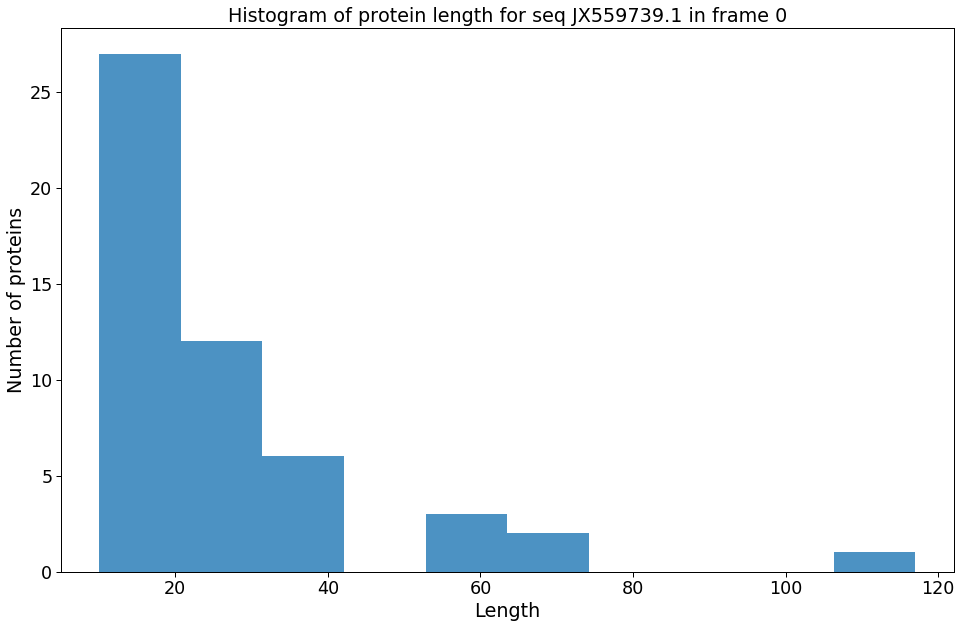


Current frame is  1
It has been found 51 proteins
There were 38 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	16
3	5
4	10
5	5
6	1



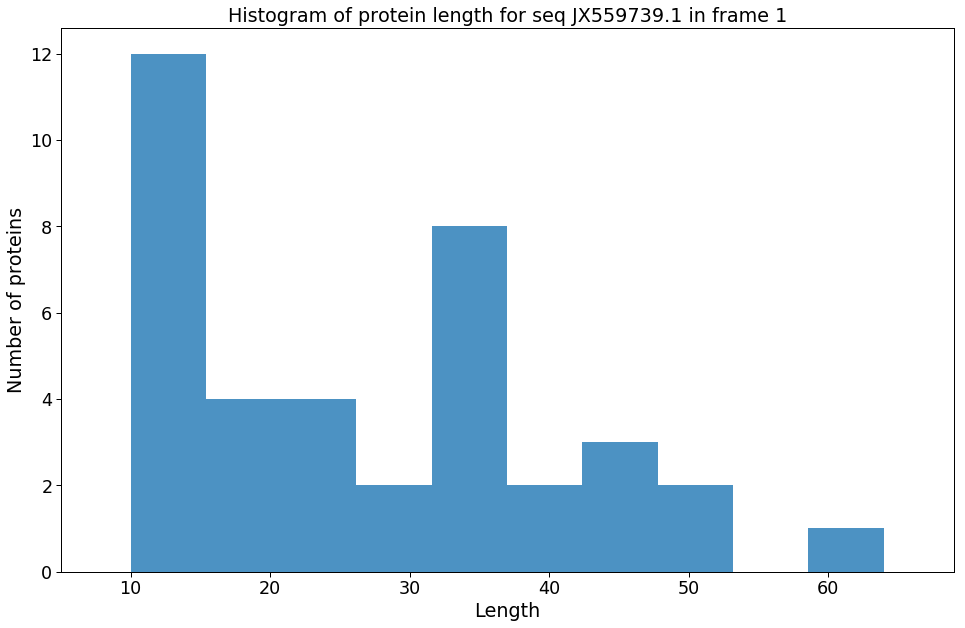


Current frame is  2
It has been found 70 proteins
There were 53 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	21
3	13
4	8
5	2
6	2
7	2
8	2
9	0
10	2
11	0
12	0
13	0
14	0



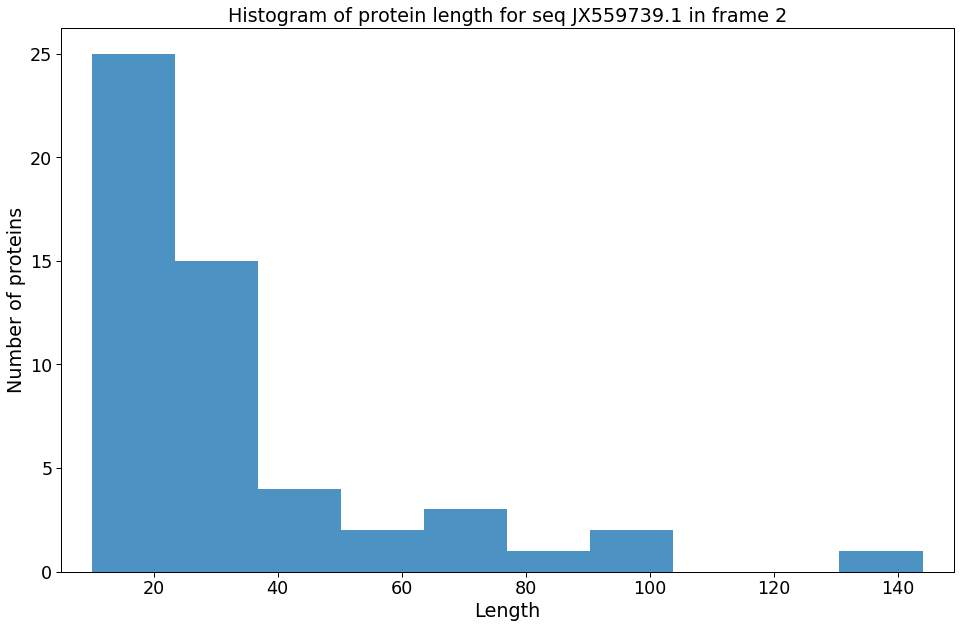


Current frame is  3
It has been found 102 proteins
There were 56 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	14
4	6
5	7
6	0
7	2
8	0



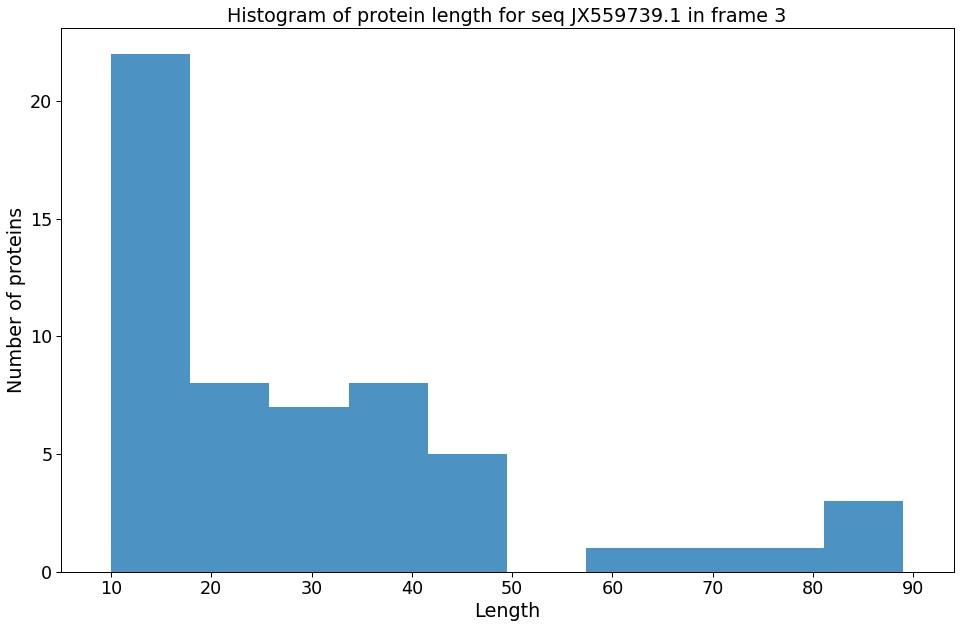


Current frame is  4
It has been found 150 proteins
There were 107 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	37
3	21
4	14
5	11
6	7
7	4
8	8
9	3
10	0
11	0
12	1
13	0
14	0



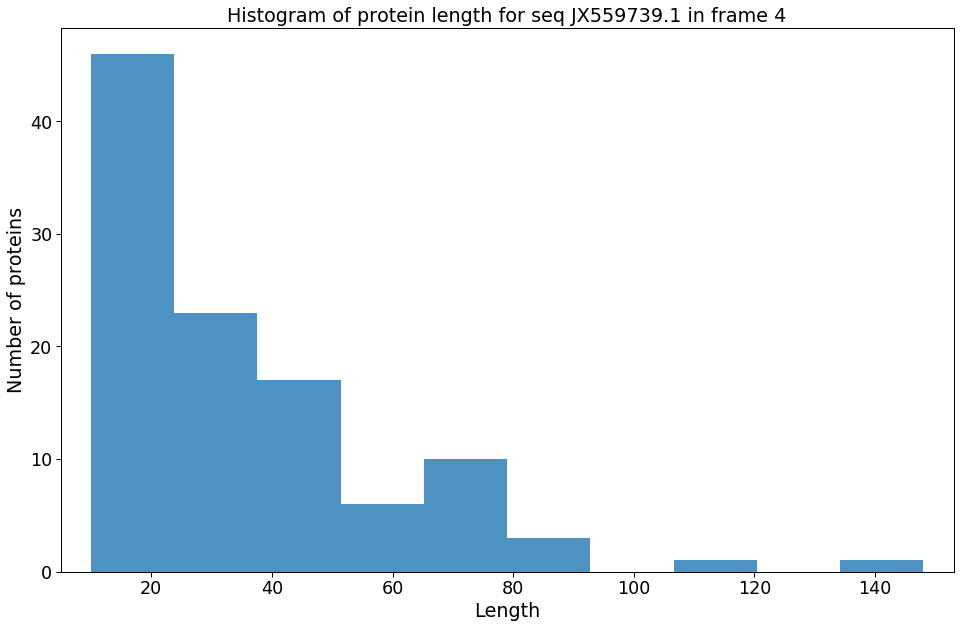


Current frame is  5
It has been found 102 proteins
There were 48 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	14
4	10
5	2
6	1
7	0
8	0
9	0



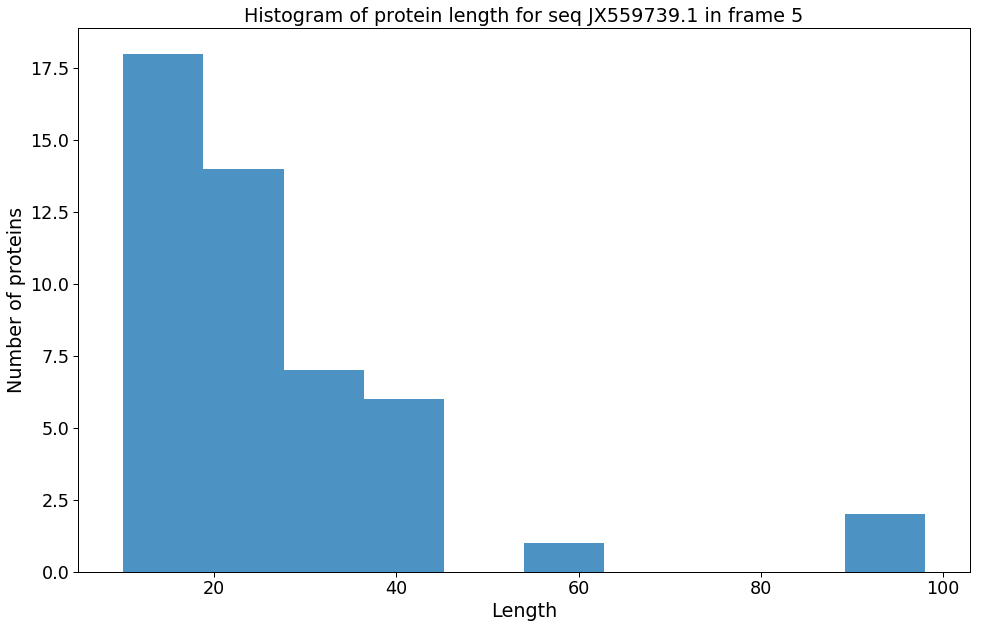


Codone composition of the seq:
UUU 240
UUC 171
UUA 230
UUG 209
UCU 178
UCC 89
UCA 170
UCG 89
UAU 189
UAC 102
UAA 0
UAG 0
UGU 114
UGC 119
UGA 0
UGG 192
CUU 165
CUC 181
CUA 195
CUG 137
CCU 268
CCC 149
CCA 131
CCG 107
CAU 175
CAC 121
CAA 163
CAG 122
CGU 84
CGC 54
CGA 94
CGG 110
AUU 336
AUC 162
AUA 264
AUG 637
ACU 173
ACC 157
ACA 145
ACG 100
AAU 239
AAC 129
AAA 197
AAG 220
AGU 219
AGC 175
AGA 188
AGG 371
GUU 218
GUC 85
GUA 147
GUG 200
GCU 234
GCC 141
GCA 193
GCG 110
GAU 141
GAC 84
GAA 151
GAG 159
GGU 170
GGC 128
GGA 160
GGG 345

Done
Seq name is  JX559740.1

Basic information about the sequence  JX559740.1

Nucleotide composition:
A 4743
T 4260
G 2712
C 5081

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 75 proteins
There were 51 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	24
3	14
4	6
5	1
6	1
7	4
8	0
9	0
10	0
11	0



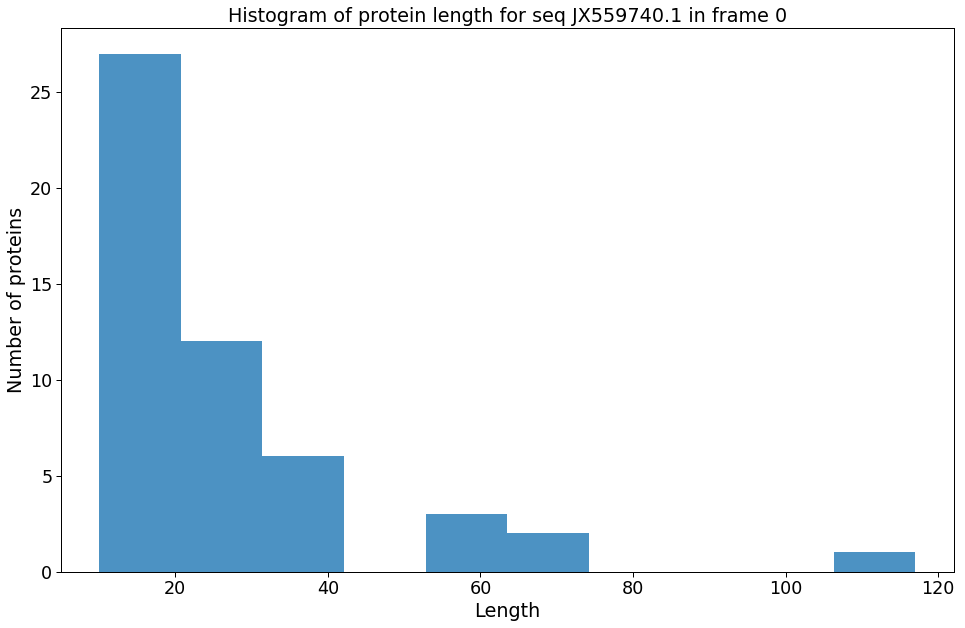


Current frame is  1
It has been found 51 proteins
There were 38 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	16
3	5
4	10
5	5
6	1



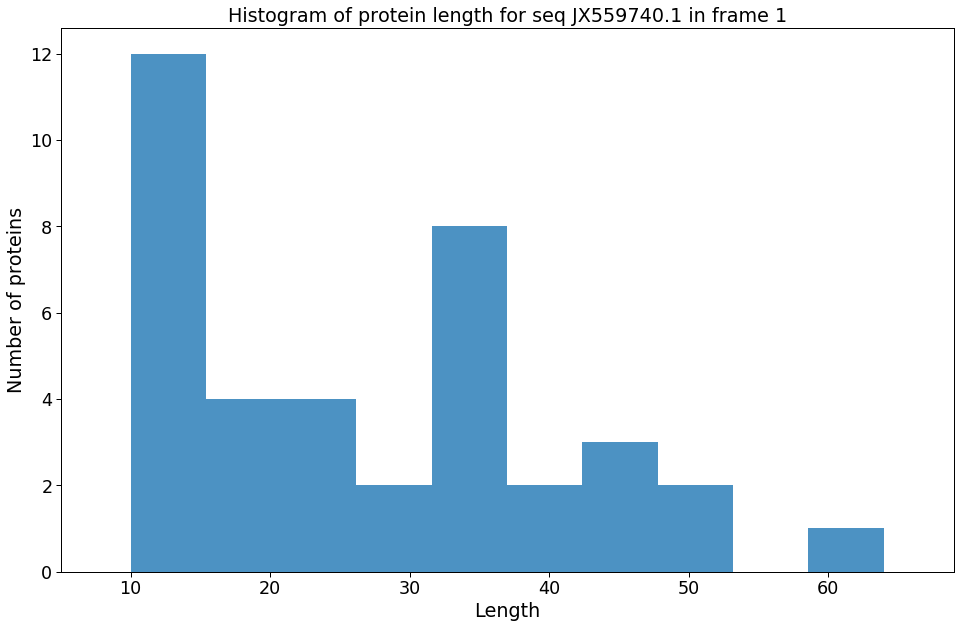


Current frame is  2
It has been found 70 proteins
There were 53 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	21
3	13
4	8
5	2
6	2
7	2
8	2
9	0
10	2
11	0
12	0
13	0
14	0



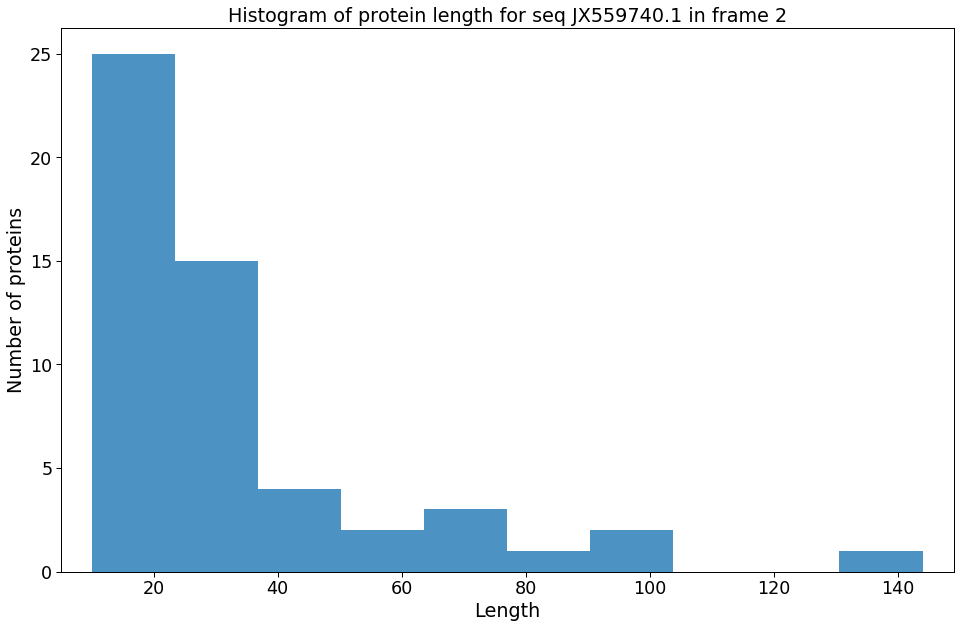


Current frame is  3
It has been found 102 proteins
There were 56 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	14
4	6
5	7
6	0
7	2
8	0



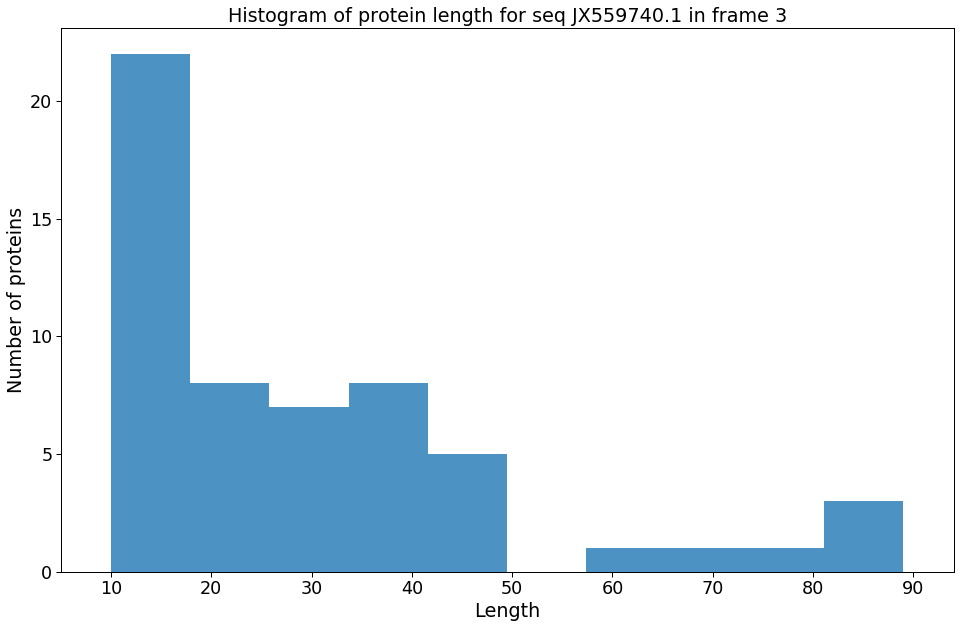


Current frame is  4
It has been found 150 proteins
There were 107 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	37
3	21
4	14
5	11
6	7
7	4
8	8
9	3
10	0
11	0
12	1
13	0
14	0



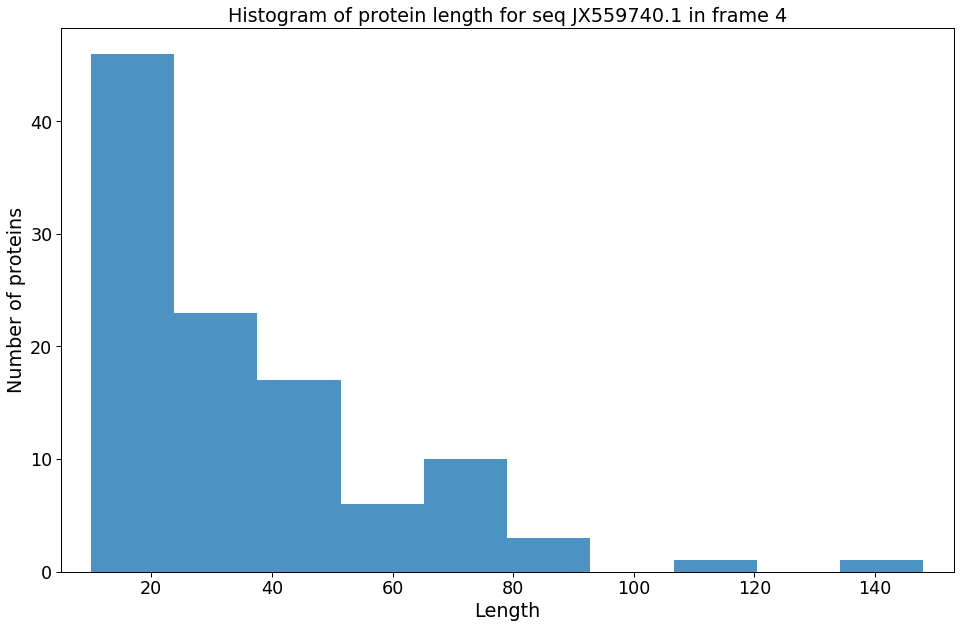


Current frame is  5
It has been found 102 proteins
There were 48 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	14
4	10
5	2
6	1
7	0
8	0
9	0



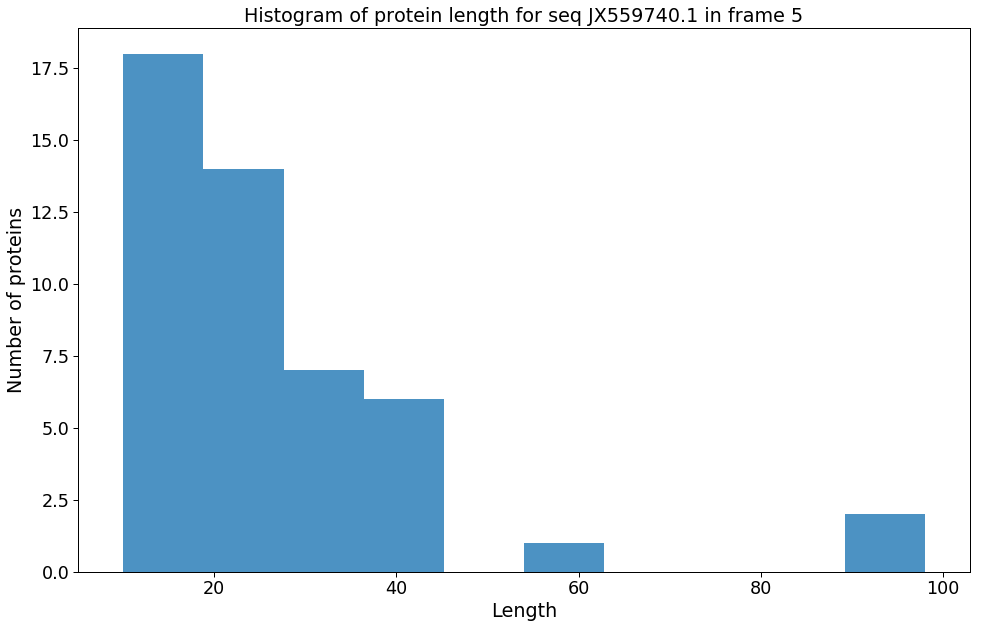


Codone composition of the seq:
UUU 480
UUC 342
UUA 460
UUG 418
UCU 356
UCC 178
UCA 340
UCG 178
UAU 378
UAC 204
UAA 0
UAG 0
UGU 228
UGC 238
UGA 0
UGG 384
CUU 331
CUC 362
CUA 390
CUG 274
CCU 535
CCC 298
CCA 262
CCG 214
CAU 350
CAC 242
CAA 326
CAG 244
CGU 168
CGC 108
CGA 188
CGG 220
AUU 672
AUC 324
AUA 528
AUG 1274
ACU 346
ACC 314
ACA 290
ACG 200
AAU 478
AAC 258
AAA 394
AAG 441
AGU 438
AGC 352
AGA 376
AGG 741
GUU 436
GUC 170
GUA 294
GUG 400
GCU 468
GCC 282
GCA 386
GCG 220
GAU 282
GAC 168
GAA 302
GAG 318
GGU 340
GGC 254
GGA 320
GGG 690

Done
Seq name is  JX559741.1

Basic information about the sequence  JX559741.1

Nucleotide composition:
A 4741
T 4259
G 2712
C 5083

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 59 proteins
There were 43 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	17
3	9
4	7
5	5
6	2
7	2
8	0
9	0
10	0
11	0



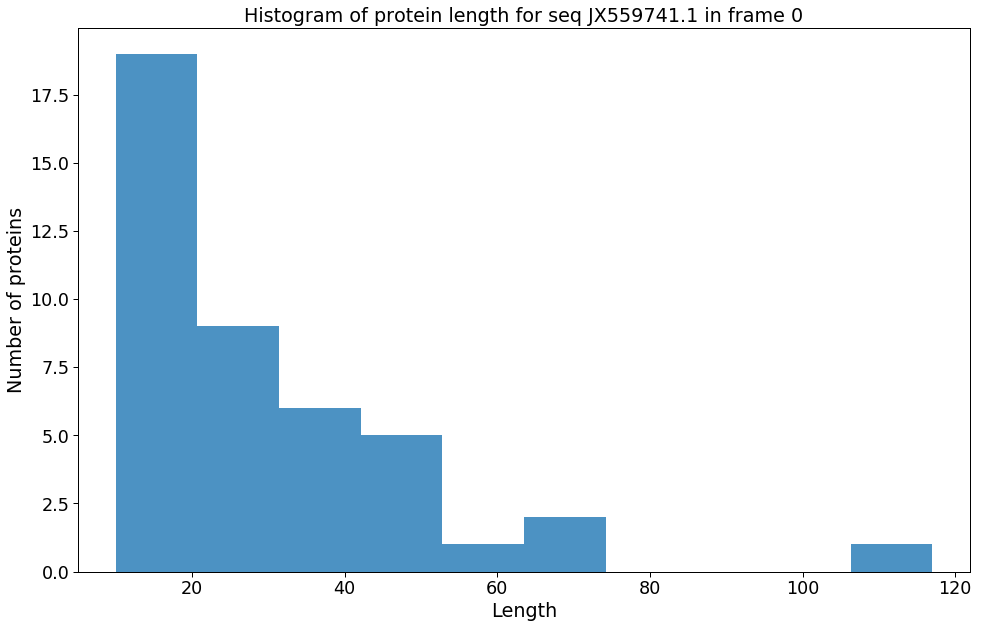


Current frame is  1
It has been found 73 proteins
There were 54 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	12
4	9
5	2
6	2
7	2
8	1
9	0
10	2
11	0
12	0
13	0
14	0



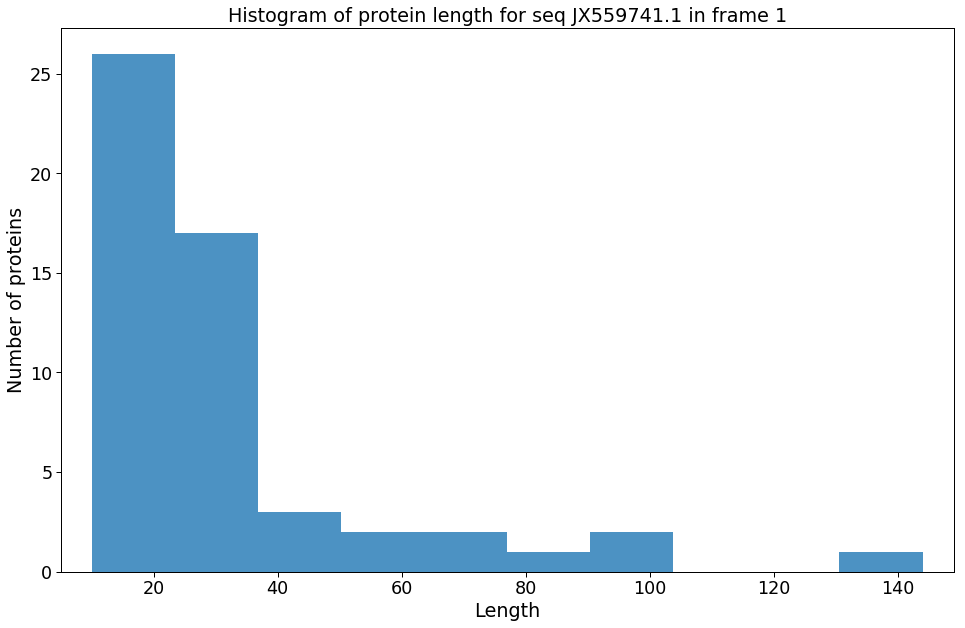


Current frame is  2
It has been found 64 proteins
There were 44 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	20
3	11
4	8
5	1
6	0



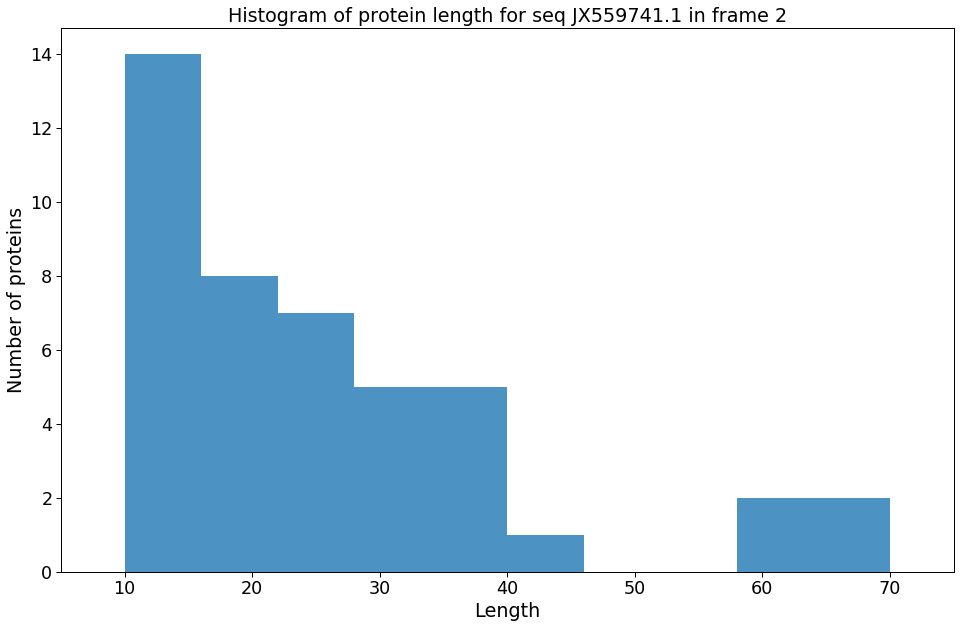


Current frame is  3
It has been found 98 proteins
There were 56 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	25
3	14
4	6
5	9
6	0



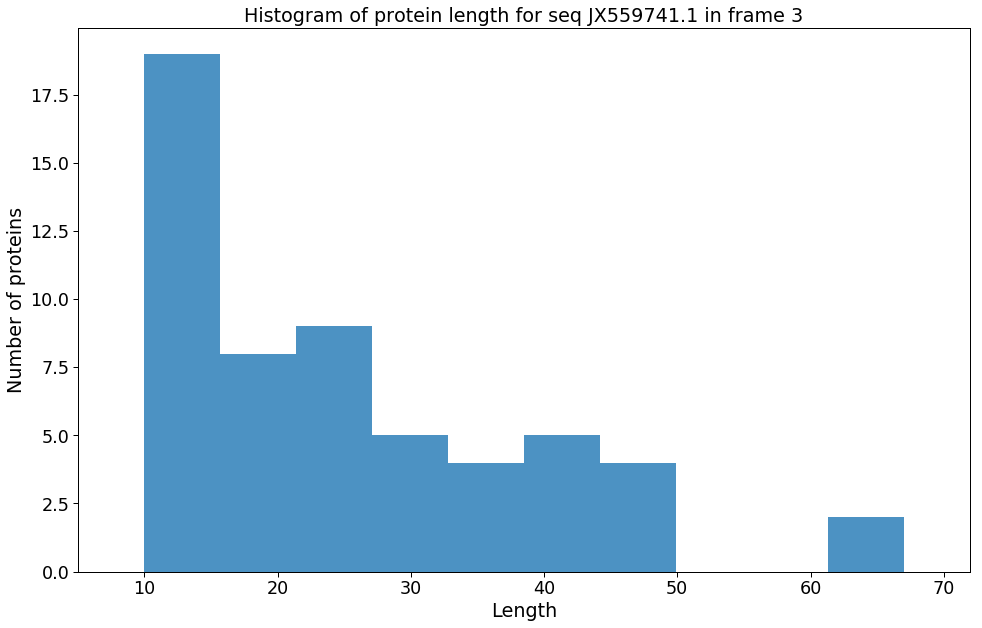


Current frame is  4
It has been found 142 proteins
There were 99 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	33
3	21
4	12
5	9
6	7
7	4
8	8
9	3
10	0
11	0
12	1
13	0
14	0



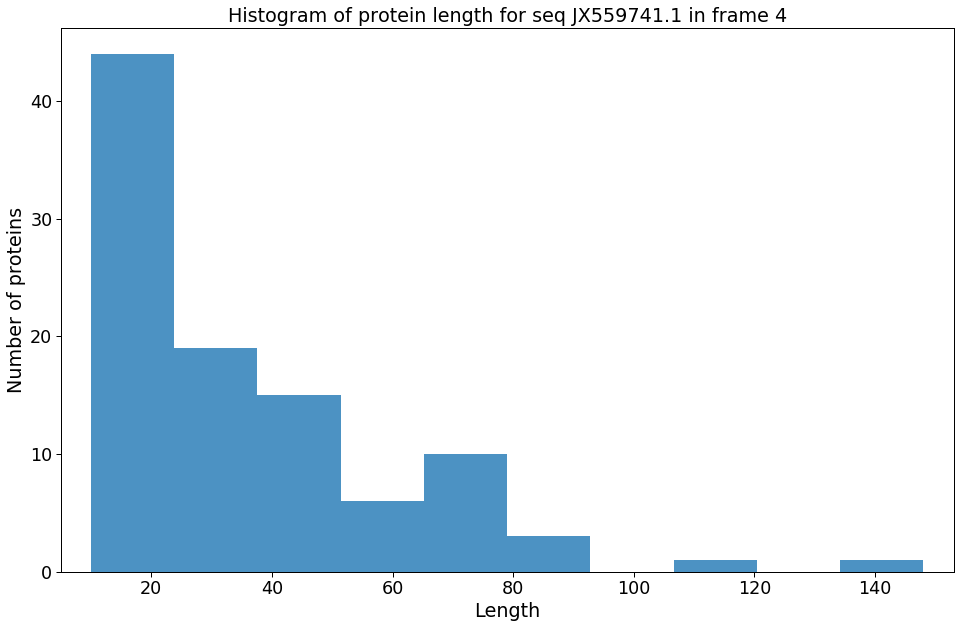


Current frame is  5
It has been found 114 proteins
There were 56 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	21
3	14
4	12
5	2
6	1
7	0
8	0
9	4



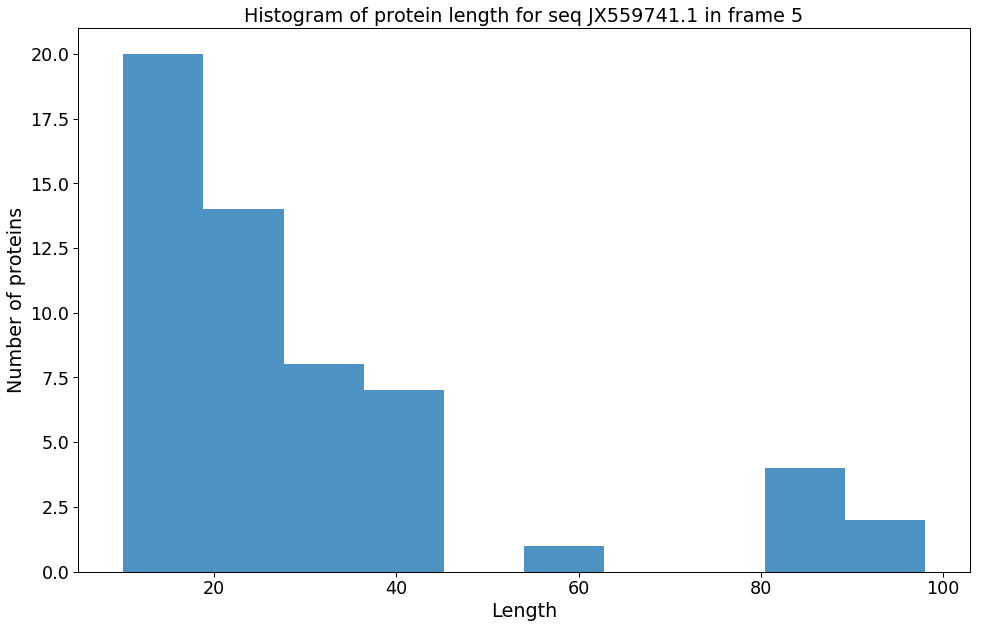


Codone composition of the seq:
UUU 720
UUC 513
UUA 689
UUG 627
UCU 534
UCC 266
UCA 510
UCG 267
UAU 569
UAC 304
UAA 0
UAG 0
UGU 342
UGC 357
UGA 0
UGG 577
CUU 495
CUC 542
CUA 584
CUG 410
CCU 802
CCC 448
CCA 394
CCG 321
CAU 524
CAC 363
CAA 488
CAG 366
CGU 252
CGC 162
CGA 282
CGG 329
AUU 1007
AUC 486
AUA 793
AUG 1909
ACU 519
ACC 471
ACA 435
ACG 299
AAU 717
AAC 387
AAA 591
AAG 661
AGU 657
AGC 526
AGA 564
AGG 1112
GUU 654
GUC 255
GUA 441
GUG 600
GCU 701
GCC 424
GCA 578
GCG 330
GAU 423
GAC 252
GAA 453
GAG 477
GGU 510
GGC 383
GGA 480
GGG 1035

Done
Seq name is  JX559742.1

Basic information about the sequence  JX559742.1

Nucleotide composition:
A 4745
T 4260
G 2711
C 5080

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 75 proteins
There were 51 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	24
3	14
4	6
5	1
6	1
7	4
8	0
9	0
10	0
11	0



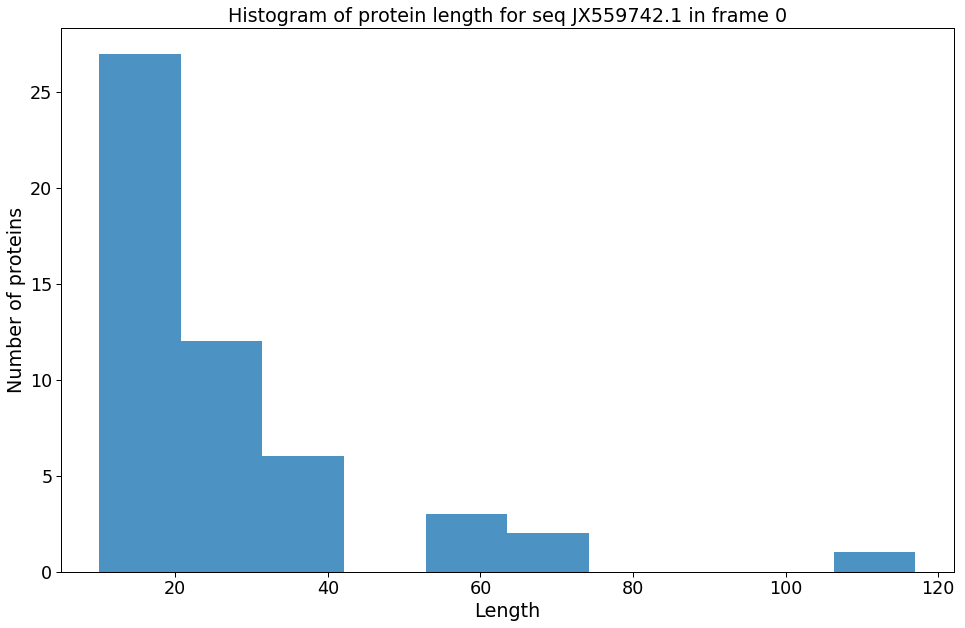


Current frame is  1
It has been found 51 proteins
There were 38 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	16
3	5
4	10
5	5
6	1



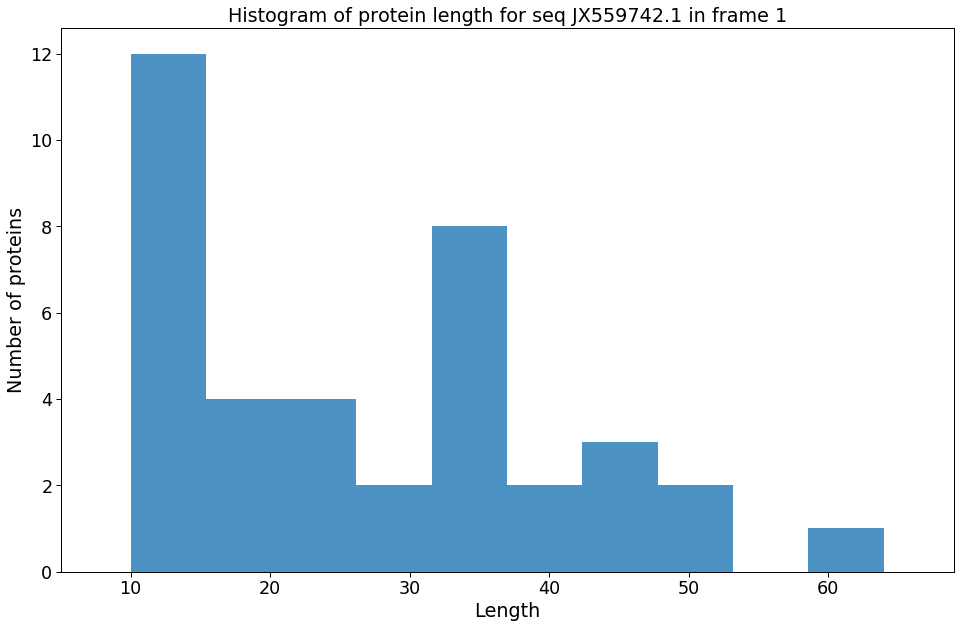


Current frame is  2
It has been found 70 proteins
There were 53 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	21
3	13
4	8
5	2
6	2
7	2
8	2
9	0
10	2
11	0
12	0
13	0
14	0



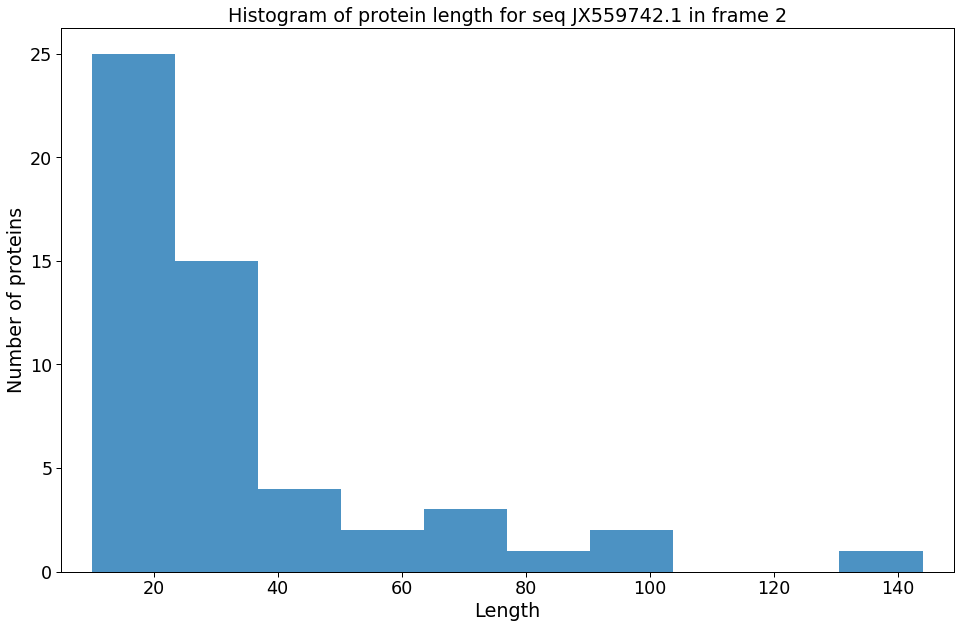


Current frame is  3
It has been found 102 proteins
There were 56 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	14
4	6
5	7
6	0
7	2
8	0



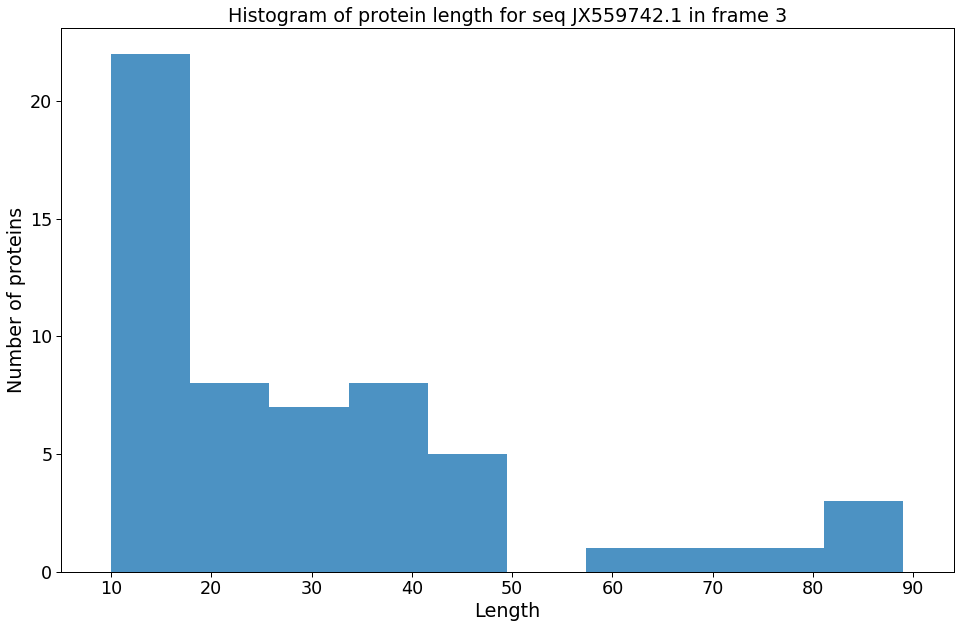


Current frame is  4
It has been found 151 proteins
There were 108 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	37
3	21
4	15
5	11
6	7
7	4
8	8
9	3
10	0
11	0
12	1
13	0
14	0



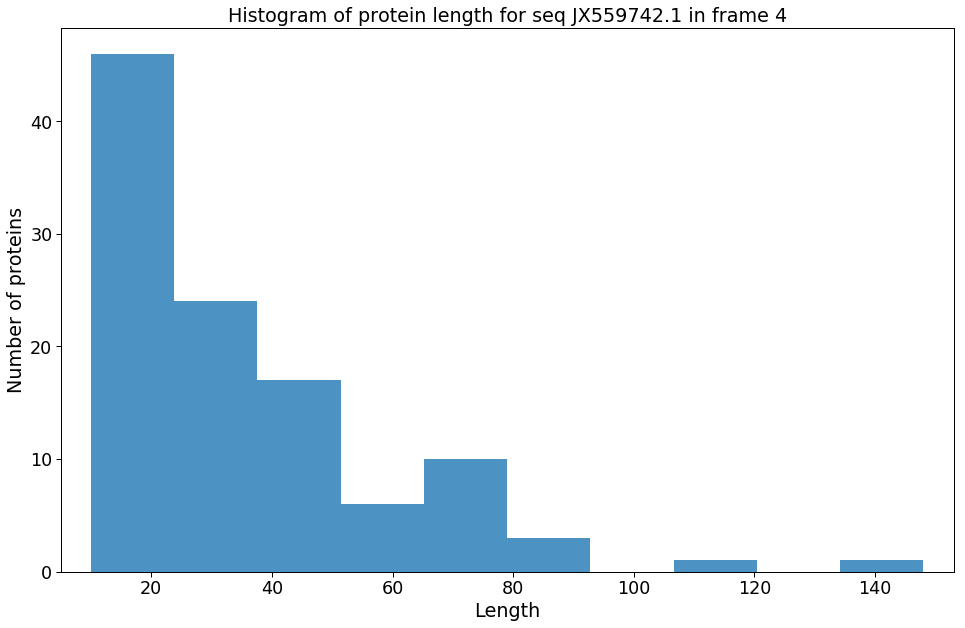


Current frame is  5
It has been found 102 proteins
There were 48 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	14
4	10
5	2
6	1
7	0
8	0
9	0



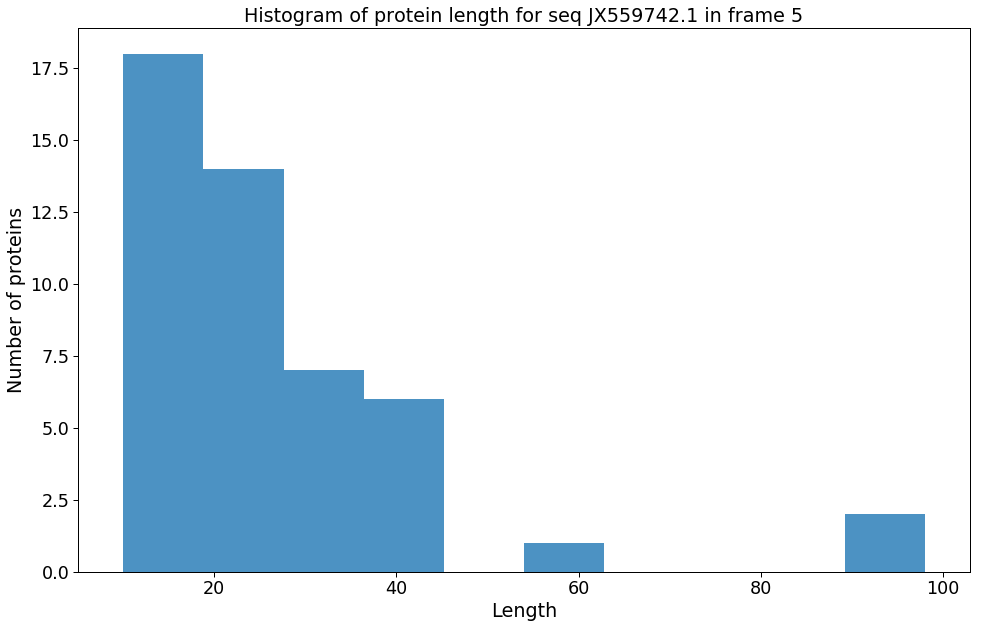


Codone composition of the seq:
UUU 960
UUC 684
UUA 921
UUG 836
UCU 713
UCC 356
UCA 681
UCG 357
UAU 760
UAC 405
UAA 0
UAG 0
UGU 458
UGC 477
UGA 0
UGG 770
CUU 660
CUC 723
CUA 779
CUG 547
CCU 1070
CCC 597
CCA 526
CCG 427
CAU 700
CAC 484
CAA 652
CAG 489
CGU 337
CGC 216
CGA 376
CGG 441
AUU 1343
AUC 648
AUA 1058
AUG 2550
ACU 692
ACC 629
ACA 581
ACG 399
AAU 959
AAC 516
AAA 789
AAG 880
AGU 877
AGC 699
AGA 752
AGG 1483
GUU 872
GUC 341
GUA 588
GUG 801
GCU 934
GCC 566
GCA 772
GCG 440
GAU 566
GAC 337
GAA 605
GAG 635
GGU 680
GGC 513
GGA 641
GGG 1381

Done
Seq name is  JX559743.1

Basic information about the sequence  JX559743.1

Nucleotide composition:
A 4717
T 4371
G 2647
C 4803

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 67 proteins
There were 49 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	13
4	4
5	3
6	0
7	0
8	3
9	0
10	0
11	0
12	0
13	0
14	1
15	1



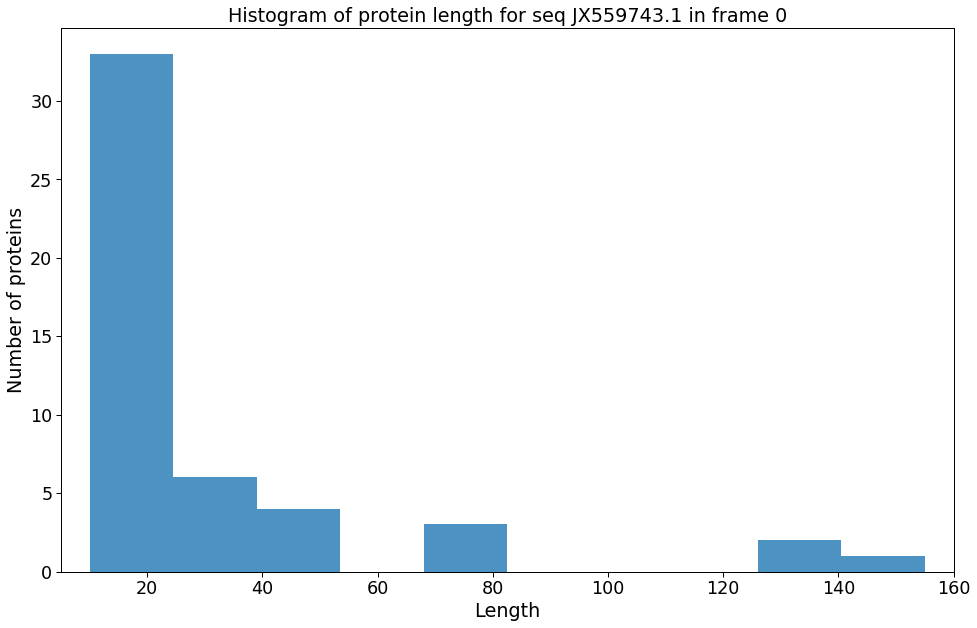


Current frame is  1
It has been found 57 proteins
There were 34 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	4
4	6
5	2
6	0
7	1
8	0
9	1



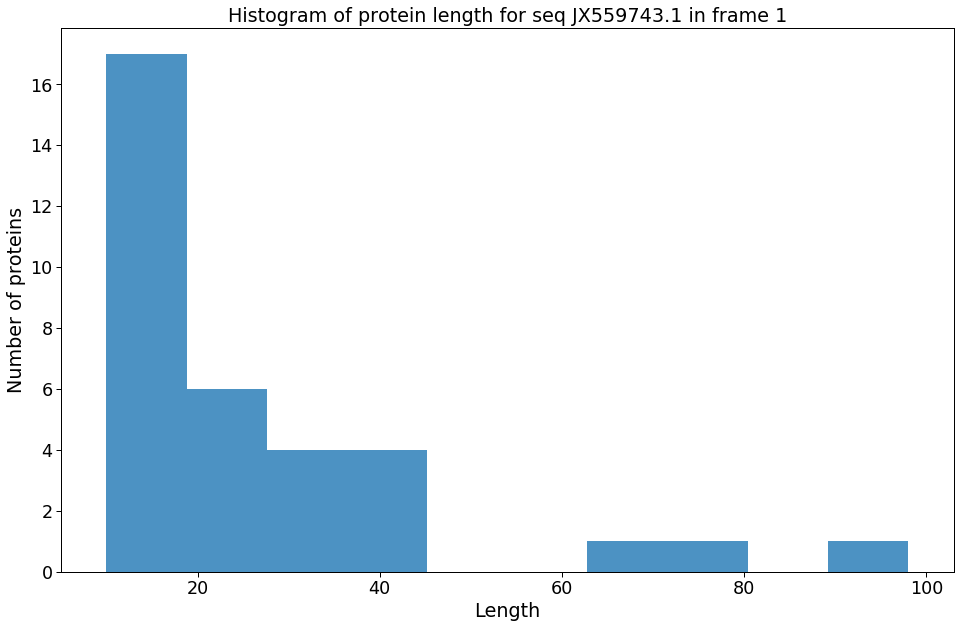


Current frame is  2
It has been found 61 proteins
There were 42 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	15
3	7
4	7
5	5
6	2
7	4
8	0
9	0
10	1



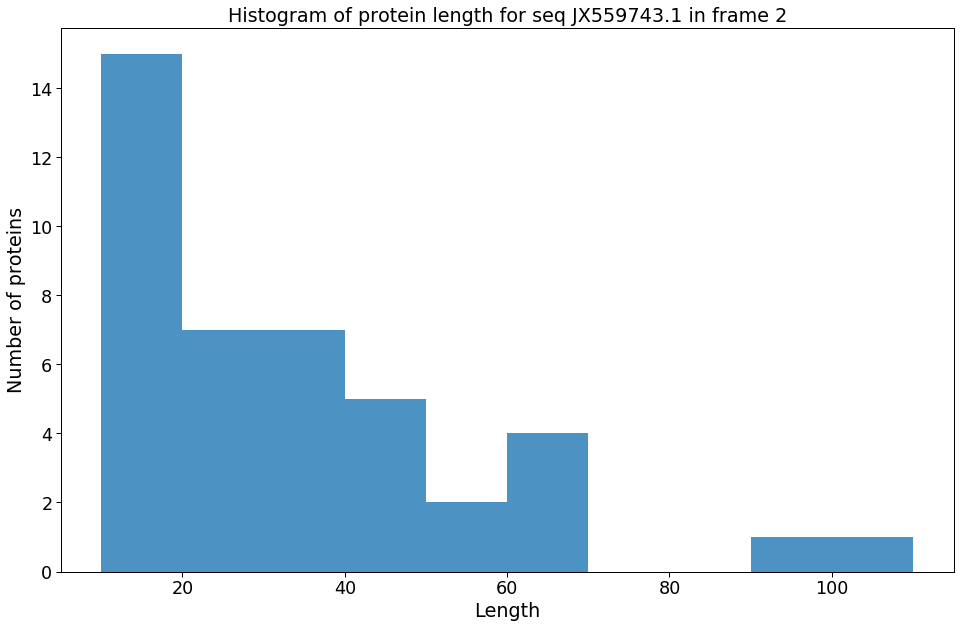


Current frame is  3
It has been found 103 proteins
There were 73 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	26
3	16
4	9
5	6
6	6
7	2
8	4
9	2
10	1
11	0
12	0



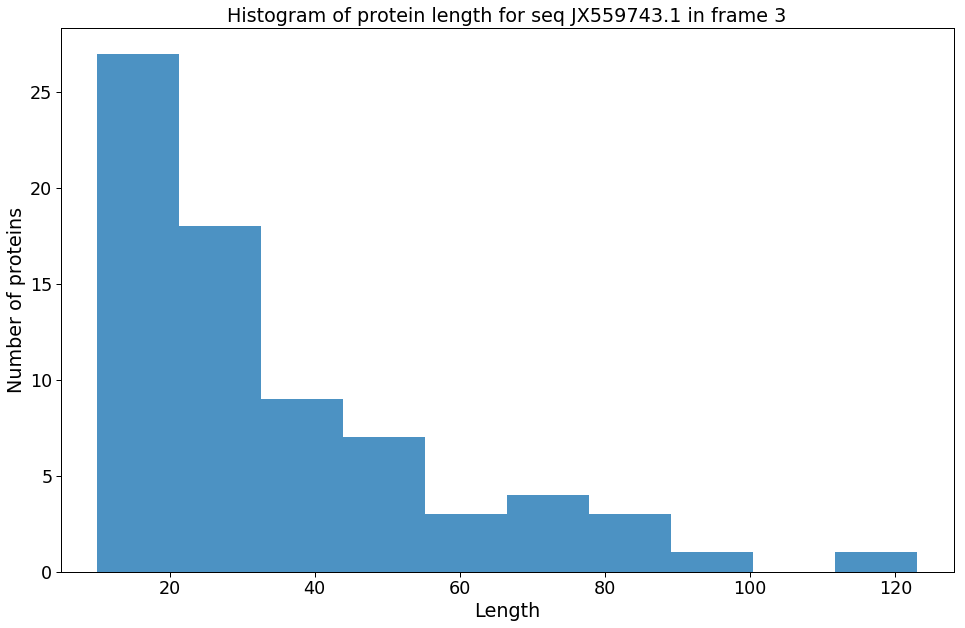


Current frame is  4
It has been found 114 proteins
There were 59 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	25
3	12
4	5
5	6
6	2
7	1
8	1
9	0
10	0
11	2
12	1
13	1
14	0
15	0
16	1
17	1



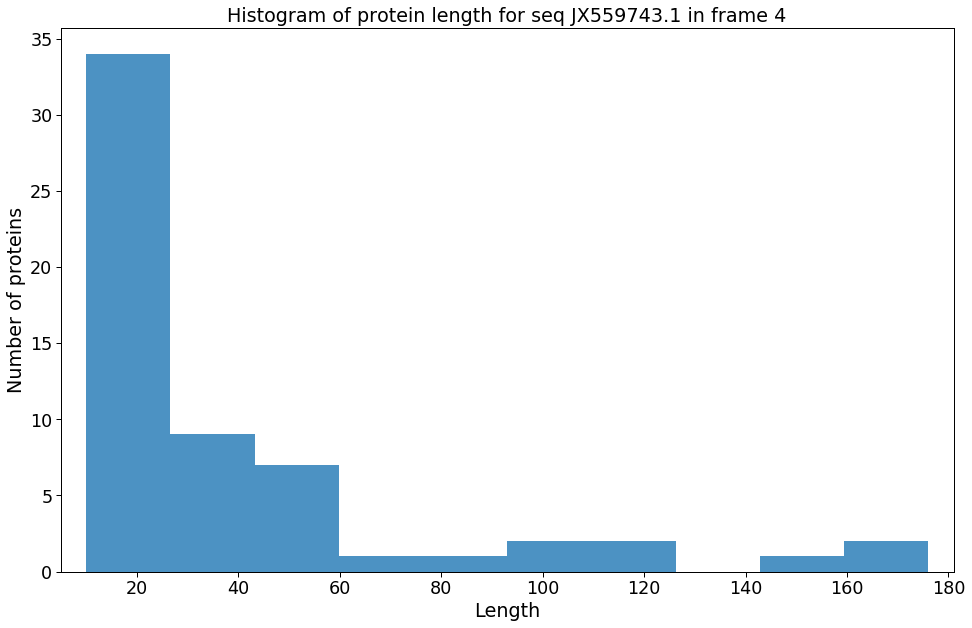


Current frame is  5
It has been found 73 proteins
There were 38 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	22
3	3
4	6
5	4
6	1
7	1



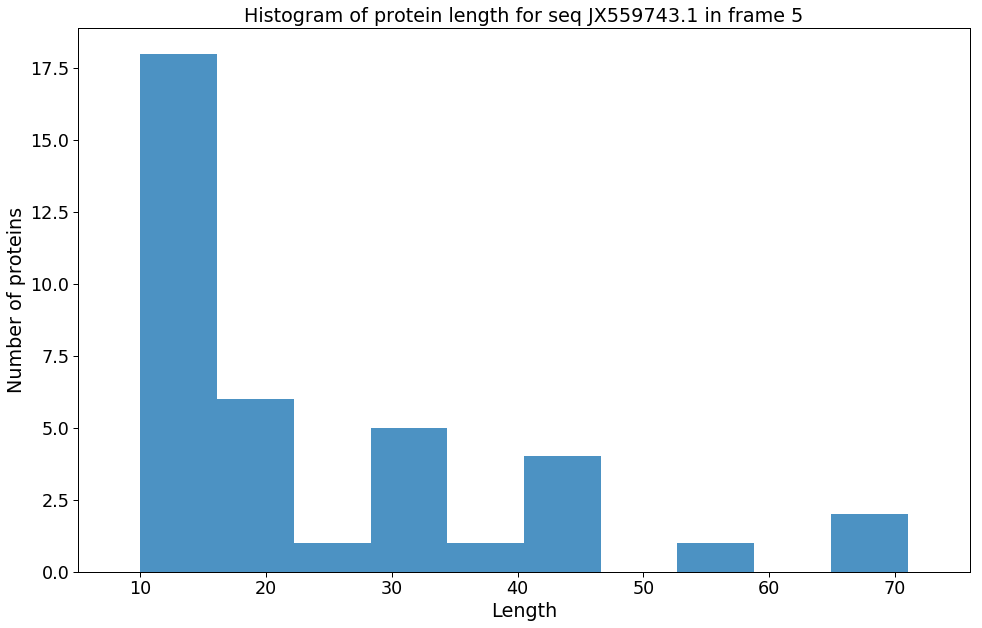


Codone composition of the seq:
UUU 1197
UUC 831
UUA 1173
UUG 1024
UCU 869
UCC 457
UCA 820
UCG 433
UAU 950
UAC 504
UAA 0
UAG 0
UGU 591
UGC 565
UGA 0
UGG 939
CUU 858
CUC 876
CUA 960
CUG 647
CCU 1310
CCC 741
CCA 664
CCG 508
CAU 854
CAC 584
CAA 790
CAG 600
CGU 404
CGC 270
CGA 446
CGG 519
AUU 1648
AUC 760
AUA 1314
AUG 2991
ACU 851
ACC 764
ACA 714
ACG 481
AAU 1186
AAC 652
AAA 989
AAG 1081
AGU 1086
AGC 826
AGA 944
AGG 1765
GUU 1081
GUC 421
GUA 778
GUG 943
GCU 1158
GCC 710
GCA 948
GCG 549
GAU 650
GAC 391
GAA 755
GAG 790
GGU 788
GGC 622
GGA 799
GGG 1635

Done
Seq name is  JX559744.1

Basic information about the sequence  JX559744.1

Nucleotide composition:
T 2866
C 3055
G 1849
A 3103

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 42 proteins
There were 24 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	14
3	3
4	4
5	1
6	0
7	1



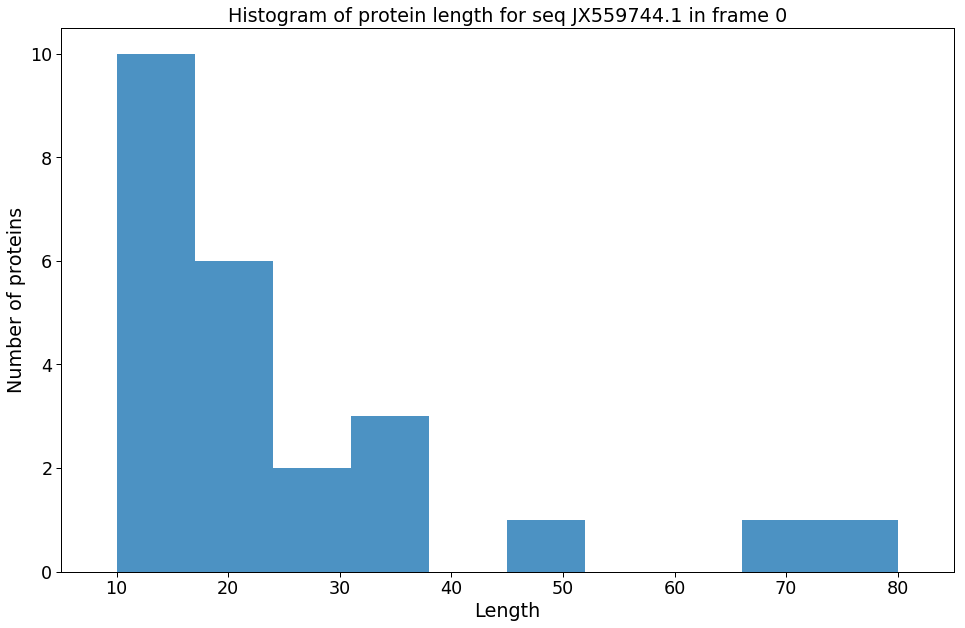


Current frame is  1
It has been found 40 proteins
There were 26 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	9
3	4
4	5
5	3
6	2
7	1
8	0
9	0
10	1



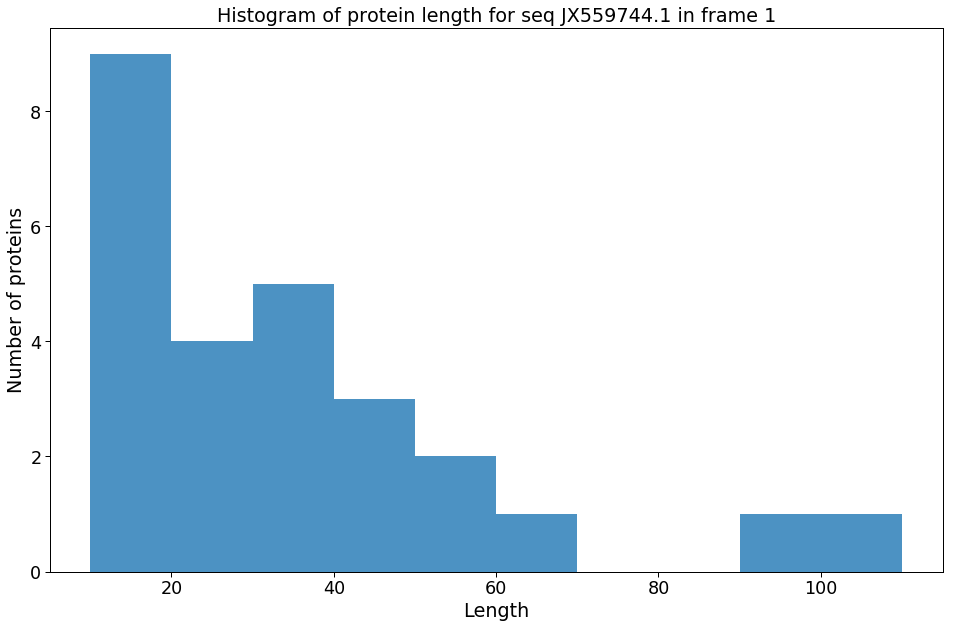


Current frame is  2
It has been found 46 proteins
There were 31 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	17
3	7
4	3
5	2
6	0
7	0
8	1
9	0
10	0
11	0
12	0
13	0



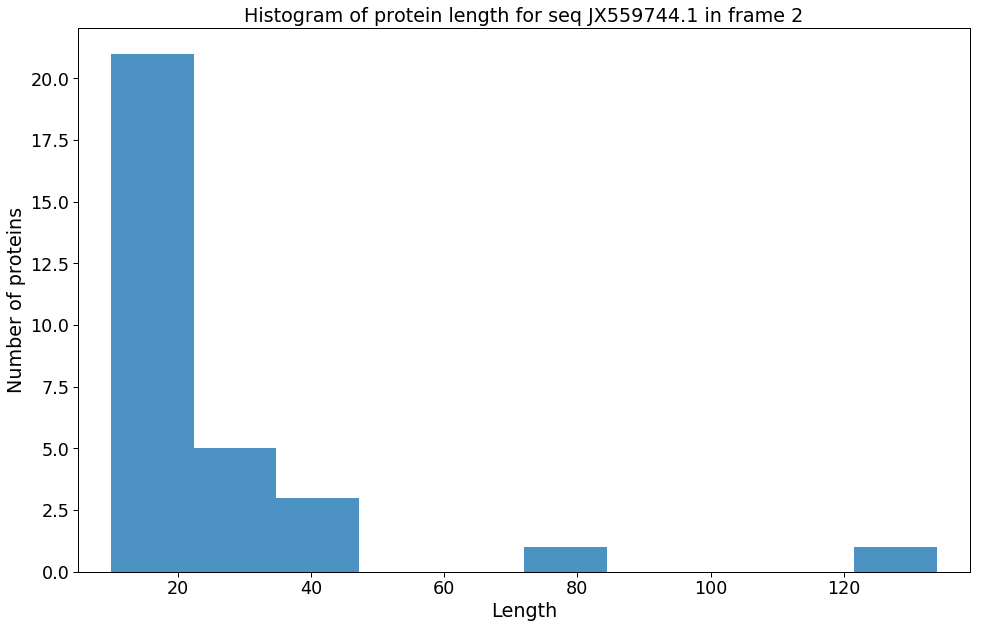


Current frame is  3
It has been found 60 proteins
There were 39 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	16
3	10
4	5
5	2
6	3
7	0
8	1
9	0
10	1
11	0
12	0



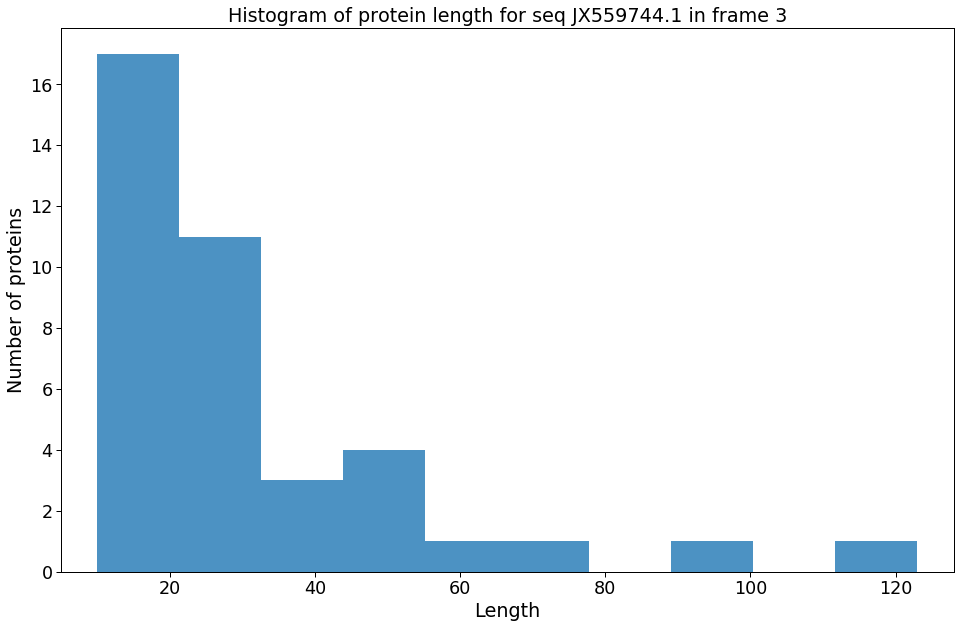


Current frame is  4
It has been found 87 proteins
There were 48 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	21
3	10
4	4
5	3
6	2
7	0
8	1
9	0
10	0
11	2
12	1
13	1
14	0
15	0
16	1
17	1



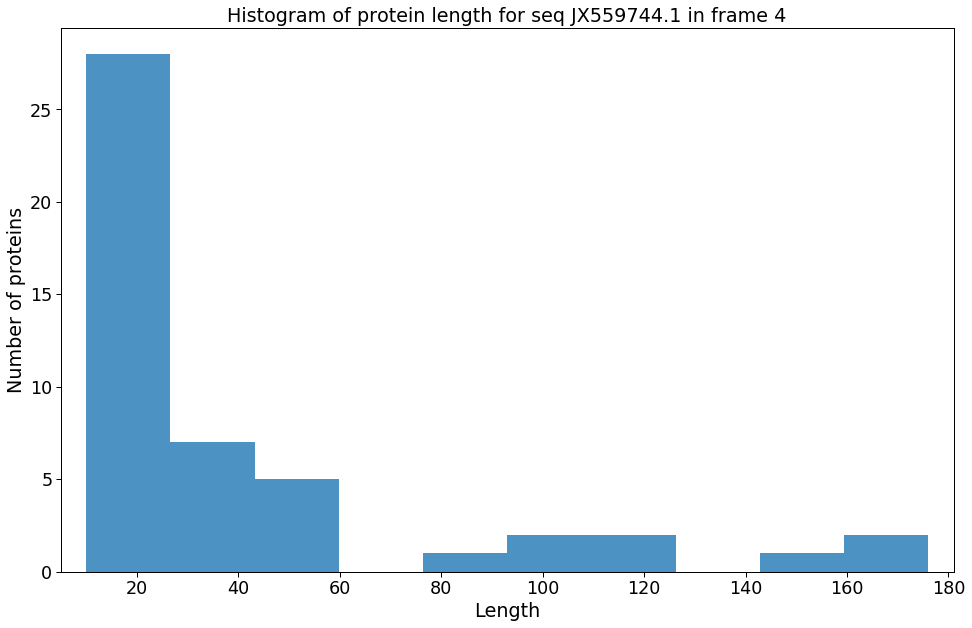


Current frame is  5
It has been found 51 proteins
There were 29 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	16
3	3
4	5
5	3
6	0
7	1



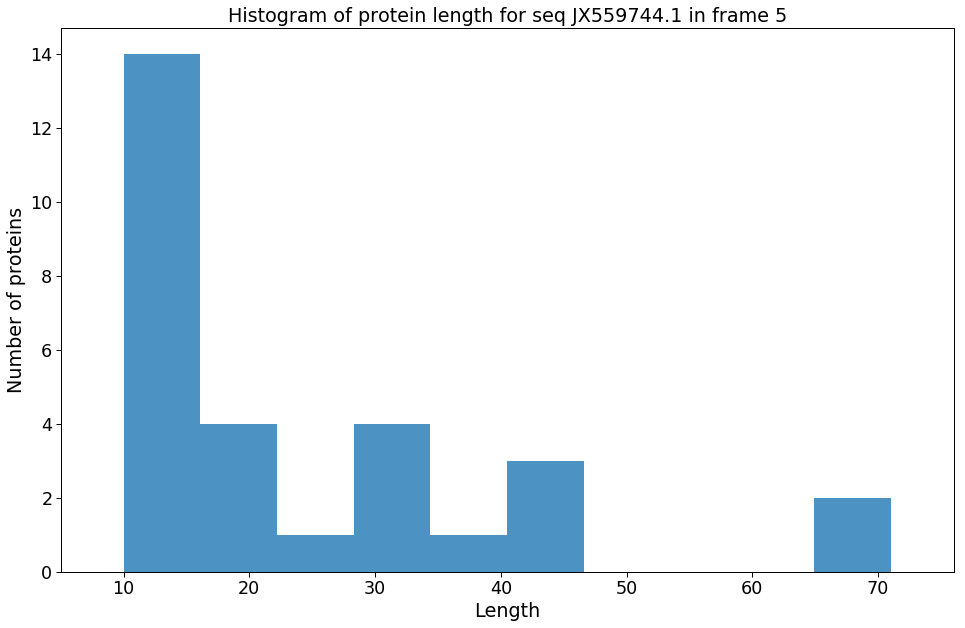


Codone composition of the seq:
UUU 1353
UUC 920
UUA 1317
UUG 1135
UCU 955
UCC 523
UCA 920
UCG 477
UAU 1071
UAC 583
UAA 0
UAG 0
UGU 678
UGC 613
UGA 0
UGG 1057
CUU 998
CUC 959
CUA 1060
CUG 698
CCU 1452
CCC 842
CCA 758
CCG 566
CAU 962
CAC 647
CAA 885
CAG 674
CGU 444
CGC 304
CGA 489
CGG 559
AUU 1863
AUC 824
AUA 1466
AUG 3276
ACU 952
ACC 837
ACA 797
ACG 538
AAU 1338
AAC 747
AAA 1120
AAG 1214
AGU 1235
AGC 898
AGA 1079
AGG 1957
GUU 1190
GUC 486
GUA 909
GUG 1041
GCU 1303
GCC 796
GCA 1068
GCG 611
GAU 705
GAC 421
GAA 854
GAG 881
GGU 875
GGC 703
GGA 903
GGG 1785

Done
Seq name is  JX559745.1

Basic information about the sequence  JX559745.1

Nucleotide composition:
A 4723
T 4373
G 2647
C 4805

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 67 proteins
There were 49 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	13
4	4
5	3
6	0
7	0
8	3
9	0
10	0
11	0
12	0
13	0
14	1
15	1



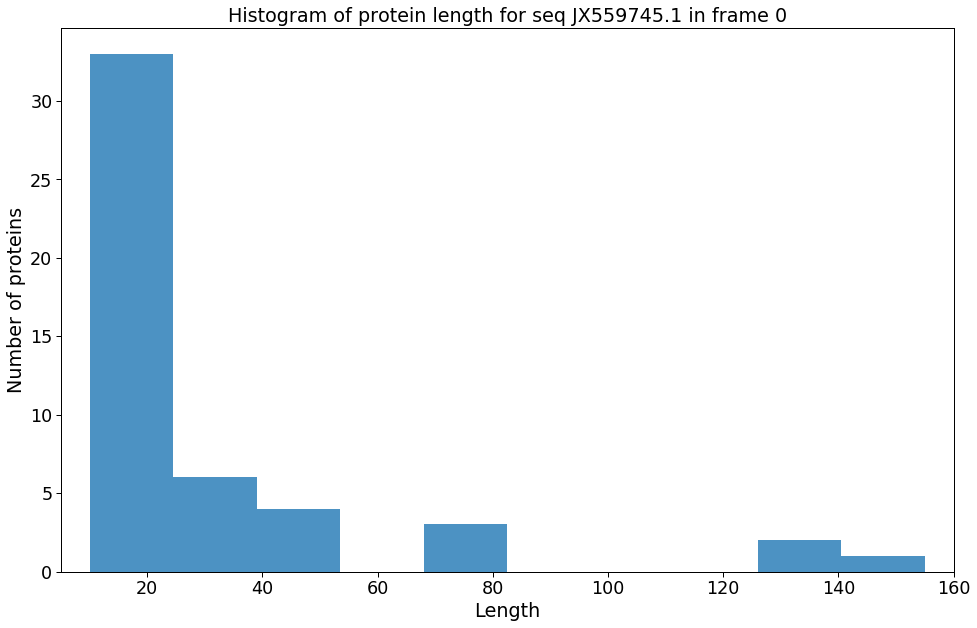


Current frame is  1
It has been found 57 proteins
There were 34 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	4
4	6
5	2
6	0
7	1
8	0
9	1



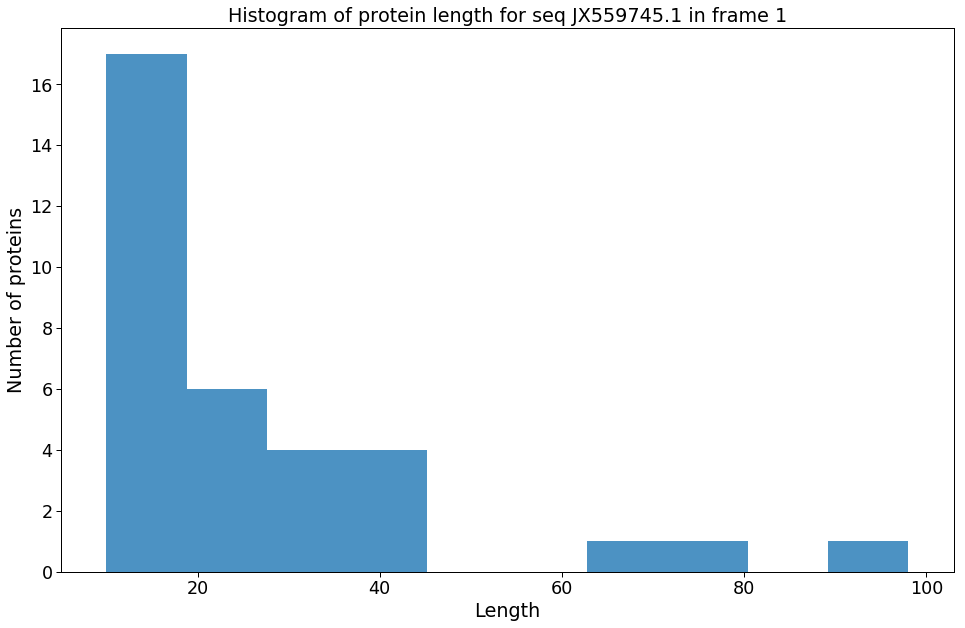


Current frame is  2
It has been found 61 proteins
There were 42 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	15
3	7
4	7
5	5
6	2
7	4
8	0
9	0
10	1



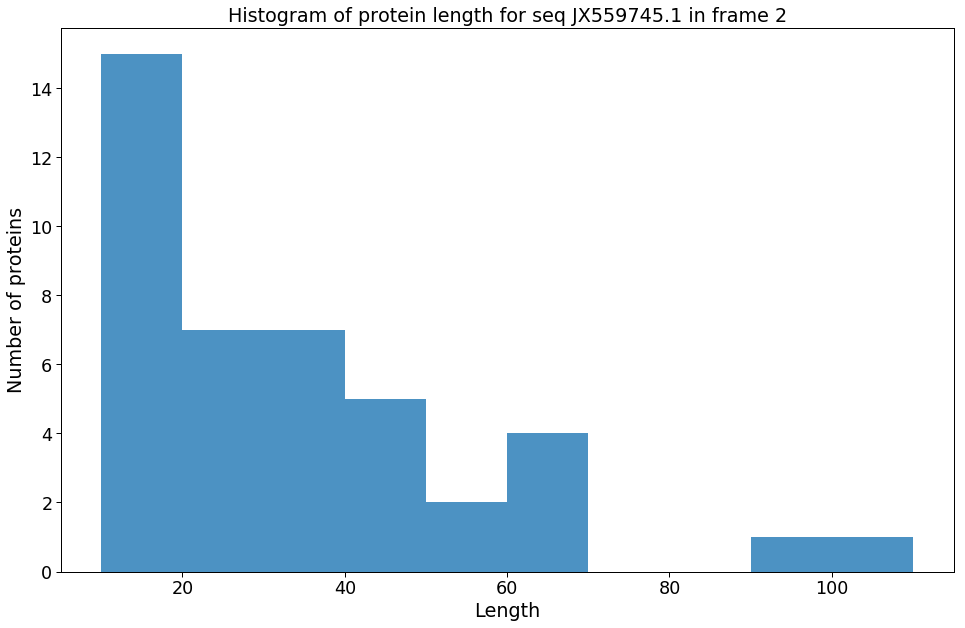


Current frame is  3
It has been found 73 proteins
There were 38 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	22
3	3
4	6
5	4
6	1
7	1



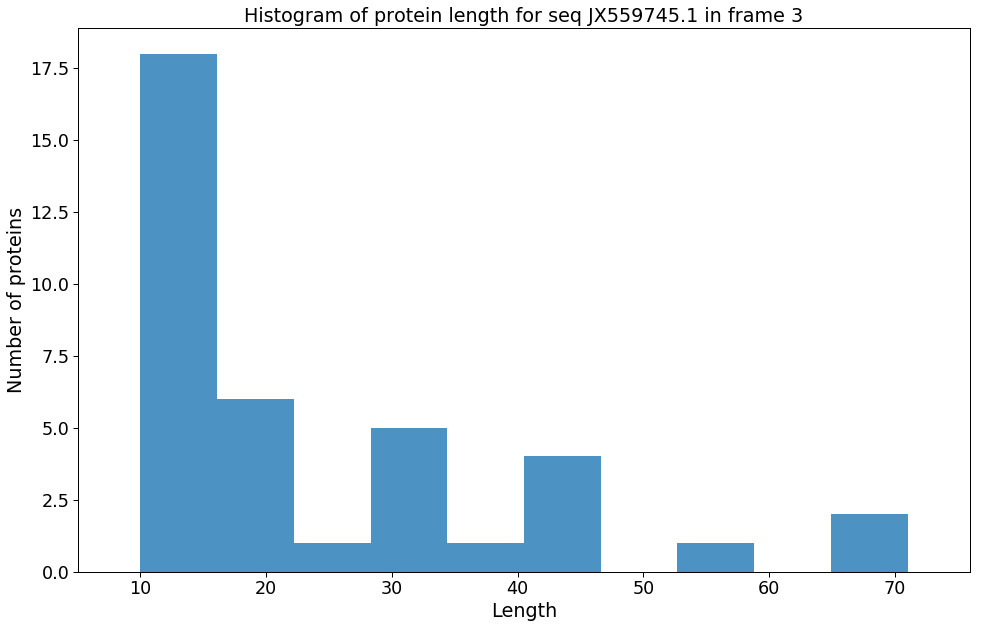


Current frame is  4
It has been found 103 proteins
There were 73 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	26
3	16
4	9
5	6
6	6
7	2
8	4
9	2
10	1
11	0
12	0



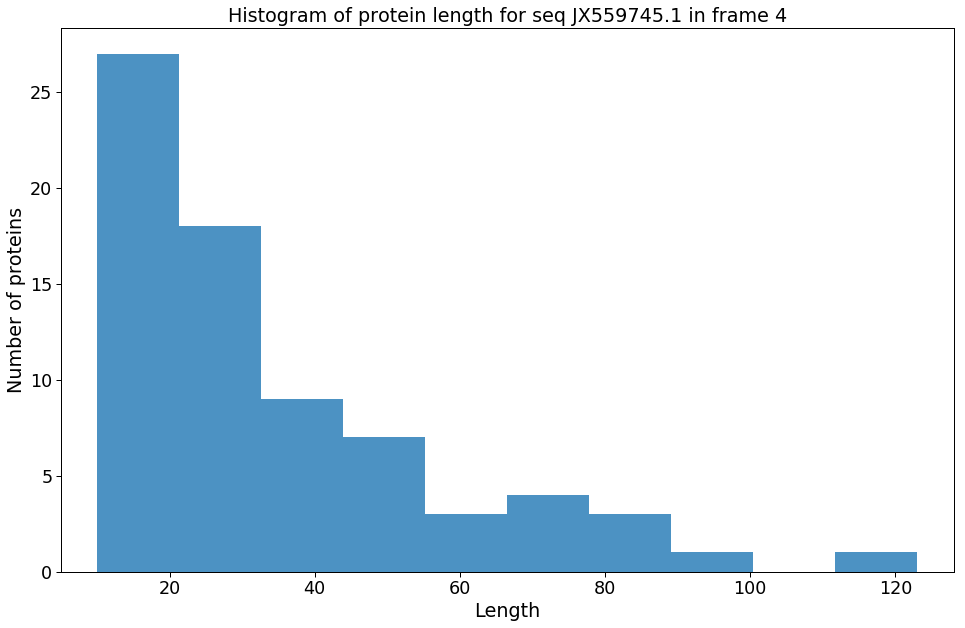


Current frame is  5
It has been found 114 proteins
There were 59 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	25
3	12
4	5
5	6
6	2
7	1
8	1
9	0
10	0
11	2
12	1
13	1
14	0
15	0
16	1
17	1



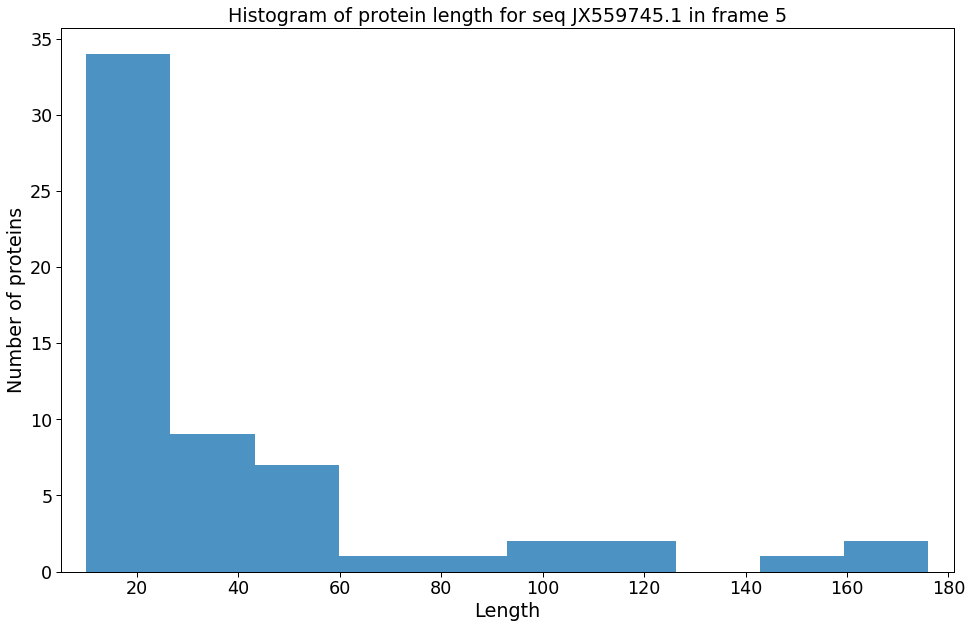


Codone composition of the seq:
UUU 1590
UUC 1067
UUA 1569
UUG 1323
UCU 1112
UCC 624
UCA 1059
UCG 553
UAU 1261
UAC 682
UAA 0
UAG 0
UGU 812
UGC 700
UGA 0
UGG 1226
CUU 1196
CUC 1112
CUA 1241
CUG 798
CCU 1691
CCC 986
CCA 896
CCG 647
CAU 1116
CAC 747
CAA 1023
CAG 785
CGU 511
CGC 358
CGA 559
CGG 637
AUU 2168
AUC 936
AUA 1722
AUG 3717
ACU 1111
ACC 972
ACA 930
ACG 620
AAU 1565
AAC 884
AAA 1320
AAG 1415
AGU 1444
AGC 1024
AGA 1271
AGG 2239
GUU 1400
GUC 566
GUA 1099
GUG 1183
GCU 1526
GCC 940
GCA 1244
GCG 720
GAU 789
GAC 475
GAA 1004
GAG 1036
GGU 983
GGC 812
GGA 1061
GGG 2039

Done
Seq name is  JX559746.1

Basic information about the sequence  JX559746.1

Nucleotide composition:
A 4716
T 4368
G 2646
C 4808

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 67 proteins
There were 49 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	23
3	13
4	4
5	3
6	0
7	0
8	3
9	0
10	0
11	0
12	0
13	0
14	1
15	1



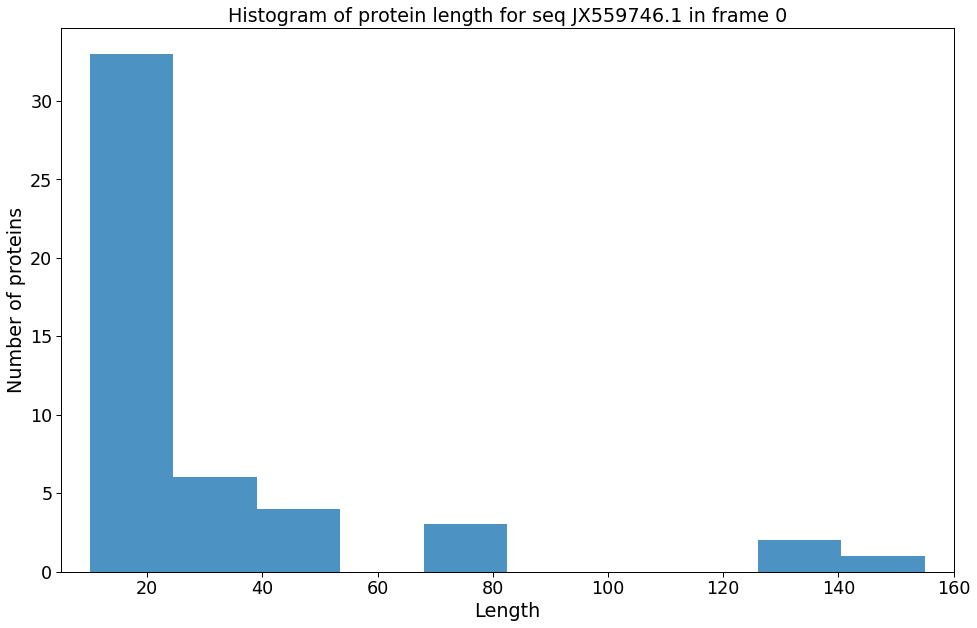


Current frame is  1
It has been found 56 proteins
There were 33 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	19
3	4
4	6
5	1
6	0
7	1
8	0
9	1



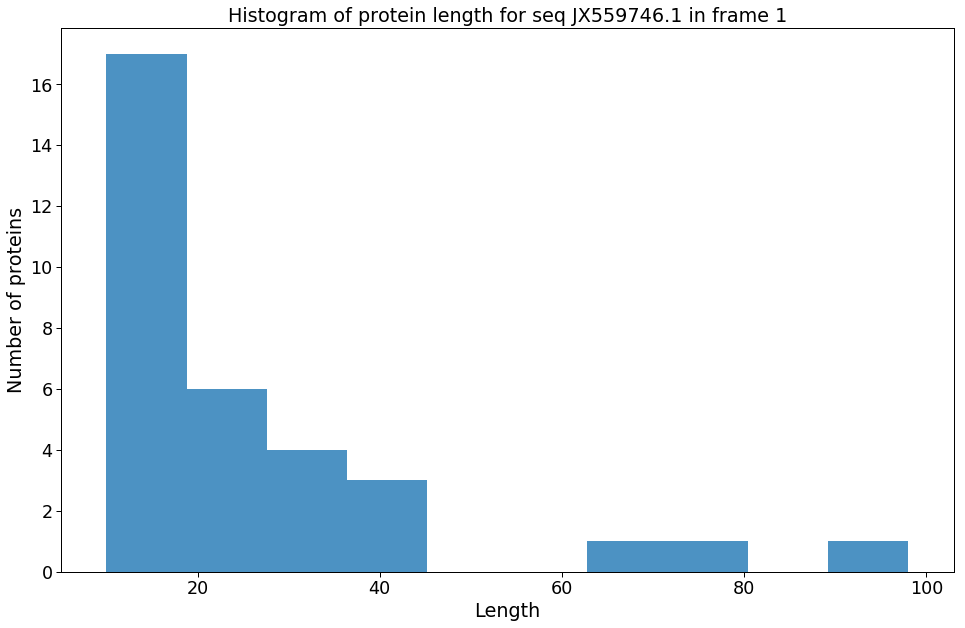


Current frame is  2
It has been found 61 proteins
There were 42 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	17
3	7
4	7
5	5
6	2
7	2
8	0
9	0
10	1



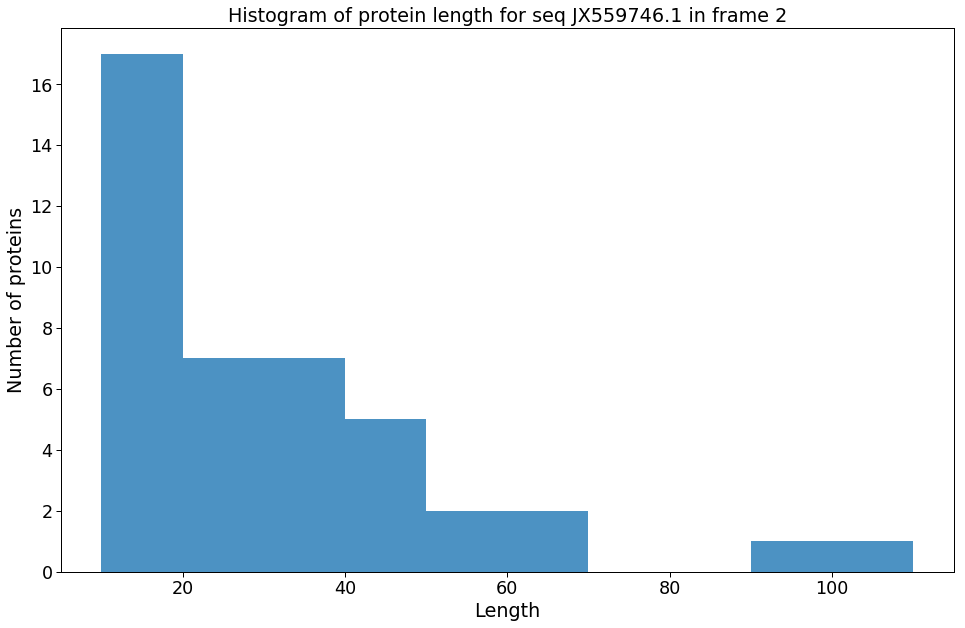


Current frame is  3
It has been found 104 proteins
There were 73 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	26
3	16
4	9
5	6
6	6
7	2
8	4
9	2
10	1
11	0
12	0



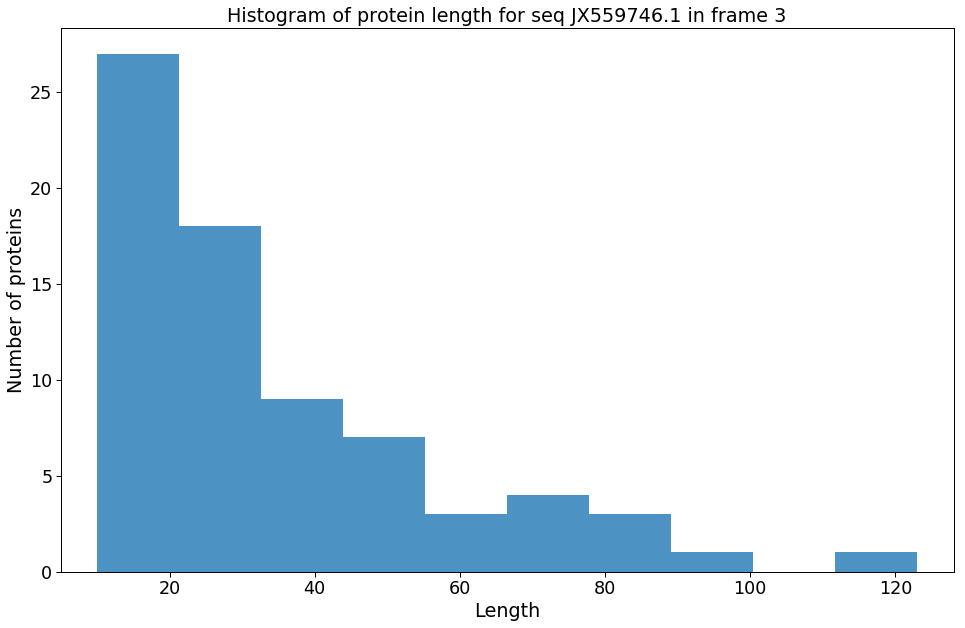


Current frame is  4
It has been found 113 proteins
There were 58 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	25
3	12
4	5
5	6
6	2
7	1
8	0
9	0
10	0
11	2
12	1
13	1
14	0
15	0
16	1
17	1



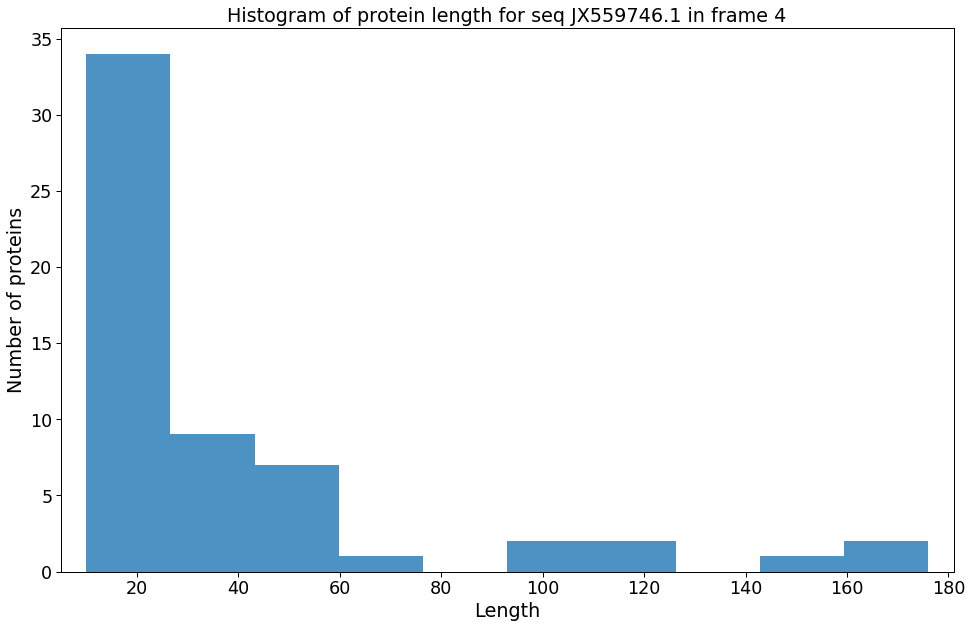


Current frame is  5
It has been found 73 proteins
There were 39 proteins with min length 10

Protein length by bins:
Bin size = 10
Bin	Score
1	0
2	22
3	4
4	6
5	4
6	1
7	1



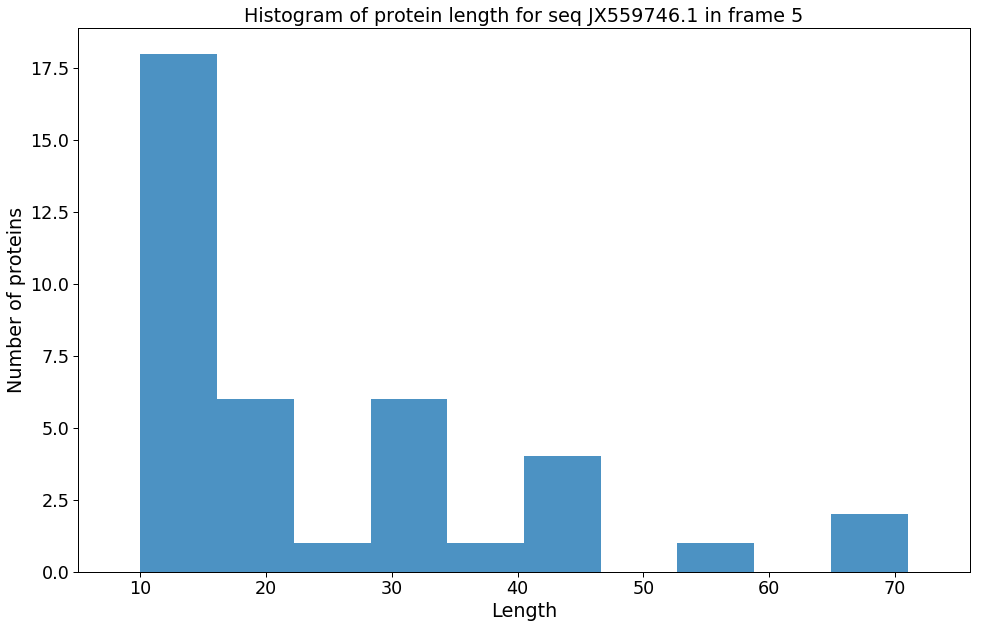


Codone composition of the seq:
UUU 1824
UUC 1212
UUA 1816
UUG 1507
UCU 1257
UCC 723
UCA 1198
UCG 629
UAU 1446
UAC 776
UAA 0
UAG 0
UGU 945
UGC 784
UGA 0
UGG 1389
CUU 1387
CUC 1259
CUA 1422
CUG 895
CCU 1914
CCC 1127
CCA 1027
CCG 727
CAU 1264
CAC 844
CAA 1159
CAG 889
CGU 576
CGC 413
CGA 625
CGG 716
AUU 2471
AUC 1042
AUA 1974
AUG 4160
ACU 1268
ACC 1107
ACA 1058
ACG 703
AAU 1781
AAC 1015
AAA 1518
AAG 1611
AGU 1646
AGC 1147
AGA 1460
AGG 2512
GUU 1607
GUC 646
GUA 1284
GUG 1325
GCU 1746
GCC 1081
GCA 1419
GCG 830
GAU 872
GAC 528
GAA 1157
GAG 1186
GGU 1090
GGC 918
GGA 1216
GGG 2293

Done


In [3]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# !!! Можно подавать файлы с несколькими последовательностями

import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

print("Start script") # задаем стартовые параметры
try:
    file = str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")

minimal_len_prot = int(input("Type the minimal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
codone_log_button = str(input("Do you want to have a codon log file? [y]/[n] "))
hist = str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = int(input("Type the bin size for protein histogram "))

code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}


log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


@log_wrapper("protein_translator log")
def protein_translator(line_in, codone_log_button = "y", code_calc = code_calc):
    code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}

    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    line_out = []
    amino_info_collector = {}

    if len(line_in) % 3 == 0:
        for i in range(0, len(line_in), 3):

            codon = line_in[i:(i + 3)]
            if codon in code_calc.keys(): # считаем кодоны
                code_calc[codon] = int(code_calc[codon]) + 1

                
            if codon in code.keys(): # считаем аминокислоты, но другим способом
                ama = code[codon]
                line_out = line_out + list(ama)
                if ama in amino_info_collector.keys():
                    amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
                else:
                    amino_info_collector[ama] = 1

    if codone_log_button == "y": # пишем в файл то, что насчиталось
        out_stat_file.write(">" + "frame_" + str(i) + "_" + str(j) + "_stat" + "\n")
        for i in amino_info_collector.keys():
            out_stat_file.write(str(i) + "\t" + str(amino_info_collector[i]) + "\n")

    if len(line_in) % 3 != 0: # добавляем N, пока длина последовательности не будет кратна 3м 
        while len(line_in) % 3 != 0:
            line_in = line_in + "N"
            protein_translator(line_in)
    line_out = "".join(line_out)
    return line_out


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------


with open(file, "r") as in_file:
    seqs={}
    for line in in_file:
        line = line.rstrip()
        if len(line) > 0:
            if line[0] == ">":
                words = line.split()
                name = words[0][1:]
                seqs[name] = ''
            else:
                seqs[name] = seqs[name] + line



for record in seqs.keys():
    sequence = seqs[record]
    name = record
    print("Seq name is ", name)
    
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
    sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

    nuc_stat = nuc_stat_counter(sequence)

    print("")
    print("Basic information about the sequence ", name)
    print("")
    print("Nucleotide composition:")
    for s in nuc_stat.keys():
        print(str(s), nuc_stat[s])
    print("")
    
                
    orf_dict = {}
    for i in range(3):  # перебираем каждую из рамок на прямой цепи
        print("Iteration", i)
        frame = i
        orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
        orf_dict[i] = orfs
    
    for j in range(3): # и на обратной
        print("Iteration", -j)
        frame_rev = j
        orfs_rev = orf_finder(sequence_rev, frame_rev)
        orf_dict[j + 3] = orfs_rev

    
    # получили словари с ORFs
    out_protein_orf_name = "out_protein_orf_" + str(name.split(" ")[0]) + ".fasta"
    out_codon_stat_name = "out_codon_stat_" + str(name.split(" ")[0]) + ".fasta"
    with open(out_protein_orf_name, "w") as out_file:
        with open(out_codon_stat_name, "w") as out_stat_file:
            for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
                print("Current frame is ",i)
                bin_len_list = []
                prot_calc = 0 # заводим счетчики для полипептидов
                prot_calc_min = 0
                for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
    
                    prot_calc += 1
                    if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
    
                        if len(sequence[left_border:right_border]) >= minimal_len_prot_3: 
                            line = protein_translator(sequence[left_border:right_border], codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n")
                            module_fasta_writer(out_file, line)
                            prot_calc_min += 1
                        else:
                            pass
    
                    if int(i) > 2 and len(orf_dict[i][j]) == 2:
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
    
                        if len(sequence[left_border:right_border]) >= minimal_len_prot_3:
                            line = protein_translator(sequence_rev[left_border:right_border], codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n")
                            module_fasta_writer(out_file, line)
                            prot_calc_min += 1
                        else:
                            pass
            

                print("It has been found " + str(prot_calc) + " proteins")
                print("There were " + str(prot_calc_min) + " proteins with min length " + str(minimal_len_prot))
                print("")
                
                print("Protein length by bins:")
                print("Bin size =", bin_size)
                l = numpy.array(bin_len_list)
                bins = numpy.arange(0, max(l), bin_size)
                print("Bin" + "\t" + "Score")
                for s in range(1,len(bins)):
                    print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
                print("")
    
                if hist == "y":
                    fig = matplotlib.pyplot.gcf()
                    fig.set_size_inches(16, 10)
                    sns.set_context("paper", font_scale=2)
            
                    plt.hist(l, bin_size, alpha = 0.8)
                    plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                    plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                    plt.xlabel('Length')
                    plt.ylabel('Number of proteins')
                    
                    plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                    plt.show()
                print("")
    
    print("Codone composition of the seq:")
    for s in code_calc.keys():
        print(str(s), code_calc[s])
    print("")
    
    
    print("Done")  # the end

Start script
Type the name of fasta file /home/pavel/Desktop/ORF_SMTB/Mitochondrial complete sequences/Pelophylax_mitochondrion_complete_genome.fasta
Type the minimal protein length 7
Type the maximal protein length 100
Do you want to have a codon log file? [y]/[n] y
Do you want to see a prot histogram visualization? [y]/[n] y
Type the bin size for protein histogram 5
Seq name is  KP260928.1

Basic information about the sequence  KP260928.1

Nucleotide composition:
G 2722
C 4726
T 5530
A 4999

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 68 proteins
There were 53 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	10
3	8
4	9
5	5
6	5
7	2
8	4
9	4
10	0
11	1
12	1
13	1
14	0
15	0
16	0
17	2
18	0



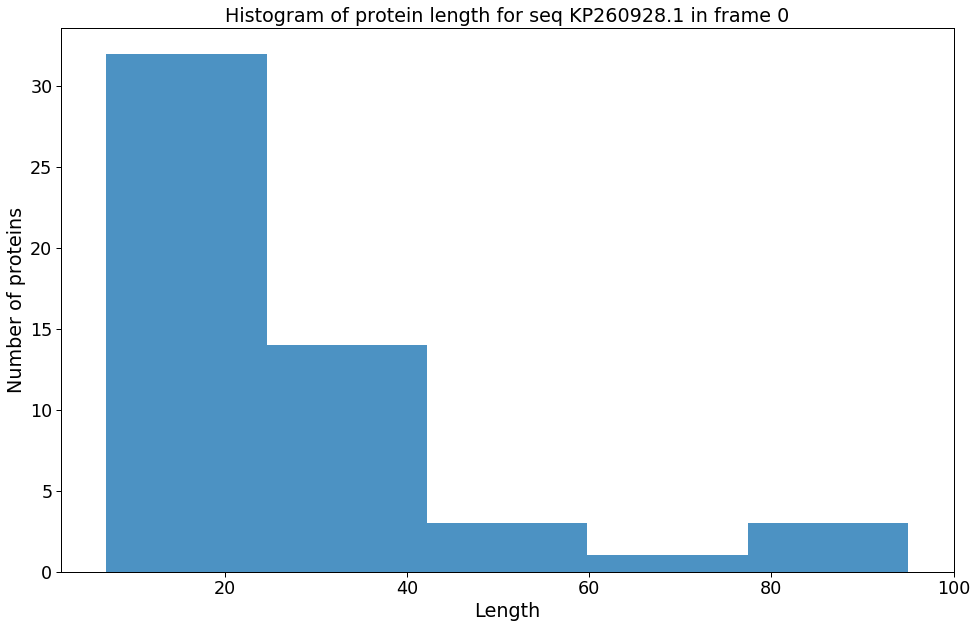


Current frame is  1
It has been found 85 proteins
There were 60 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	7
3	11
4	11
5	2
6	7
7	6
8	0
9	3
10	4
11	2
12	1
13	0
14	0
15	1
16	1
17	1
18	2



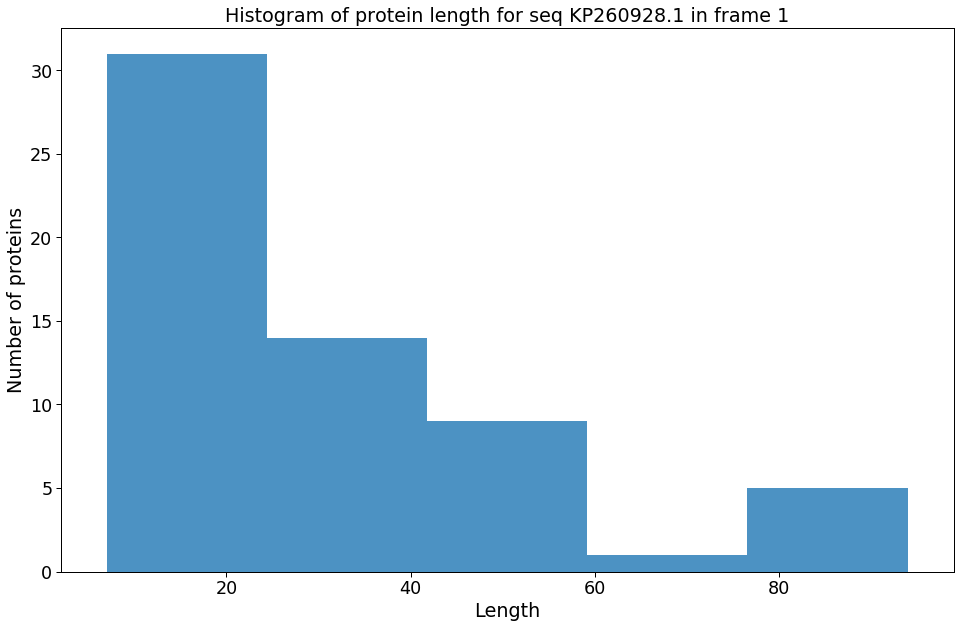


Current frame is  2
It has been found 86 proteins
There were 56 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	16
3	9
4	6
5	8
6	4
7	4
8	2
9	0
10	3
11	0
12	0
13	1
14	0
15	1
16	1
17	0



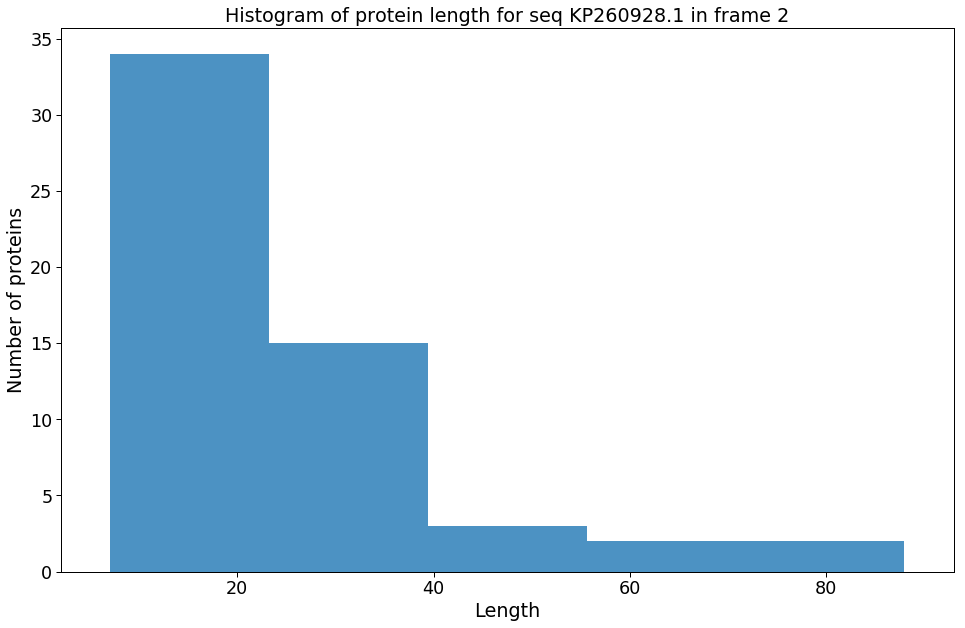


Current frame is  3
It has been found 108 proteins
There were 67 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	12
3	10
4	12
5	5
6	6
7	4
8	4
9	5
10	1
11	3
12	0
13	1
14	0
15	2
16	1
17	0
18	0
19	0



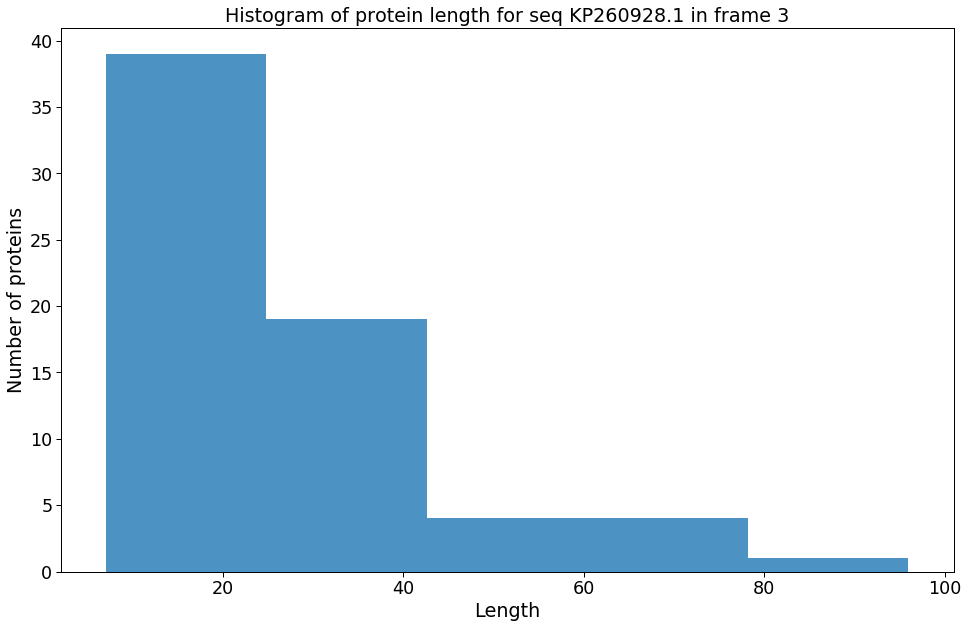


Current frame is  4
It has been found 99 proteins
There were 74 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	19
3	24
4	9
5	7
6	5
7	2
8	2
9	2
10	0
11	0
12	1
13	0
14	0
15	0
16	1
17	0
18	1
19	0



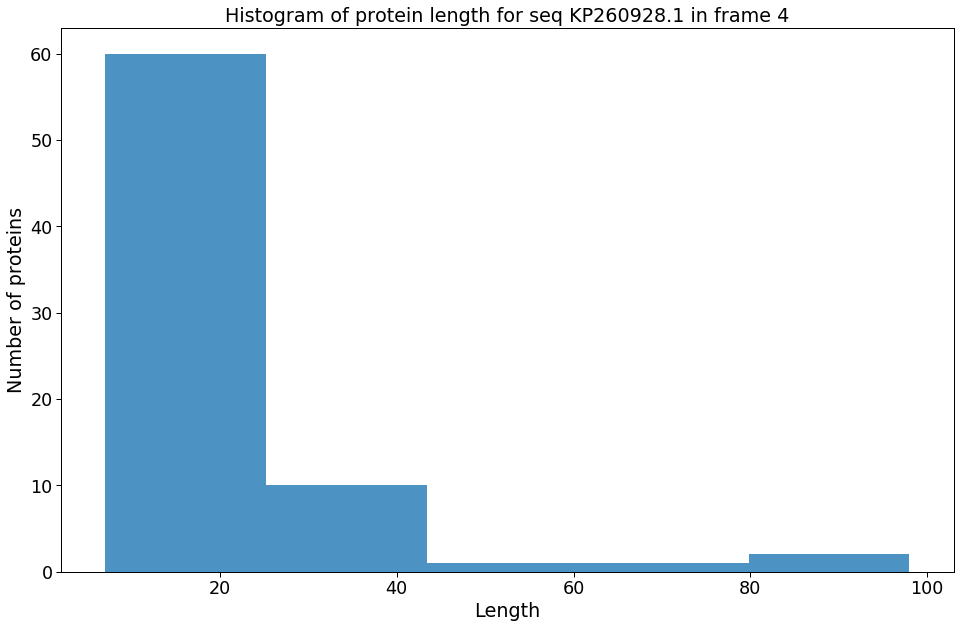


Current frame is  5
It has been found 91 proteins
There were 64 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	12
4	16
5	4
6	4
7	1
8	4
9	5
10	2
11	1
12	1
13	0
14	2
15	0



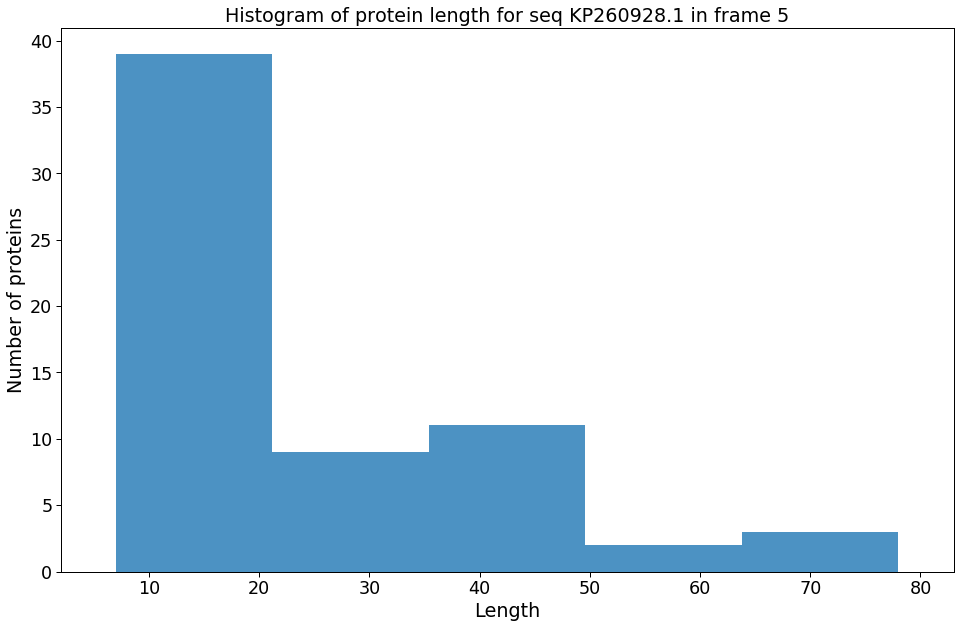


Codone composition of the seq:
UUU 262
UUC 143
UUA 254
UUG 157
UCU 159
UCC 120
UCA 160
UCG 53
UAU 211
UAC 114
UAA 0
UAG 0
UGU 130
UGC 73
UGA 0
UGG 111
CUU 183
CUC 138
CUA 170
CUG 87
CCU 147
CCC 182
CCA 126
CCG 60
CAU 173
CAC 92
CAA 166
CAG 115
CGU 66
CGC 50
CGA 58
CGG 83
AUU 332
AUC 124
AUA 289
AUG 543
ACU 154
ACC 124
ACA 159
ACG 40
AAU 263
AAC 126
AAA 270
AAG 230
AGU 161
AGC 100
AGA 143
AGG 237
GUU 172
GUC 78
GUA 143
GUG 87
GCU 154
GCC 145
GCA 121
GCG 61
GAU 121
GAC 78
GAA 155
GAG 141
GGU 102
GGC 87
GGA 141
GGG 158

Done
Seq name is  KP260929.1

Basic information about the sequence  KP260929.1

Nucleotide composition:
G 2699
C 4741
T 5526
A 5009

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 73 proteins
There were 53 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	10
4	7
5	4
6	5
7	4
8	3
9	4
10	0
11	1
12	1
13	1
14	0
15	0
16	0
17	1
18	0



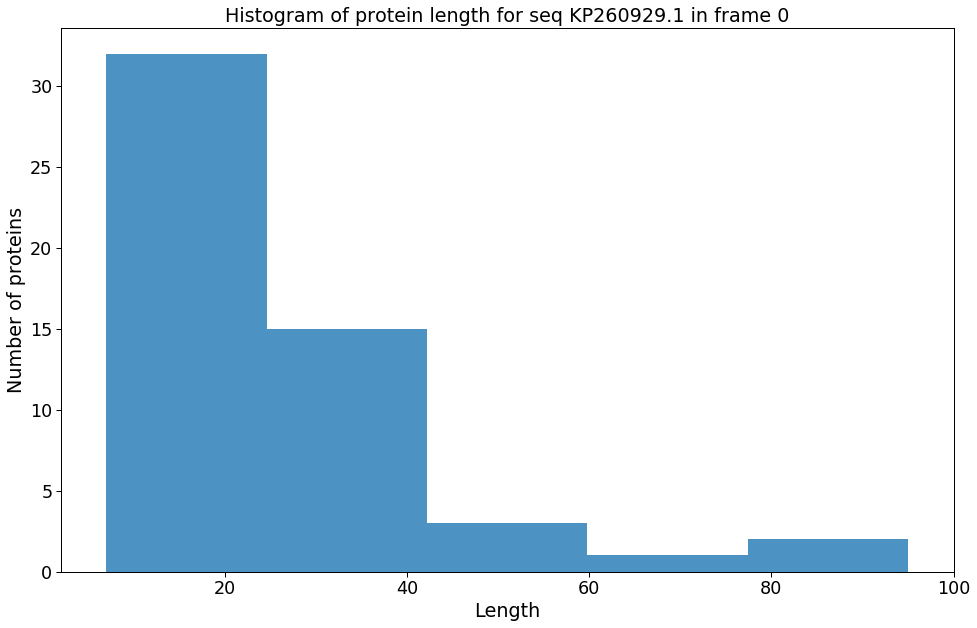


Current frame is  1
It has been found 86 proteins
There were 55 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	5
3	10
4	12
5	3
6	7
7	4
8	1
9	2
10	2
11	2
12	1
13	0
14	0
15	1
16	0
17	2
18	2



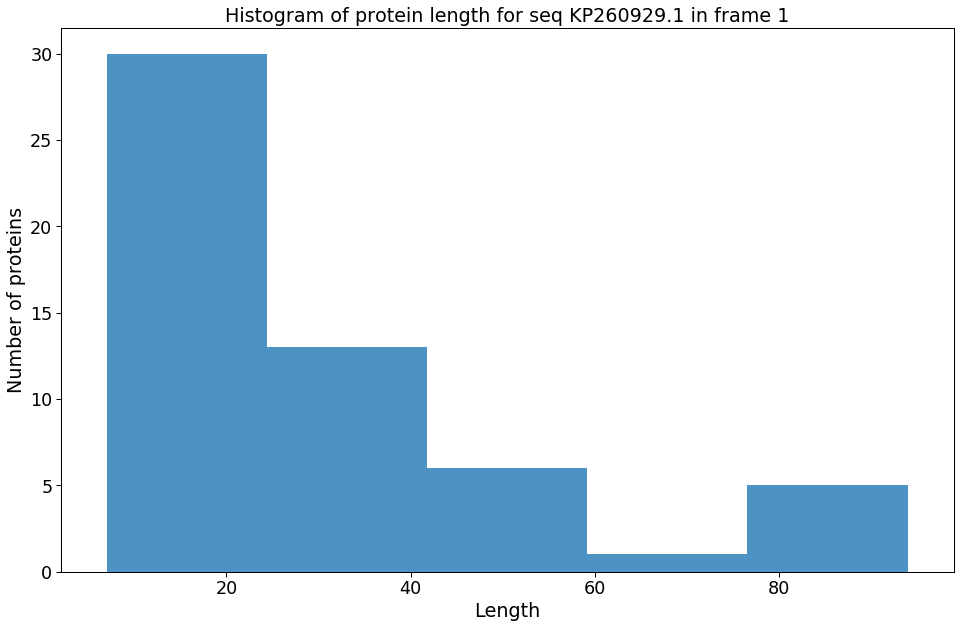


Current frame is  2
It has been found 105 proteins
There were 66 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	17
3	10
4	7
5	8
6	6
7	6
8	3
9	1
10	3
11	0
12	0
13	0
14	0
15	1
16	1
17	2



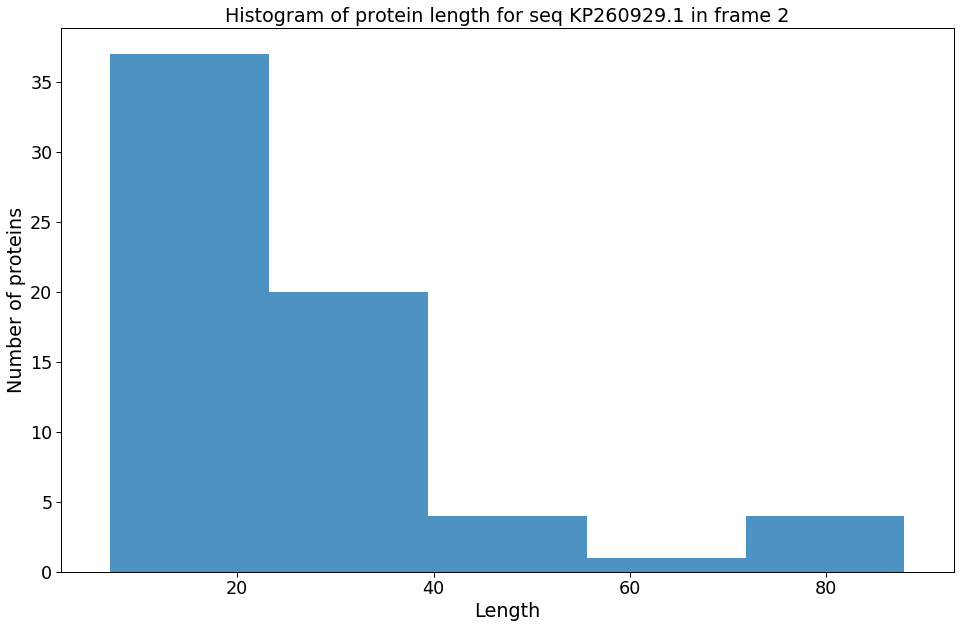


Current frame is  3
It has been found 96 proteins
There were 65 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	17
4	14
5	3
6	5
7	1
8	6
9	3
10	2
11	1
12	1
13	0



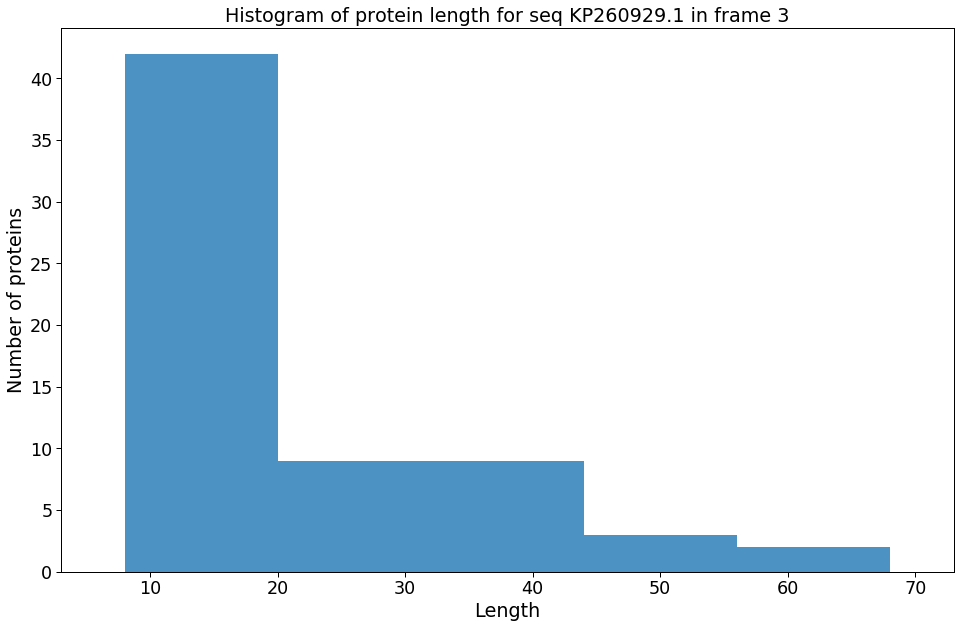


Current frame is  4
It has been found 108 proteins
There were 69 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	10
4	10
5	6
6	10
7	4
8	4
9	5
10	1
11	2
12	1
13	1
14	0
15	2
16	1
17	0
18	0
19	0



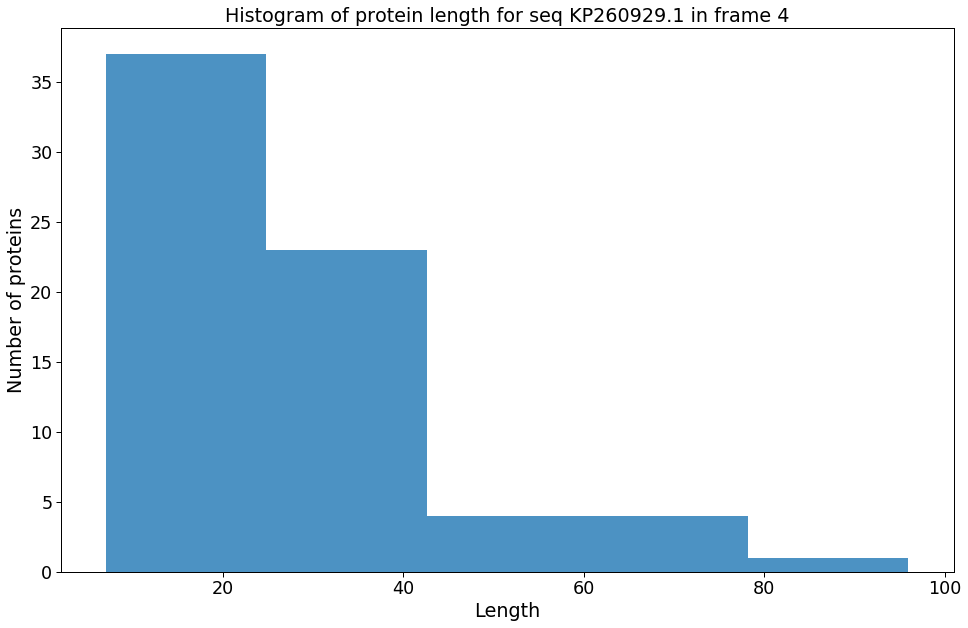


Current frame is  5
It has been found 102 proteins
There were 73 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	14
3	24
4	13
5	6
6	4
7	3
8	3
9	2
10	0
11	1
12	0
13	0
14	0
15	0
16	0
17	0
18	2
19	0



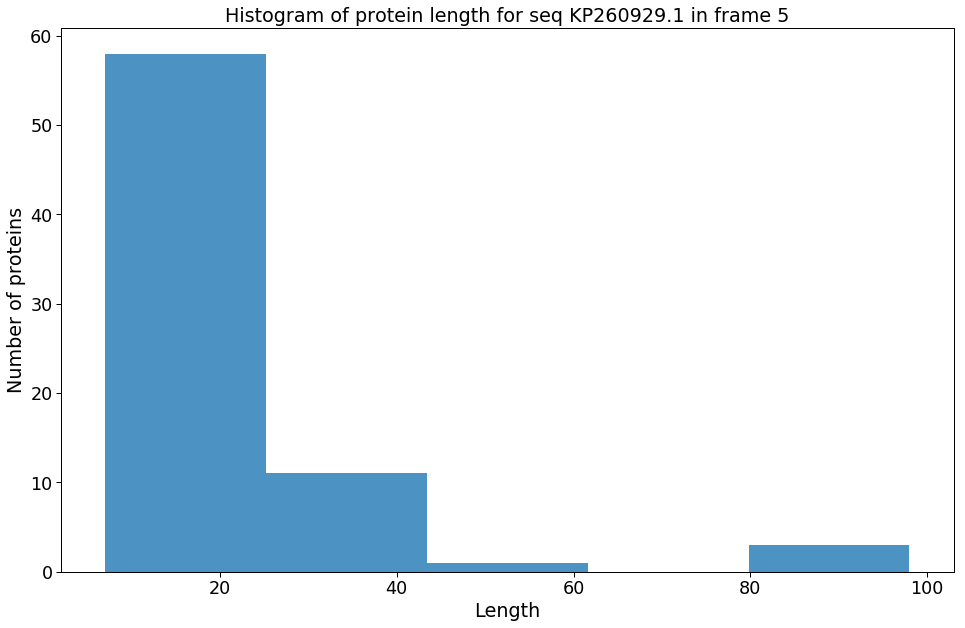


Codone composition of the seq:
UUU 535
UUC 286
UUA 517
UUG 319
UCU 326
UCC 241
UCA 322
UCG 109
UAU 431
UAC 232
UAA 0
UAG 0
UGU 263
UGC 141
UGA 0
UGG 235
CUU 363
CUC 287
CUA 352
CUG 171
CCU 292
CCC 365
CCA 241
CCG 122
CAU 331
CAC 182
CAA 336
CAG 222
CGU 130
CGC 97
CGA 123
CGG 162
AUU 667
AUC 251
AUA 583
AUG 1116
ACU 305
ACC 255
ACA 318
ACG 81
AAU 510
AAC 254
AAA 549
AAG 449
AGU 333
AGC 196
AGA 292
AGG 478
GUU 334
GUC 163
GUA 282
GUG 187
GCU 306
GCC 296
GCA 252
GCG 121
GAU 231
GAC 164
GAA 306
GAG 282
GGU 219
GGC 176
GGA 282
GGG 325

Done
Seq name is  KP260930.1

Basic information about the sequence  KP260930.1

Nucleotide composition:
G 2737
C 4804
T 5408
A 5038

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 65 proteins
There were 53 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	11
4	9
5	4
6	4
7	5
8	2
9	3
10	0
11	1
12	1
13	1
14	0
15	0
16	0



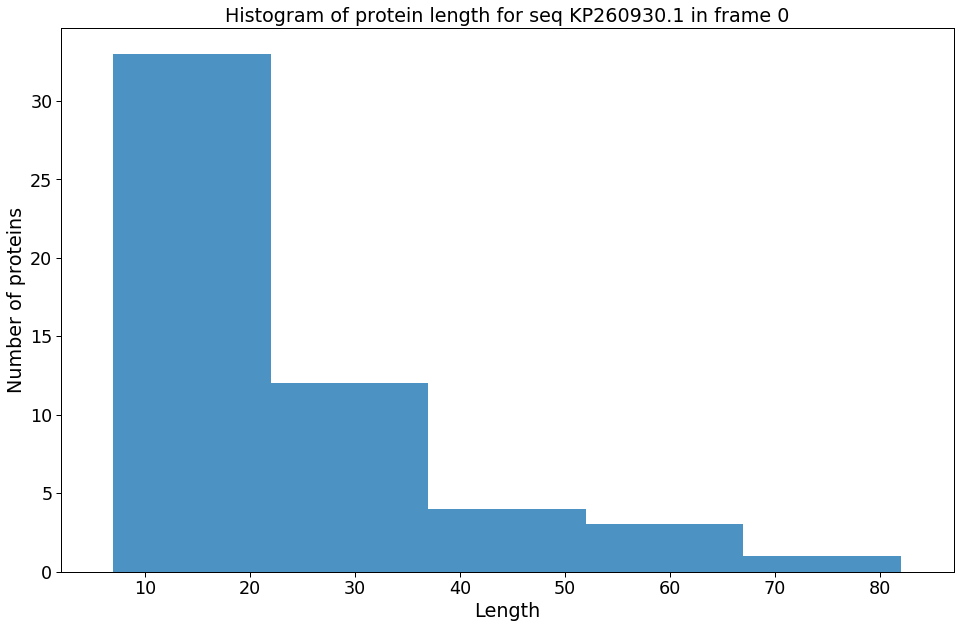


Current frame is  1
It has been found 73 proteins
There were 50 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	5
3	8
4	13
5	2
6	5
7	3
8	1
9	2
10	2
11	1
12	1
13	0
14	0
15	1
16	1
17	1
18	1
19	1



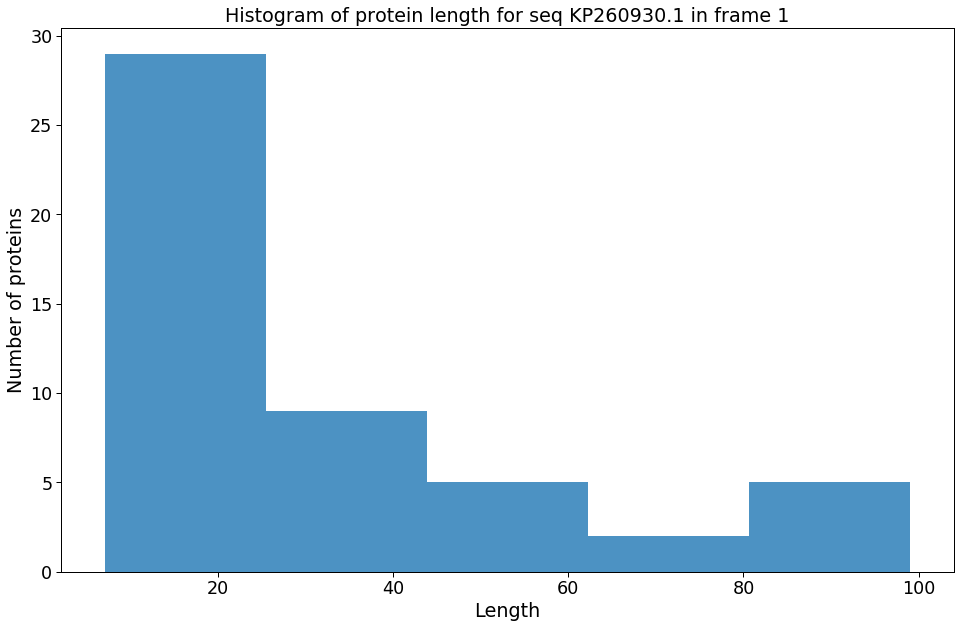


Current frame is  2
It has been found 89 proteins
There were 61 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	12
3	10
4	9
5	8
6	3
7	6
8	3
9	1
10	3
11	1
12	0
13	0
14	1
15	1
16	1
17	1



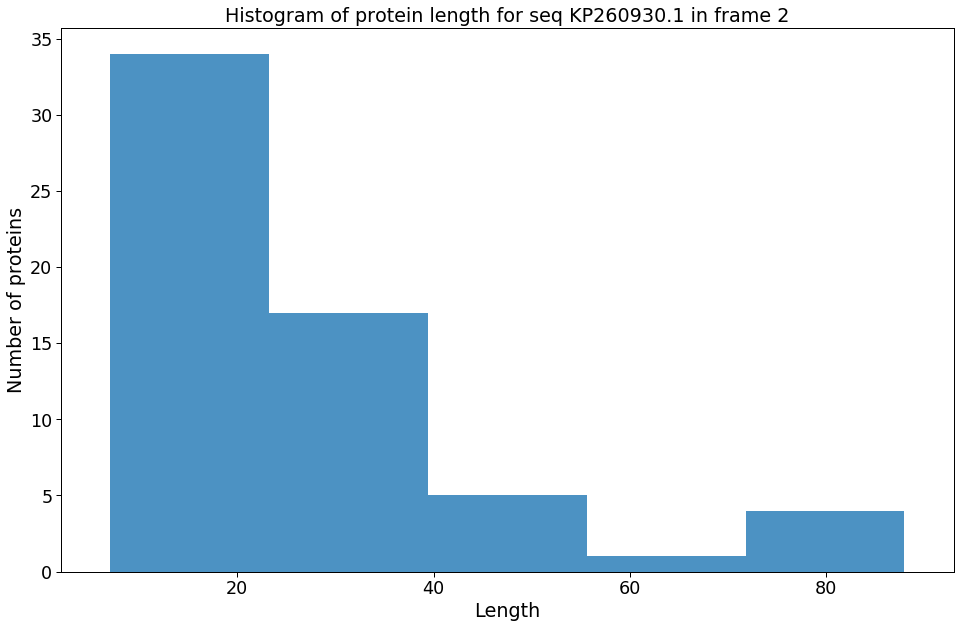


Current frame is  3
It has been found 93 proteins
There were 66 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	15
4	12
5	5
6	5
7	1
8	4
9	3
10	2
11	2
12	1
13	0
14	2
15	0
16	1
17	0
18	1
19	0



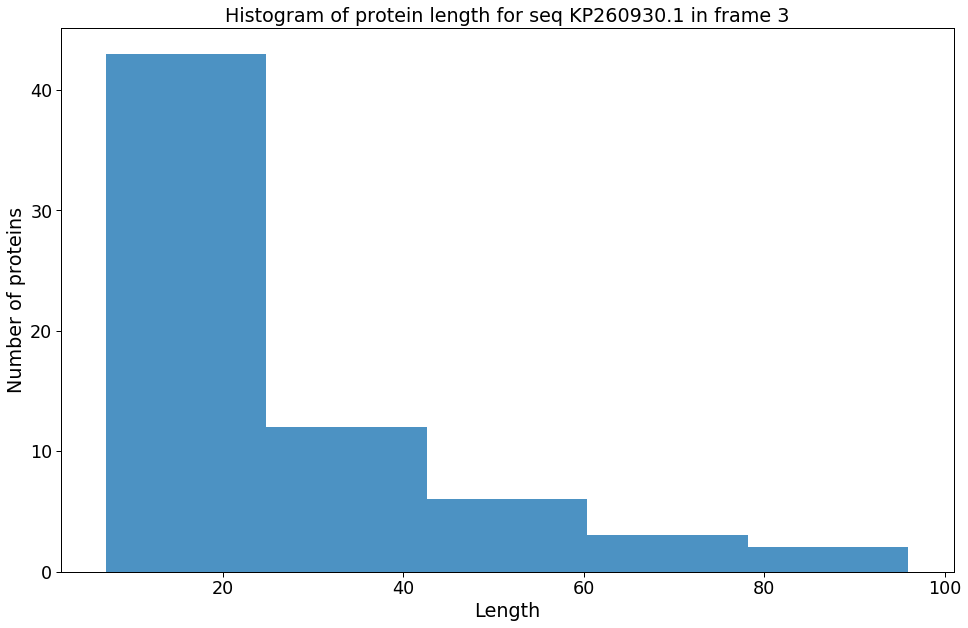


Current frame is  4
It has been found 107 proteins
There were 71 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	10
4	12
5	6
6	9
7	3
8	4
9	5
10	2
11	2
12	2
13	1
14	0
15	2
16	1
17	0
18	0
19	0



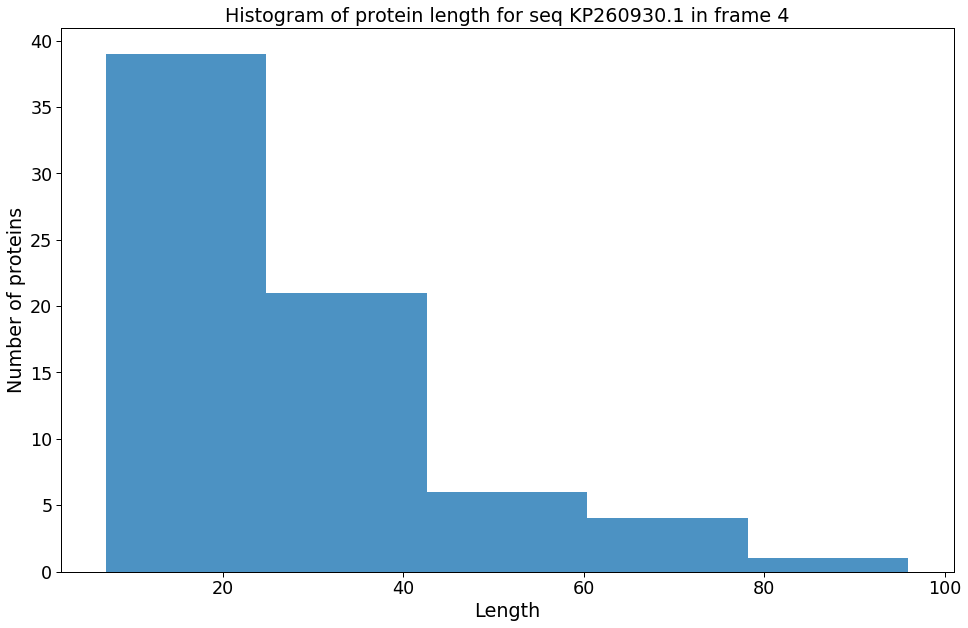


Current frame is  5
It has been found 163 proteins
There were 74 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	15
3	21
4	14
5	5
6	4
7	3
8	1
9	4
10	1
11	1
12	0
13	0
14	1
15	0
16	0
17	0
18	3
19	0



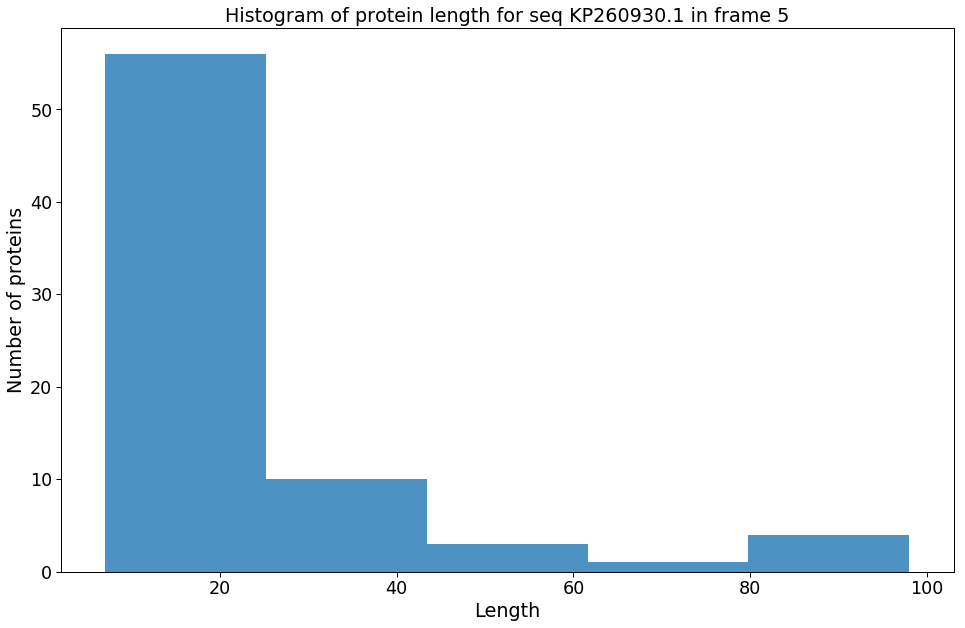


Codone composition of the seq:
UUU 808
UUC 429
UUA 769
UUG 488
UCU 497
UCC 373
UCA 485
UCG 168
UAU 643
UAC 348
UAA 0
UAG 0
UGU 405
UGC 222
UGA 0
UGG 374
CUU 554
CUC 423
CUA 524
CUG 273
CCU 455
CCC 555
CCA 363
CCG 191
CAU 509
CAC 274
CAA 500
CAG 337
CGU 198
CGC 148
CGA 194
CGG 250
AUU 1002
AUC 369
AUA 897
AUG 1675
ACU 442
ACC 380
ACA 461
ACG 120
AAU 781
AAC 388
AAA 838
AAG 688
AGU 493
AGC 307
AGA 443
AGG 723
GUU 521
GUC 255
GUA 438
GUG 297
GCU 471
GCC 438
GCA 396
GCG 197
GAU 349
GAC 253
GAA 465
GAG 433
GGU 343
GGC 270
GGA 430
GGG 531

Done
Seq name is  KP260931.1

Basic information about the sequence  KP260931.1

Nucleotide composition:
G 2694
C 4785
T 5430
A 5081

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 62 proteins
There were 50 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	12
3	10
4	7
5	4
6	3
7	5
8	1
9	3
10	0
11	1
12	1
13	1
14	0
15	0
16	0
17	1
18	0



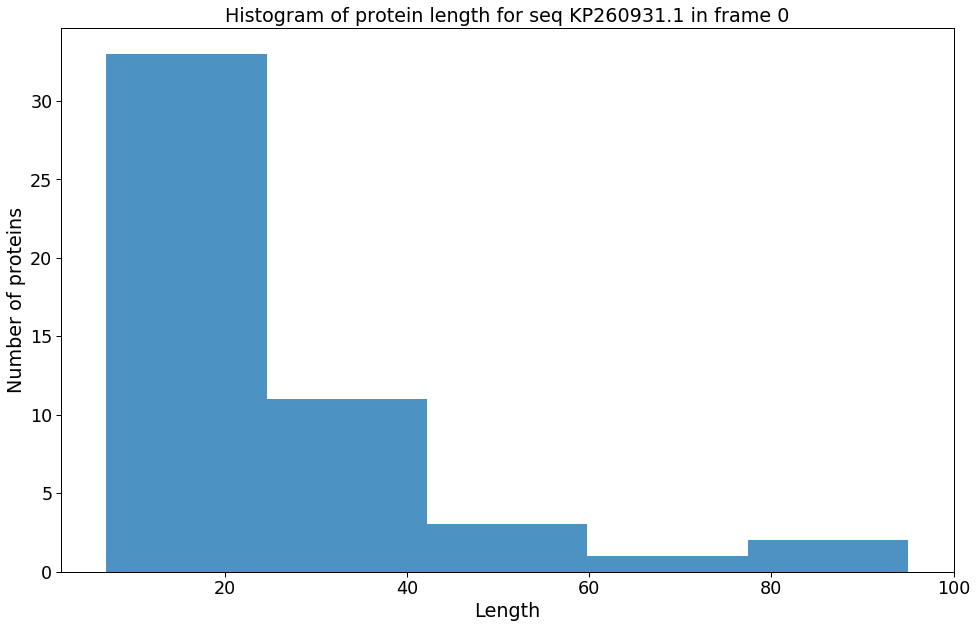


Current frame is  1
It has been found 73 proteins
There were 48 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	4
3	8
4	13
5	2
6	5
7	3
8	0
9	2
10	3
11	1
12	1
13	0
14	0
15	1
16	1
17	1
18	1
19	1



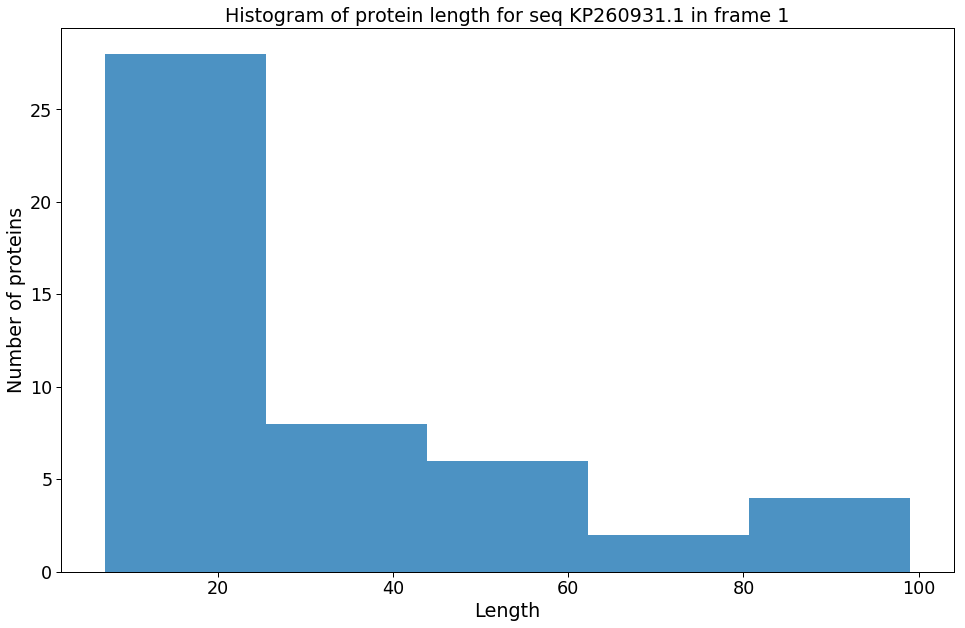


Current frame is  2
It has been found 88 proteins
There were 61 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	15
3	11
4	6
5	8
6	4
7	6
8	2
9	1
10	2
11	1
12	0
13	0
14	1
15	1
16	1
17	1



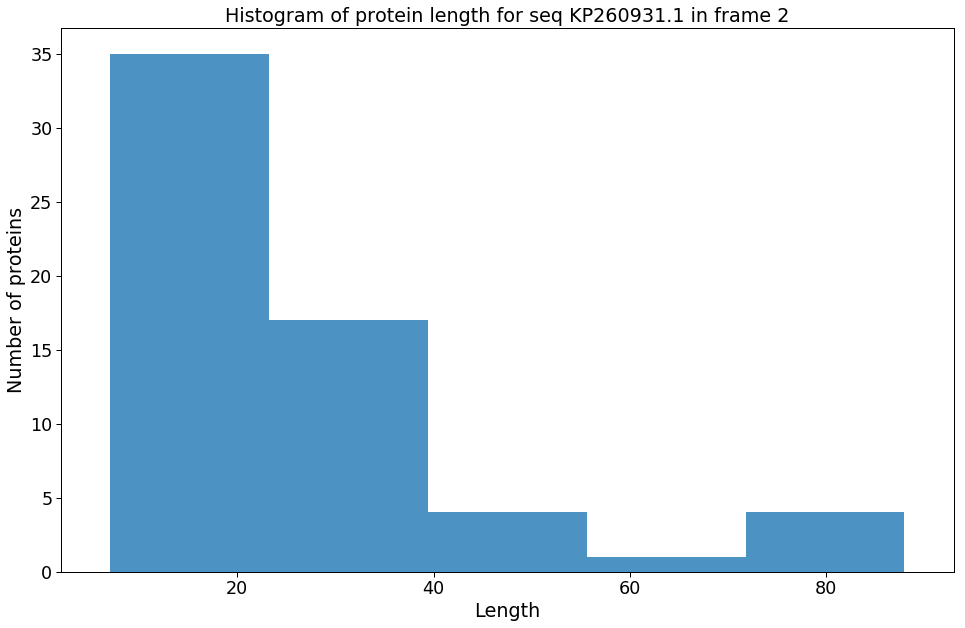


Current frame is  3
It has been found 90 proteins
There were 64 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	14
4	13
5	4
6	4
7	1
8	5
9	3
10	2
11	2
12	1
13	0
14	2
15	0
16	1
17	0
18	0
19	0



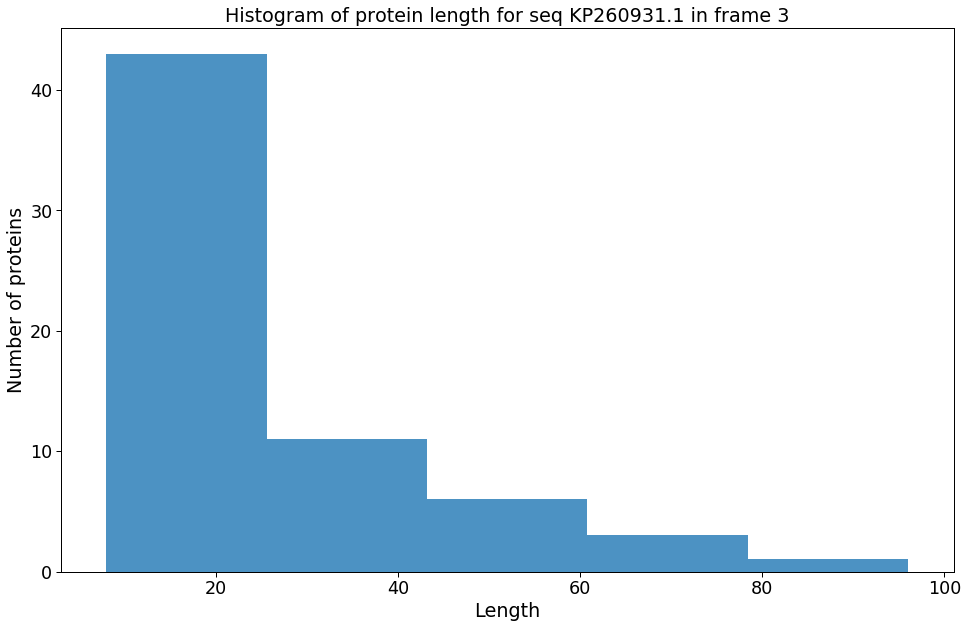


Current frame is  4
It has been found 101 proteins
There were 66 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	9
3	10
4	10
5	5
6	9
7	4
8	5
9	5
10	2
11	3
12	2
13	0
14	0



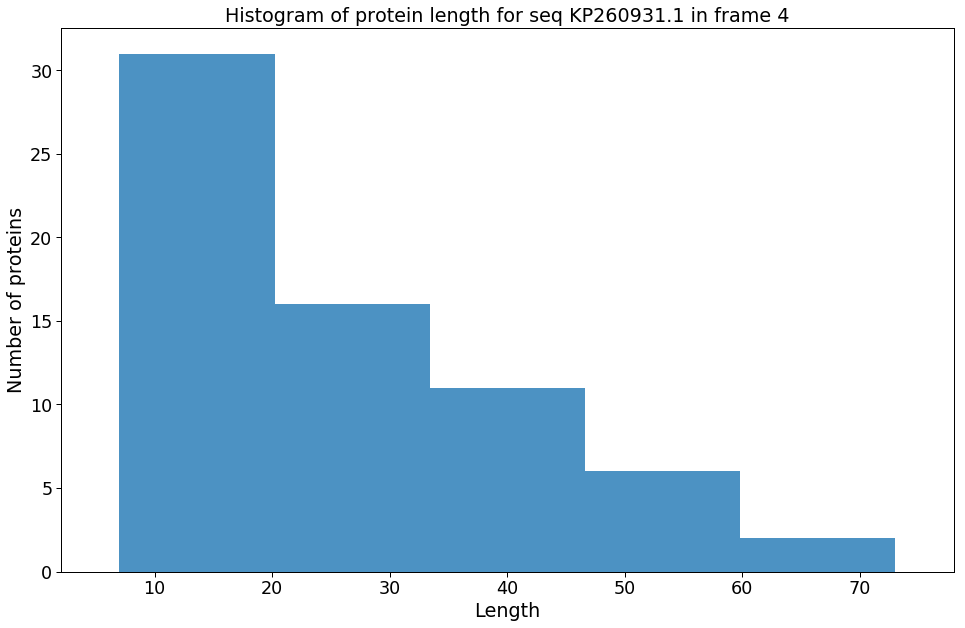


Current frame is  5
It has been found 161 proteins
There were 74 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	16
3	21
4	14
5	6
6	4
7	3
8	2
9	2
10	0
11	1
12	1
13	0
14	0
15	0
16	0
17	0
18	3
19	0



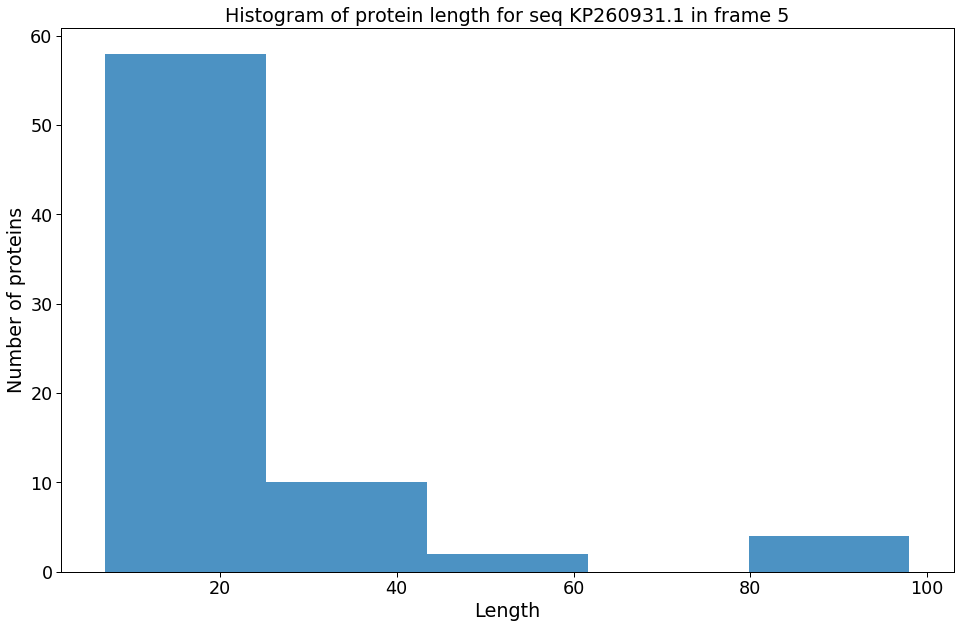


Codone composition of the seq:
UUU 1067
UUC 563
UUA 1024
UUG 637
UCU 650
UCC 499
UCA 637
UCG 233
UAU 851
UAC 455
UAA 0
UAG 0
UGU 537
UGC 312
UGA 0
UGG 496
CUU 739
CUC 553
CUA 680
CUG 362
CCU 606
CCC 731
CCA 482
CCG 253
CAU 681
CAC 367
CAA 660
CAG 432
CGU 266
CGC 199
CGA 257
CGG 328
AUU 1325
AUC 479
AUA 1180
AUG 2203
ACU 578
ACC 484
ACA 607
ACG 158
AAU 1047
AAC 510
AAA 1116
AAG 916
AGU 649
AGC 413
AGA 595
AGG 945
GUU 685
GUC 344
GUA 575
GUG 406
GCU 621
GCC 590
GCA 522
GCG 271
GAU 461
GAC 343
GAA 617
GAG 578
GGU 457
GGC 356
GGA 558
GGG 721

Done
Seq name is  KP260932.1

Basic information about the sequence  KP260932.1

Nucleotide composition:
G 2704
C 4801
T 5448
A 5015

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 97 proteins
There were 73 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	29
4	6
5	4
6	8
7	5
8	1
9	2
10	2
11	0
12	0
13	1
14	0
15	1
16	1
17	1



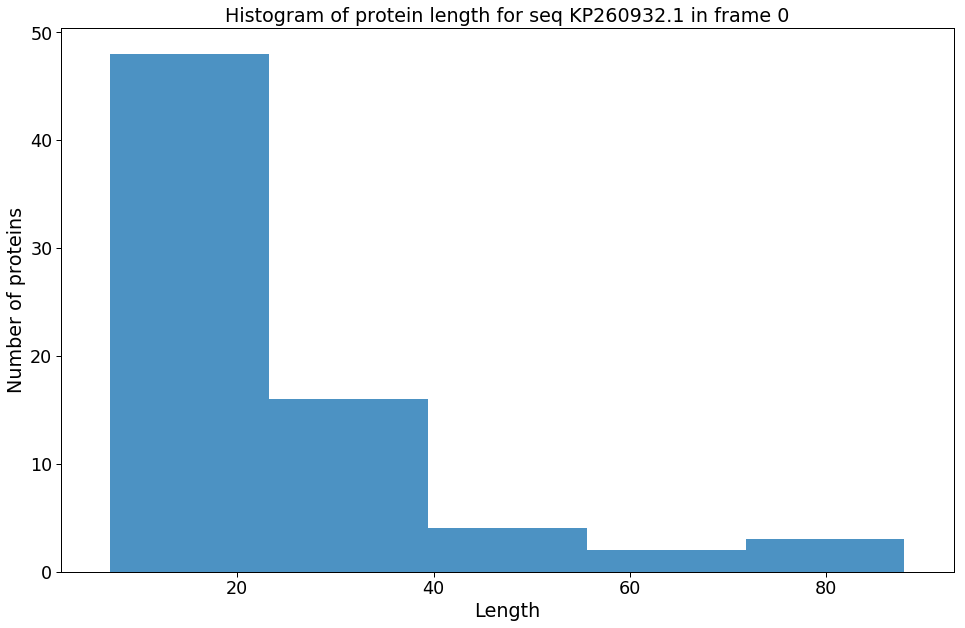


Current frame is  1
It has been found 93 proteins
There were 74 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	8
3	35
4	10
5	3
6	4
7	5
8	4
9	2
10	0
11	2
12	0



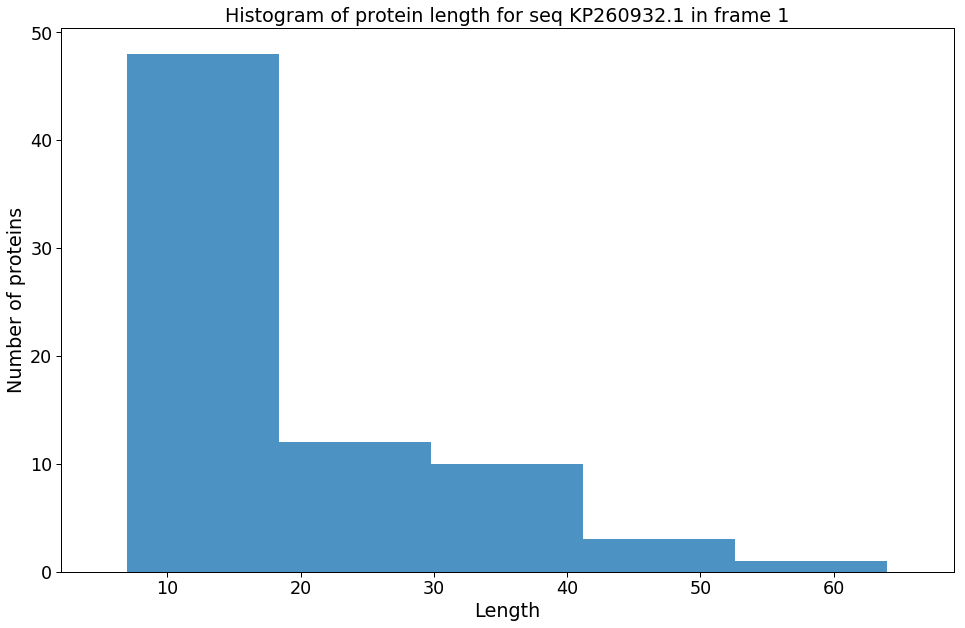


Current frame is  2
It has been found 101 proteins
There were 78 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	6
3	31
4	7
5	6
6	7
7	5
8	2
9	3
10	3
11	0
12	1
13	0
14	1
15	1
16	1
17	1
18	1
19	0



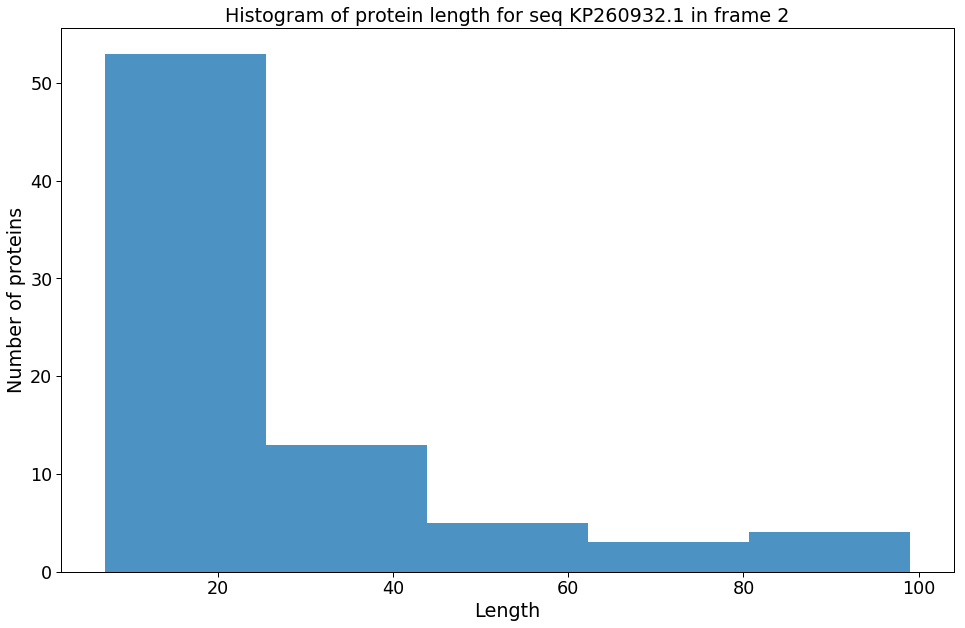


Current frame is  3
It has been found 112 proteins
There were 77 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	25
4	11
5	6
6	7
7	5
8	4
9	2
10	0
11	1
12	0
13	1
14	0
15	0
16	0
17	1
18	1
19	1



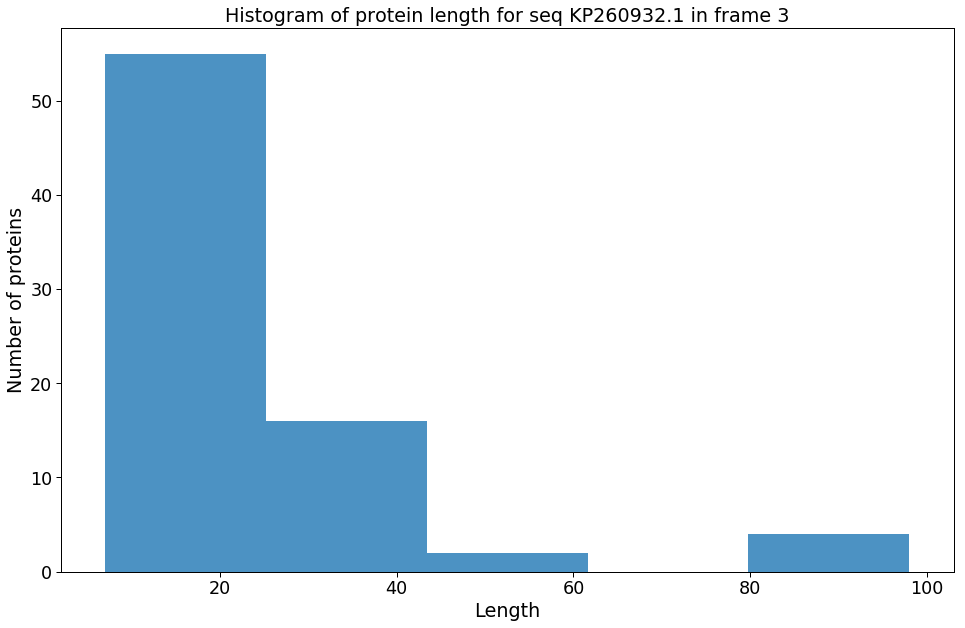


Current frame is  4
It has been found 91 proteins
There were 62 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	14
3	10
4	14
5	3
6	3
7	2
8	1
9	3
10	3
11	1
12	2
13	0
14	2
15	2
16	1
17	0
18	0
19	0



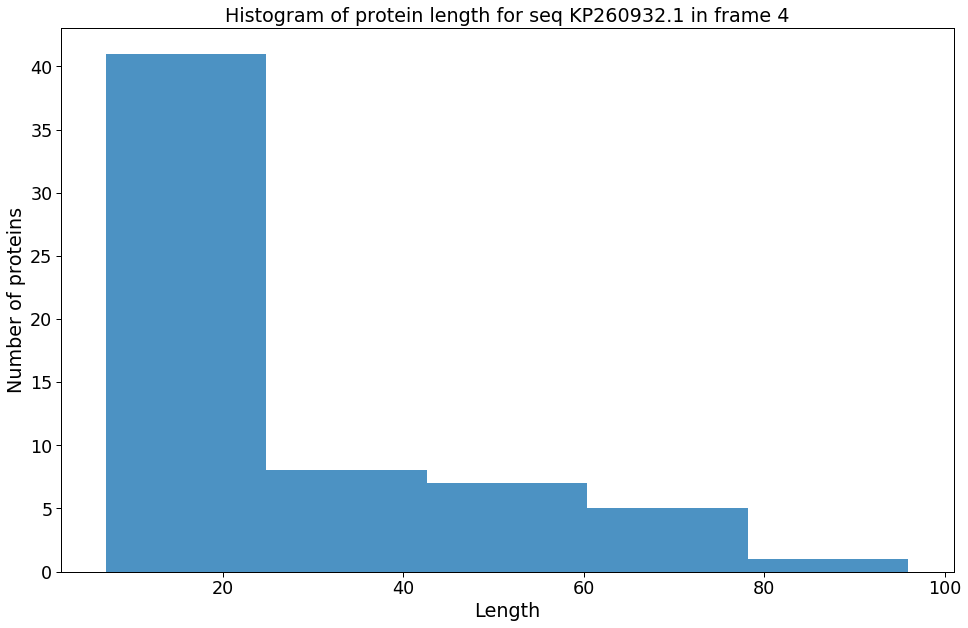


Current frame is  5
It has been found 96 proteins
There were 65 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	6
3	14
4	11
5	2
6	11
7	4
8	6
9	3
10	0
11	4
12	0
13	1
14	0



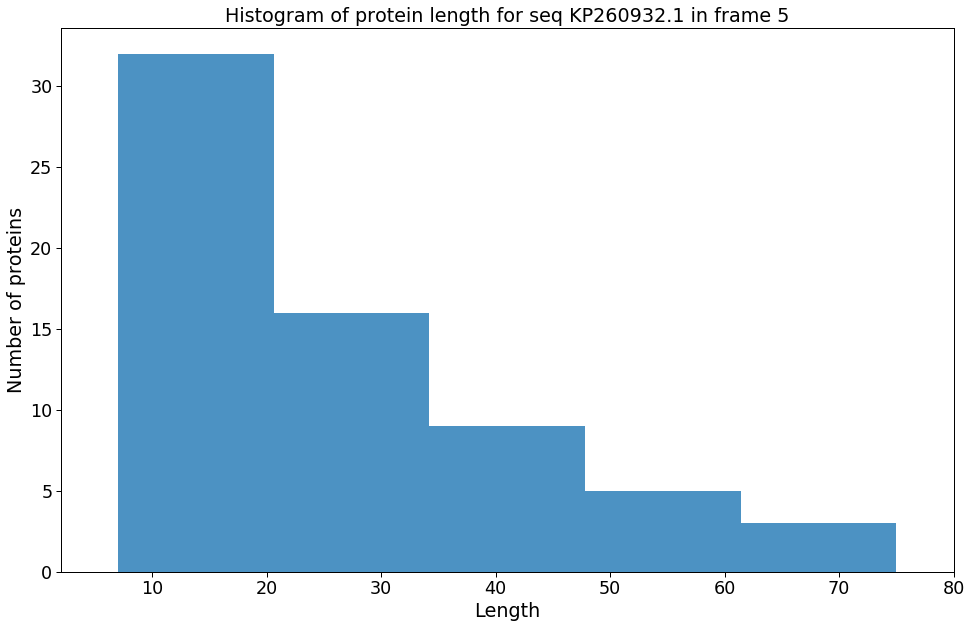


Codone composition of the seq:
UUU 1325
UUC 695
UUA 1264
UUG 784
UCU 805
UCC 616
UCA 785
UCG 300
UAU 1265
UAC 652
UAA 0
UAG 0
UGU 667
UGC 391
UGA 0
UGG 622
CUU 912
CUC 671
CUA 988
CUG 450
CCU 753
CCC 927
CCA 617
CCG 335
CAU 856
CAC 456
CAA 806
CAG 533
CGU 334
CGC 253
CGA 320
CGG 429
AUU 1655
AUC 691
AUA 1503
AUG 2790
ACU 737
ACC 676
ACA 735
ACG 201
AAU 1298
AAC 641
AAA 1391
AAG 1129
AGU 892
AGC 518
AGA 737
AGG 1219
GUU 860
GUC 438
GUA 725
GUG 514
GCU 756
GCC 724
GCA 688
GCG 318
GAU 595
GAC 413
GAA 776
GAG 795
GGU 554
GGC 437
GGA 689
GGG 917

Done
Seq name is  KP260933.1

Basic information about the sequence  KP260933.1

Nucleotide composition:
G 2711
C 4754
T 5488
A 4986

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 68 proteins
There were 53 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	10
3	14
4	6
5	4
6	3
7	6
8	3
9	1
10	0
11	1
12	1
13	1
14	0
15	0
16	1
17	1
18	0



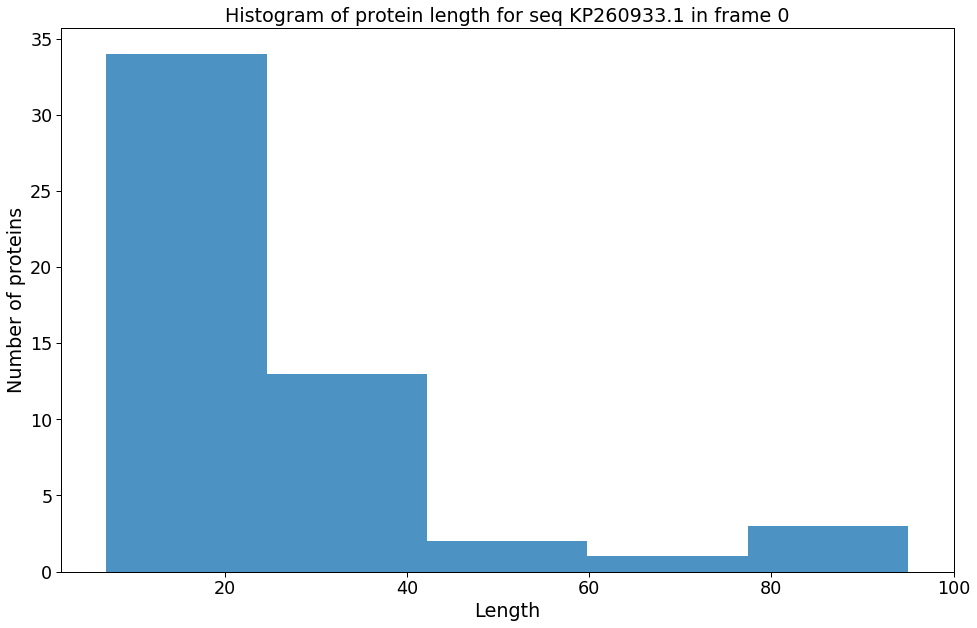


Current frame is  1
It has been found 79 proteins
There were 53 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	6
3	9
4	11
5	2
6	7
7	3
8	0
9	2
10	3
11	1
12	1
13	0
14	0
15	1
16	1
17	2
18	2
19	1



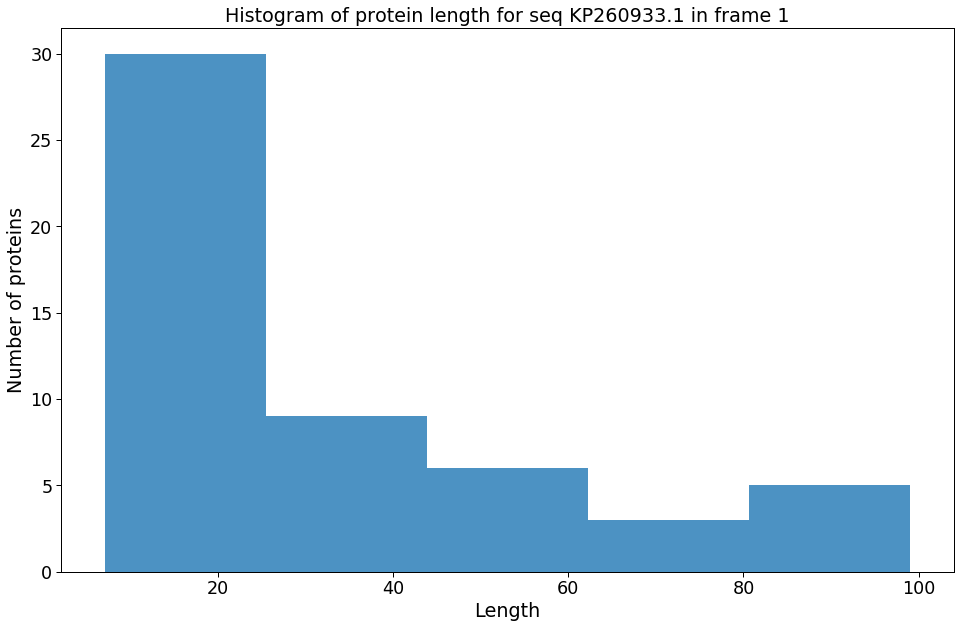


Current frame is  2
It has been found 82 proteins
There were 57 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	13
3	9
4	9
5	10
6	3
7	7
8	1
9	1
10	0
11	1
12	0
13	0
14	1
15	1
16	0
17	0



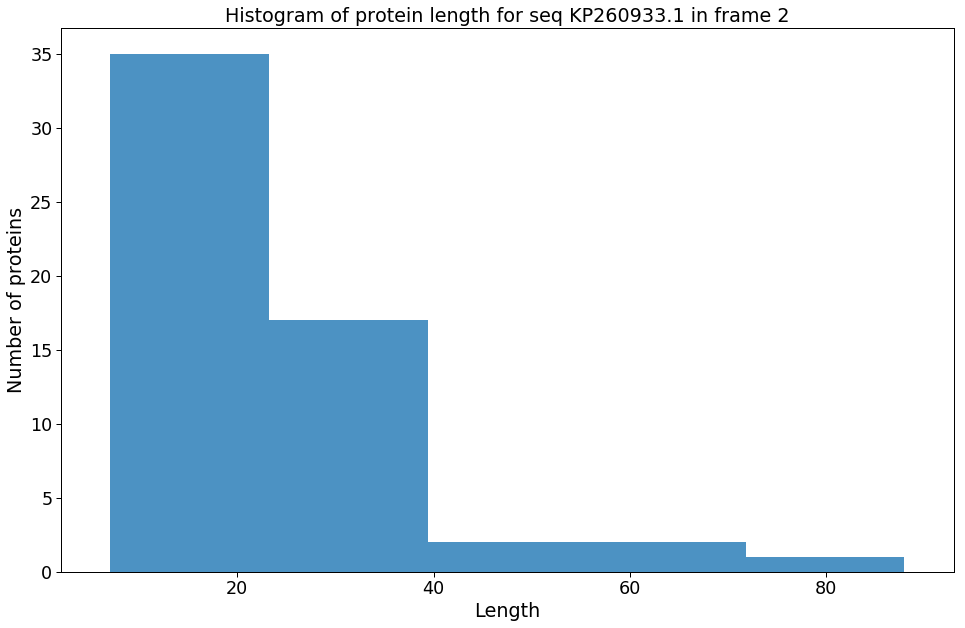


Current frame is  3
It has been found 89 proteins
There were 65 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	12
3	13
4	13
5	5
6	4
7	1
8	4
9	3
10	3
11	2
12	0
13	1
14	1
15	1
16	1
17	0
18	0
19	0



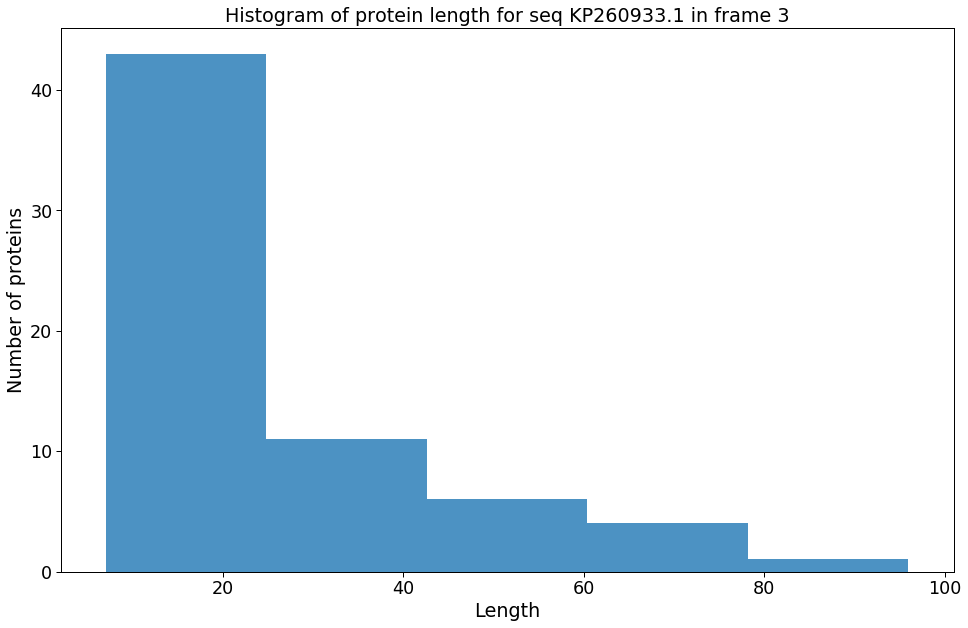


Current frame is  4
It has been found 104 proteins
There were 66 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	10
4	10
5	5
6	7
7	4
8	3
9	5
10	1
11	4
12	1
13	1
14	0
15	2
16	1
17	0
18	0
19	0



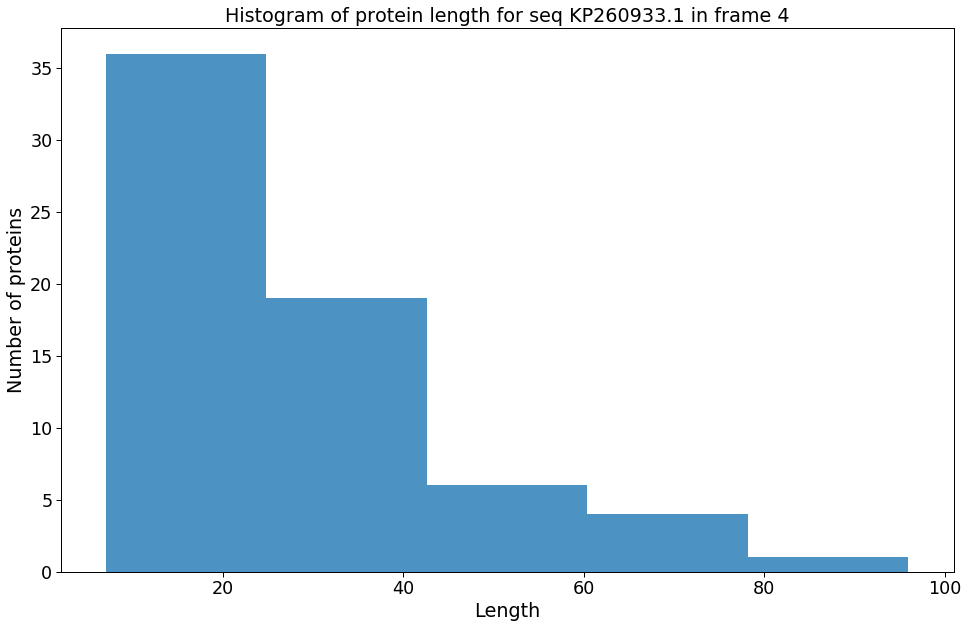


Current frame is  5
It has been found 105 proteins
There were 78 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	18
3	21
4	10
5	6
6	8
7	4
8	2
9	3
10	0
11	0
12	0
13	1
14	1
15	0
16	0
17	0
18	2
19	0



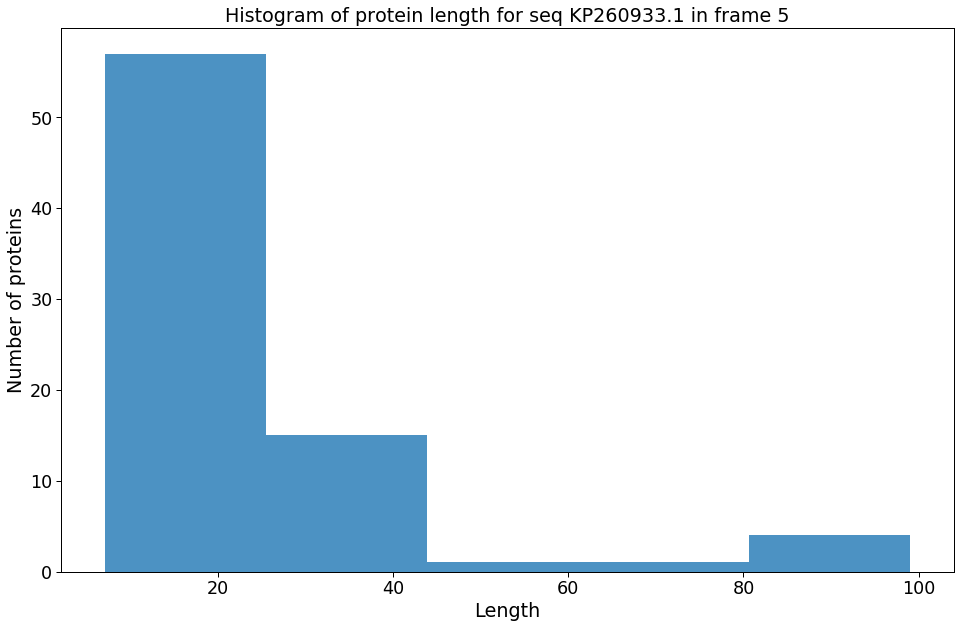


Codone composition of the seq:
UUU 1587
UUC 830
UUA 1529
UUG 926
UCU 985
UCC 738
UCA 939
UCG 349
UAU 1456
UAC 764
UAA 0
UAG 0
UGU 810
UGC 467
UGA 0
UGG 751
CUU 1100
CUC 806
CUA 1173
CUG 540
CCU 890
CCC 1105
CCA 743
CCG 410
CAU 1024
CAC 555
CAA 972
CAG 653
CGU 398
CGC 307
CGA 387
CGG 509
AUU 1984
AUC 829
AUA 1827
AUG 3333
ACU 892
ACC 794
ACA 888
ACG 246
AAU 1569
AAC 771
AAA 1665
AAG 1354
AGU 1057
AGC 632
AGA 898
AGG 1472
GUU 1042
GUC 530
GUA 875
GUG 618
GCU 917
GCC 871
GCA 839
GCG 394
GAU 728
GAC 485
GAA 935
GAG 933
GGU 673
GGC 510
GGA 838
GGG 1120

Done
Seq name is  KP260934.1

Basic information about the sequence  KP260934.1

Nucleotide composition:
G 2705
C 4744
T 5528
A 4955

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 79 proteins
There were 52 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	9
4	7
5	8
6	4
7	5
8	1
9	1
10	0
11	1
12	0
13	0
14	0
15	1
16	1
17	1



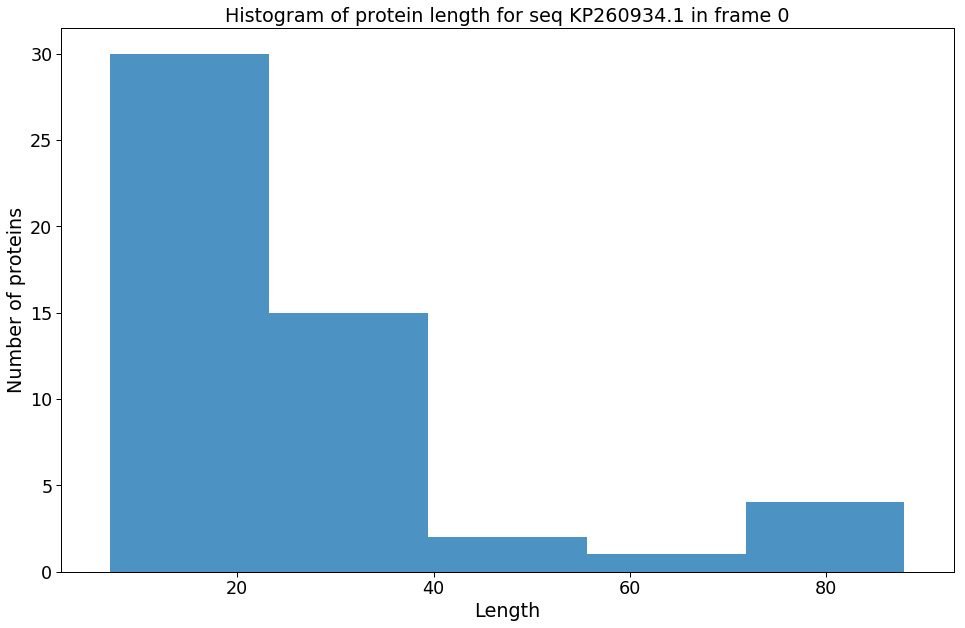


Current frame is  1
It has been found 69 proteins
There were 55 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	10
3	11
4	9
5	5
6	4
7	4
8	3
9	1
10	1
11	1
12	1
13	2
14	0
15	0
16	0
17	1
18	0
19	0



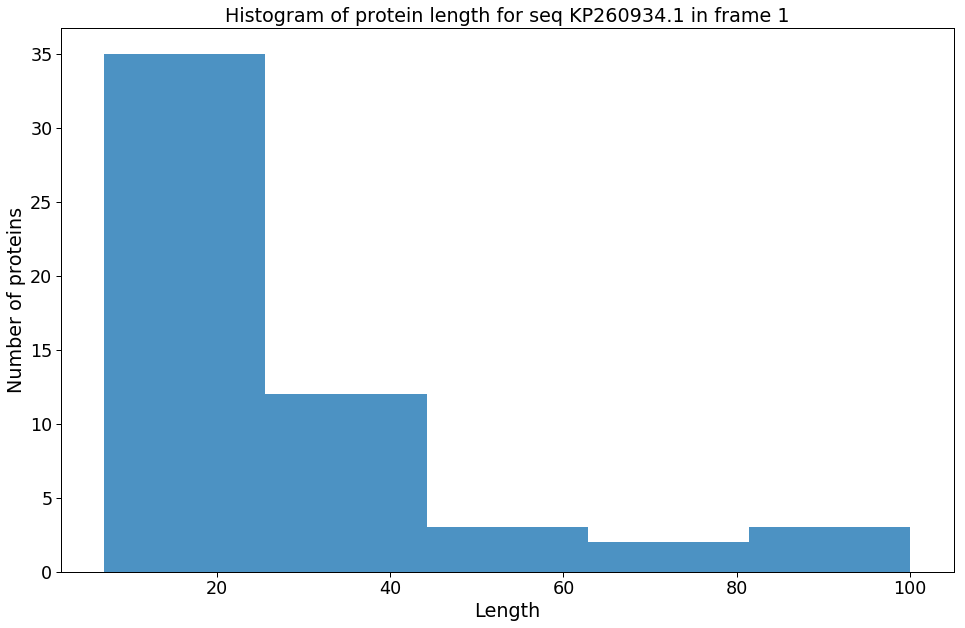


Current frame is  2
It has been found 86 proteins
There were 65 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	11
4	12
5	1
6	9
7	4
8	0
9	3
10	4
11	0
12	2
13	0
14	0
15	1
16	1
17	1
18	3
19	1



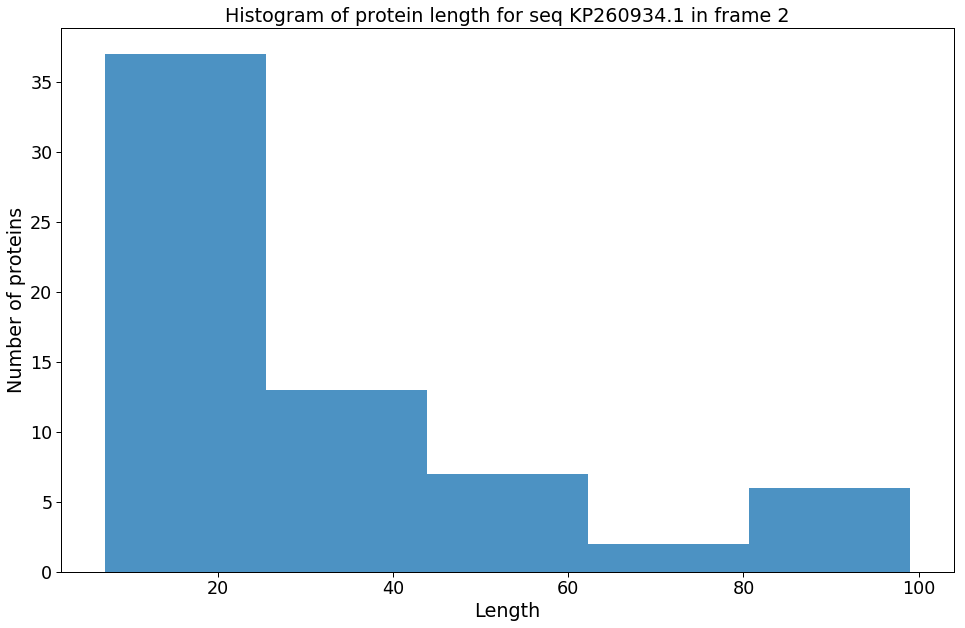


Current frame is  3
It has been found 113 proteins
There were 79 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	16
3	28
4	12
5	5
6	7
7	3
8	3
9	3
10	0
11	0
12	0
13	1
14	0
15	0
16	0
17	0
18	0
19	0



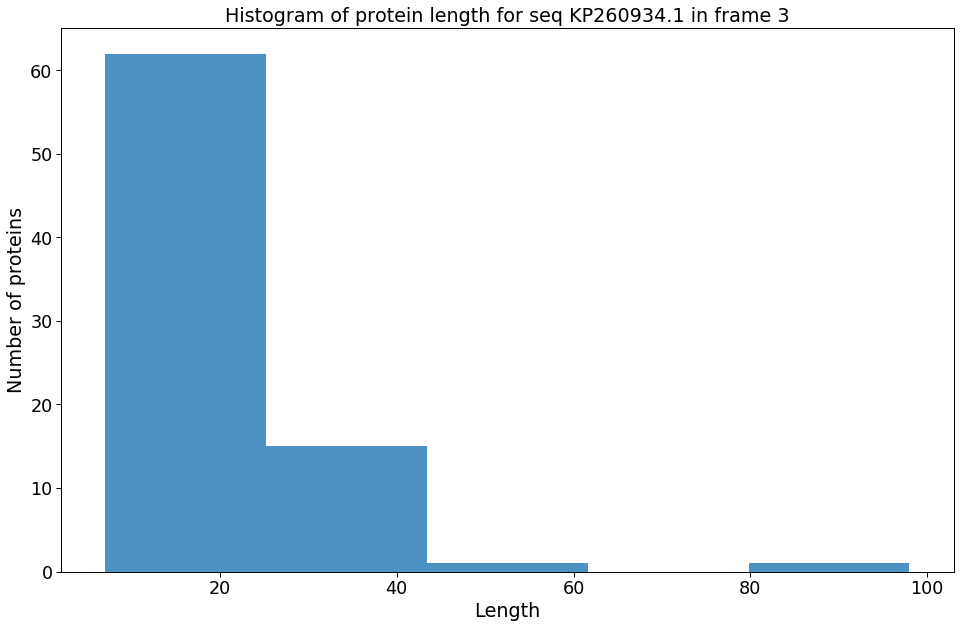


Current frame is  4
It has been found 94 proteins
There were 61 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	13
4	15
5	7
6	2
7	1
8	2
9	2
10	2
11	2
12	1
13	0
14	1
15	1
16	0
17	0
18	0
19	0



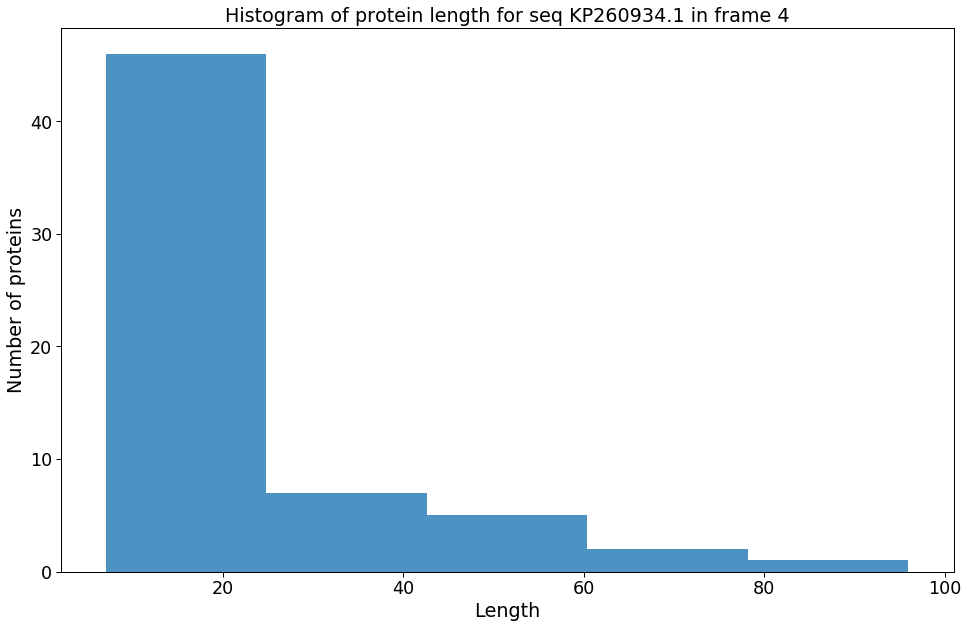


Current frame is  5
It has been found 108 proteins
There were 65 proteins with min length 7

Protein length by bins:
Bin size = 5
Bin	Score
1	0
2	11
3	12
4	10
5	5
6	8
7	4
8	4
9	4
10	1
11	2
12	0
13	1
14	0
15	1
16	1
17	0
18	0
19	0



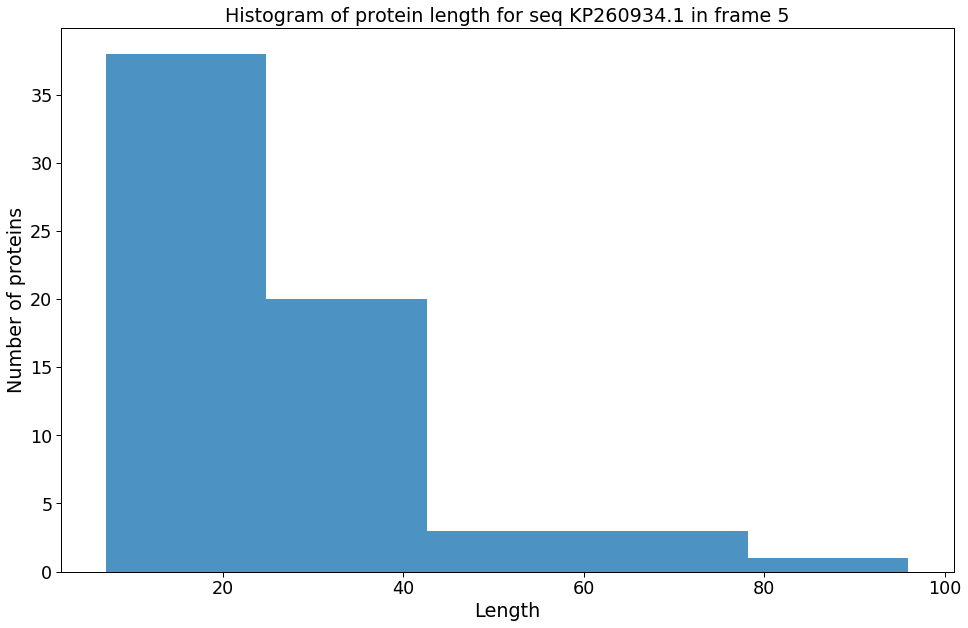


Codone composition of the seq:
UUU 1855
UUC 981
UUA 1781
UUG 1073
UCU 1150
UCC 861
UCA 1083
UCG 408
UAU 1652
UAC 865
UAA 0
UAG 0
UGU 946
UGC 539
UGA 0
UGG 873
CUU 1299
CUC 937
CUA 1362
CUG 630
CCU 1038
CCC 1298
CCA 873
CCG 497
CAU 1184
CAC 661
CAA 1130
CAG 757
CGU 450
CGC 368
CGA 458
CGG 593
AUU 2295
AUC 968
AUA 2135
AUG 3874
ACU 1042
ACC 916
ACA 1033
ACG 289
AAU 1814
AAC 906
AAA 1924
AAG 1555
AGU 1206
AGC 723
AGA 1049
AGG 1688
GUU 1216
GUC 621
GUA 1029
GUG 714
GCU 1073
GCC 1010
GCA 972
GCG 454
GAU 847
GAC 564
GAA 1090
GAG 1053
GGU 778
GGC 583
GGA 984
GGG 1300

Done


In [6]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# !!! Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху.

import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os


root = os.getcwd() # просто корень, где будем работать

        
print("Start script") # задаем стартовые параметры
try:
    file = str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")

minimal_len_prot = int(input("Type the minimal protein length "))
maximal_len_prot = int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
codone_log_button = str(input("Do you want to have a codon log file? [y]/[n] "))
hist = str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = int(input("Type the bin size for protein histogram "))

code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}


log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


@log_wrapper("protein_translator log")
def protein_translator(line_in, codone_log_button = "y", code_calc = code_calc):
    code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}

    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    line_out = []
    amino_info_collector = {}

    if len(line_in) % 3 == 0:
        for i in range(0, len(line_in), 3):

            codon = line_in[i:(i + 3)]
            if codon in code_calc.keys(): # считаем кодоны
                code_calc[codon] = int(code_calc[codon]) + 1

                
            if codon in code.keys(): # считаем аминокислоты, но другим способом
                ama = code[codon]
                line_out = line_out + list(ama)
                if ama in amino_info_collector.keys():
                    amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
                else:
                    amino_info_collector[ama] = 1

    if codone_log_button == "y": # пишем в файл то, что насчиталось
        out_stat_file.write(">" + "frame_" + str(i) + "_" + str(j) + "_stat" + "\n")
        for i in amino_info_collector.keys():
            out_stat_file.write(str(i) + "\t" + str(amino_info_collector[i]) + "\n")

    if len(line_in) % 3 != 0: # добавляем N, пока длина последовательности не будет кратна 3м 
        while len(line_in) % 3 != 0:
            line_in = line_in + "N"
            protein_translator(line_in)
    line_out = "".join(line_out)
    return line_out


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------


with open(file, "r") as in_file:
    seqs={}
    for line in in_file:
        line = line.rstrip()
        if len(line) > 0:
            if line[0] == ">":
                words = line.split()
                name = words[0][1:]
                seqs[name] = ''
            else:
                seqs[name] = seqs[name] + line



for record in seqs.keys():
    sequence = seqs[record]
    name = record
    print("Seq name is ", name)
    
    
    basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
    if not os.path.exists(basicdir): # если нет basicdir, то создаем
        os.makedirs(basicdir)
    os.chdir(basicdir) # заходим в неё
    # теперь работаем и сохраняем только в ней
        
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
    sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

    nuc_stat = nuc_stat_counter(sequence)

    print("")
    print("Basic information about the sequence ", name)
    print("")
    print("Nucleotide composition:")
    for s in nuc_stat.keys():
        print(str(s), nuc_stat[s])
    print("")
    
                
    orf_dict = {}
    for i in range(3):  # перебираем каждую из рамок на прямой цепи
        print("Iteration", i)
        frame = i
        orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
        orf_dict[i] = orfs
    
    for j in range(3): # и на обратной
        print("Iteration", -j)
        frame_rev = j
        orfs_rev = orf_finder(sequence_rev, frame_rev)
        orf_dict[j + 3] = orfs_rev

    
    # получили словари с ORFs
    out_protein_orf_name = "out_protein_orf_" + str(name.split(" ")[0]) + ".fasta"
    out_codon_stat_name = "out_codon_stat_" + str(name.split(" ")[0]) + ".fasta"
    with open(out_protein_orf_name, "w") as out_file:
        with open(out_codon_stat_name, "w") as out_stat_file:
            for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
                print("Current frame is ",i)
                bin_len_list = []
                prot_calc = 0 # заводим счетчики для полипептидов
                prot_calc_min = 0
            
                for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
    
                    prot_calc += 1
                    if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
                        
                        subseq = sequence[left_border:right_border]
                        if len(subseq) >= minimal_len_prot_3 and len(subseq) <= maximal_len_prot_3: 
                            line = protein_translator(subseq, codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n")
                            module_fasta_writer(out_file, line)
                            prot_calc_min += 1
                        else:
                            pass
    
                    if int(i) > 2 and len(orf_dict[i][j]) == 2:
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
    
                        subseq = sequence[left_border:right_border]
                        if len(subseq) >= minimal_len_prot_3  and len(subseq) <= maximal_len_prot_3:
                            line = protein_translator(sequence_rev[left_border:right_border], codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            out_file.write(">" + "frame_" + str(i) + "_" + str(j) + "\n")
                            module_fasta_writer(out_file, line)
                            prot_calc_min += 1
                        else:
                            pass
            

                print("It has been found " + str(prot_calc) + " proteins")
                print("There were " + str(prot_calc_min) + " proteins with min length " + str(minimal_len_prot))
                print("")
                
                print("Protein length by bins:")
                print("Bin size =", bin_size)
                l = numpy.array(bin_len_list)
                bins = numpy.arange(0, max(l), bin_size)
                print("Bin" + "\t" + "Score")
                for s in range(1,len(bins)):
                    print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
                print("")
    
                if hist == "y":
                    fig = matplotlib.pyplot.gcf()
                    fig.set_size_inches(16, 10)
                    sns.set_context("paper", font_scale=2)
            
                    plt.hist(l, bin_size, alpha = 0.8)
                    plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                    plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                    plt.xlabel('Length')
                    plt.ylabel('Number of proteins')
                    
                    plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                    plt.show()
                print("")
    
    print("Codone composition of the seq:")
    for s in code_calc.keys():
        print(str(s), code_calc[s])
    print("")
    
    # нужно вернуться в корень и все повторить
    os.chdir(root)
    
    print("Done")  # the end

Start script
Seq name is  AY345014.1

Basic information about the sequence  AY345014.1

Nucleotide composition:
T 927
A 726
C 423
G 470

GC% 0.3507

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 9 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	2



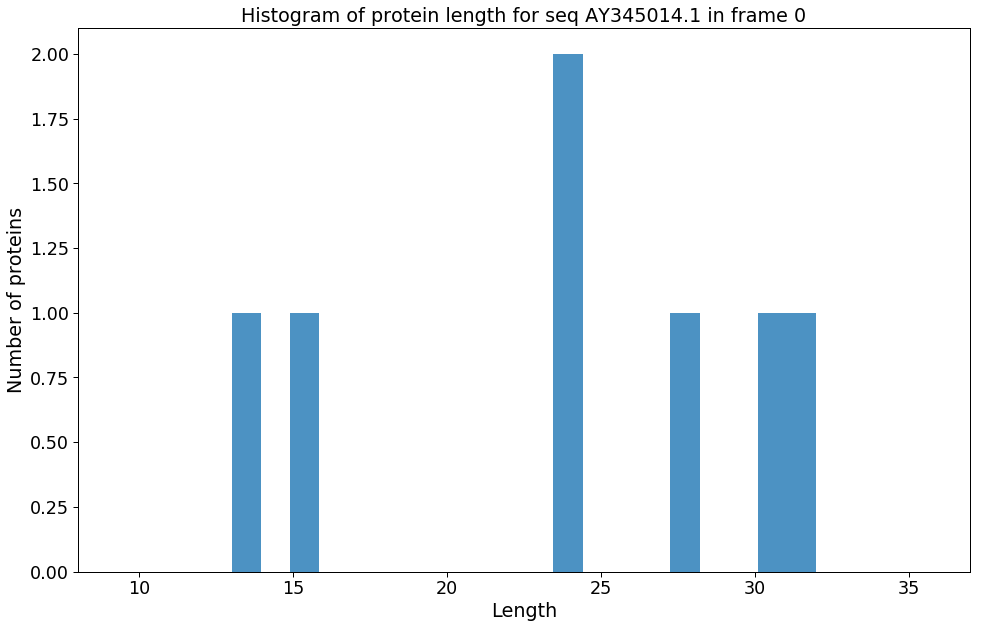


Current frame is  1
It has been found 16 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	4



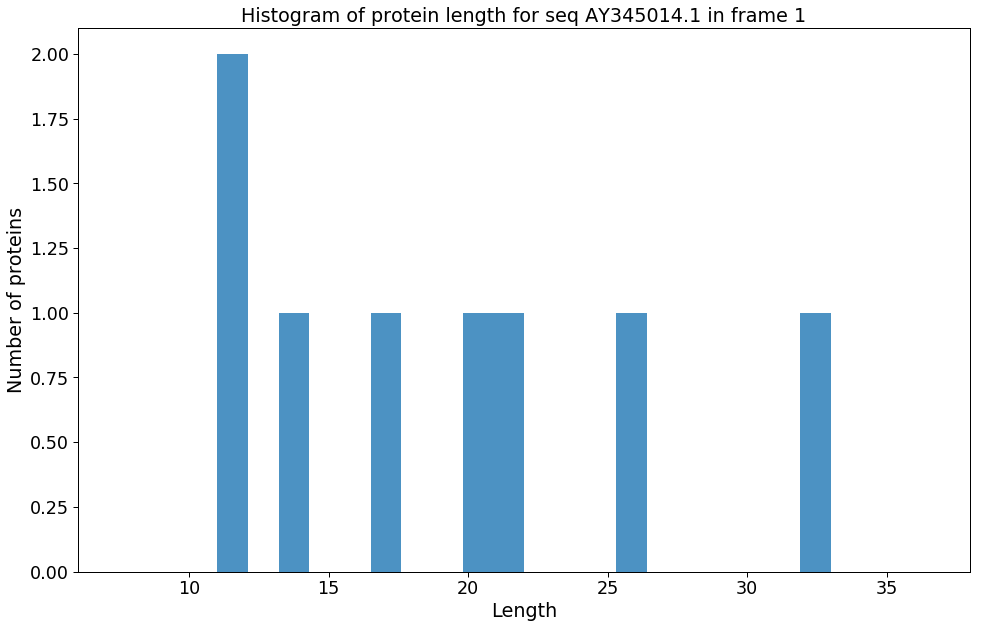


Current frame is  2
It has been found 16 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	4



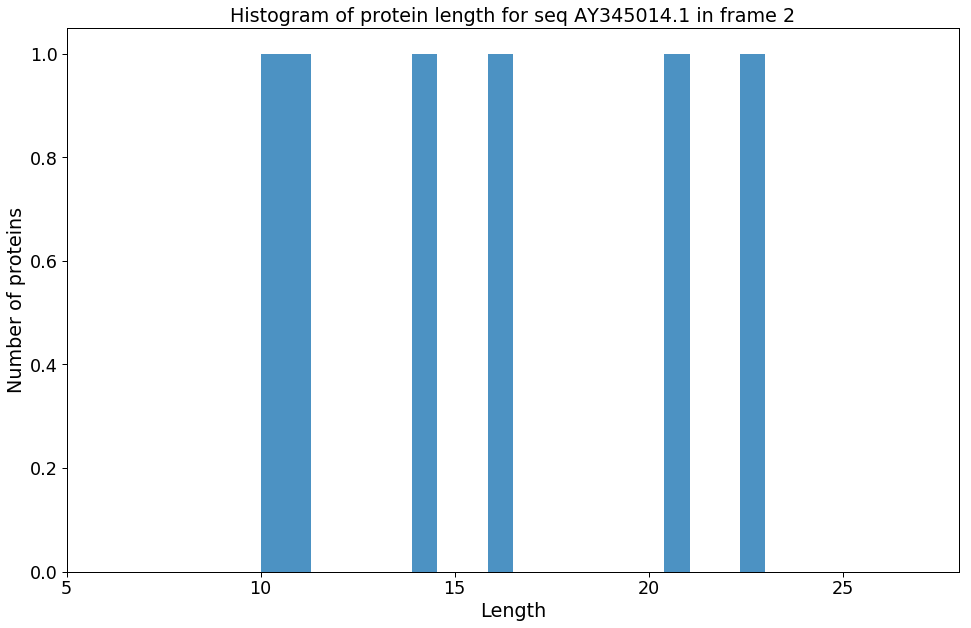


Current frame is  3
It has been found 13 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	2



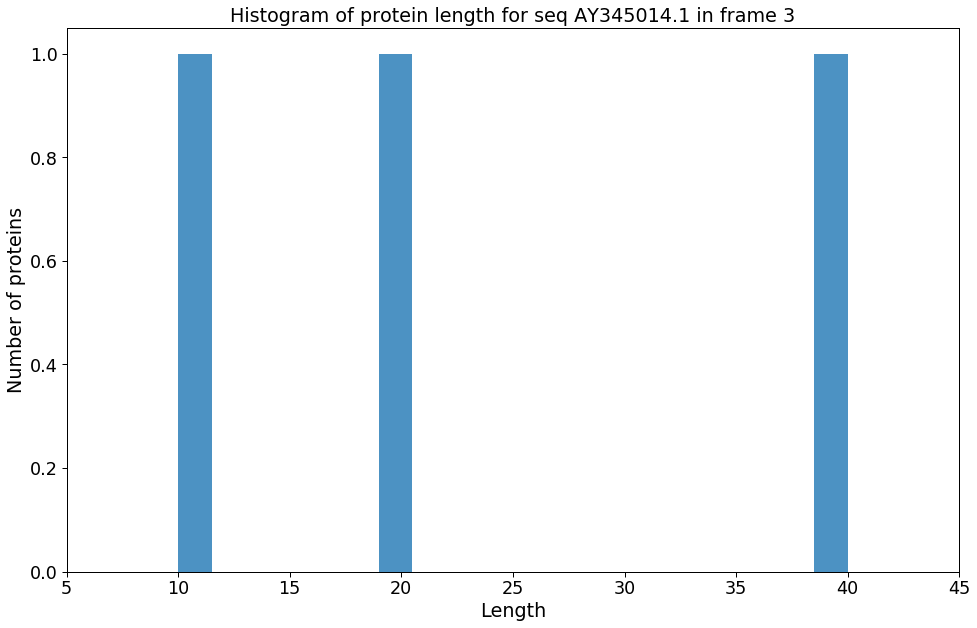


Current frame is  4
It has been found 15 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	4



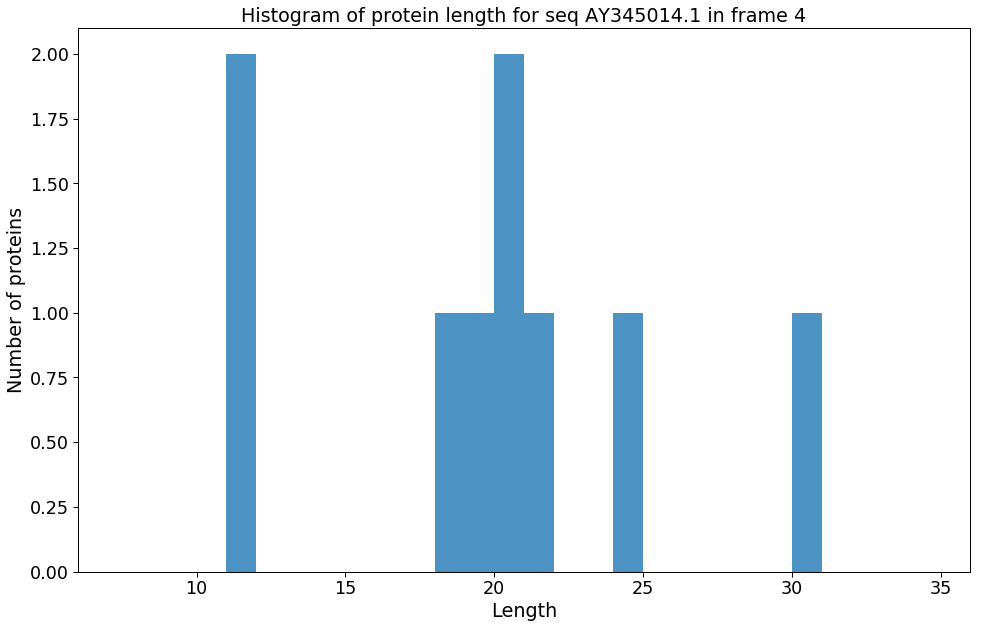


Current frame is  5
It has been found 9 proteins

Protein length by bins:
Bin size = 20
Bin	Score



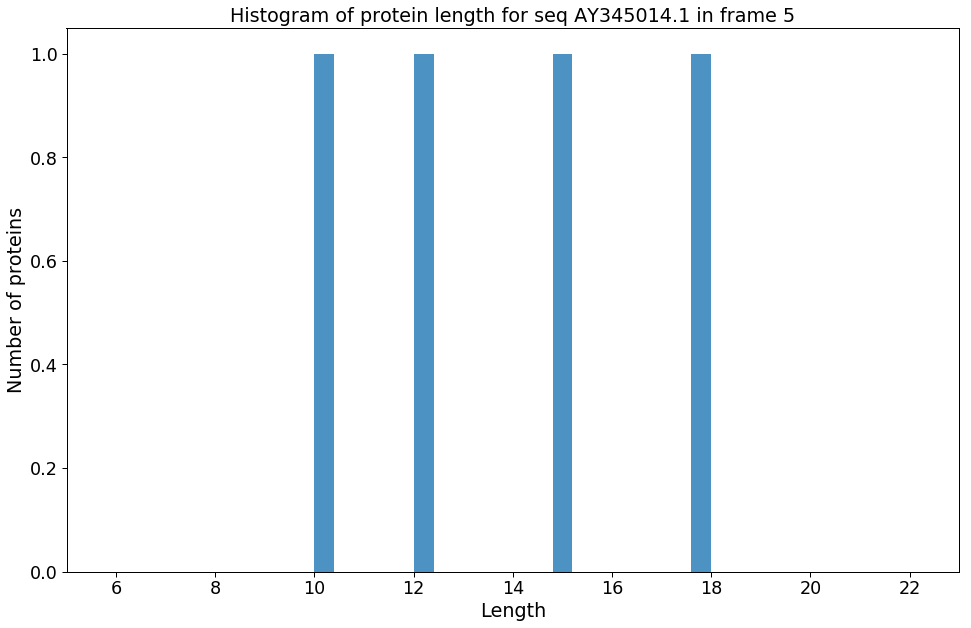


Done


In [73]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr


import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np



root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    file = "/home/pavel/Desktop/ORF_SMTB/Nuc_pairs_count/seq.fasta" # str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")

minimal_len_prot = 10 # int(input("Type the minimal protein length "))
maximal_len_prot = 100 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
codone_log_button = "y" # str(input("Do you want to have a codon log file? [y]/[n] "))
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4


code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score


def revComp(seq): #Reverse complement
    seq2 = ''
    d = {'A':'T','T':'A','C':'G','G':'C','M':'K','K':'M','R':'Y','Y':'R','S':'S','W':'W','N':'N'}
    for i in range(len(seq)):
        seq2 = d[seq[i]] + seq2
    return seq2


def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
    
    

log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    #>>> mito_table.stop_codons
    #['TAA', 'TAG', 'AGA', 'AGG']
    #>>> mito_table.start_codons
    #['ATT', 'ATC', 'ATA', 'ATG', 'GTG']

    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


@log_wrapper("protein_translator log")
def protein_translator(line_in, codone_log_button = "y", code_calc = code_calc):

    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    line_out = []
    amino_info_collector = {}

    if len(line_in) % 3 == 0:
        for i in range(0, len(line_in), 3):

            codon = line_in[i:(i + 3)]
            if codon in code_calc.keys(): # считаем кодоны
                code_calc[codon] = int(code_calc[codon]) + 1

                
            if codon in code.keys(): # считаем аминокислоты, но другим способом
                ama = code[codon]
                line_out = line_out + list(ama)
                if ama in amino_info_collector.keys():
                    amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
                else:
                    amino_info_collector[ama] = 1

    if codone_log_button == "y": # пишем в файл то, что насчиталось
        out_stat_file.write(">" + "frame_" + str(i) + "_" + str(j) + "_stat" + "\n")
        for i in amino_info_collector.keys():
            out_stat_file.write(str(i) + "\t" + str(amino_info_collector[i]) + "\n")

    if len(line_in) % 3 != 0: # добавляем N, пока длина последовательности не будет кратна 3м 
        while len(line_in) % 3 != 0:
            line_in = line_in + "N"
            protein_translator(line_in)
    line_out = "".join(line_out)
    return line_out



def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------


with open(file, "r") as in_file:
    seqs={}
    for line in in_file:
        line = line.rstrip()
        if len(line) > 0:
            if line[0] == ">":
                words = line.split()
                name = words[0][1:]
                seqs[name] = ''
            else:
                seqs[name] = seqs[name] + line



for record in seqs.keys():
    sequence = seqs[record]
    name = record
    print("Seq name is ", name)
    
    
    basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
    if not os.path.exists(basicdir): # если нет basicdir, то создаем
        os.makedirs(basicdir)
    os.chdir(basicdir) # заходим в неё
    # теперь работаем и сохраняем только в ней
        
    
    #complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
    #sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

    # можно с помощью функции
    #print(sequence)
    sequence_rev = revComp(sequence)

    nuc_stat = nuc_stat_counter(sequence)
    print("")
    print("Basic information about the sequence ", name)
    print("")
    print("Nucleotide composition:")
    for s in nuc_stat.keys():
        print(str(s), nuc_stat[s])
    print("")
    print("GC%", getGC(sequence))
    print("")
    
    orf_dict = {}
    for i in range(3):  # перебираем каждую из рамок на прямой цепи
        print("Iteration", i)
        frame = i
        orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
        orf_dict[i] = orfs
        #print(orf_dict)
    
    for j in range(3): # и на обратной
        print("Iteration", -j)
        frame_rev = j
        orfs_rev = orf_finder(sequence_rev, frame_rev)
        orf_dict[j + 3] = orfs_rev
        #print(orf_dict)
    
    # получили словари с ORFs по рамкам
    out_protein_orf_name = "out_protein_orf_" + str(name.split(" ")[0]) + ".txt"
    out_codon_stat_name = "out_codon_stat_" + str(name.split(" ")[0]) + ".fasta"
    with open(out_protein_orf_name, "w") as out_file:
        out_file.write("Nuc_seq" + "\t" + "Amino_seq" + "\t" + "SD_seq" + "\t" + "SD_score" + "\t" + "Srtand" + "\t" + "Frame" + "\t" + "Left_border" + "\t" + "Right_border" + "\t" + "Len" + "\t" + "GC%" + "\t" + "GC_fold_change" + "\t" + "ScoreTr" + "\n")

        with open(out_codon_stat_name, "w") as out_stat_file:
            for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
                print("Current frame is ",i)
                bin_len_list = []
                prot_calc = 0 # заводим счетчики для полипептидов          
            
                if int(i) <= 2:
                    #print(sequence)
                    code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)
                    #print("Codone composition of the seq:")
                    #for s in code_calc_seq.keys():
                    #    print(str(s), code_calc_seq[s])
                    #print("")
                
                    #for s in amino_info_collector_seq.keys():
                    #    print(str(s), amino_info_collector_seq[s])
                    #print("")
                    
                if int(i) > 2:
                    #print(sequence_rev)
                    code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)
                    #print("Codone composition of the seq:")
                    #for s in code_calc_seq.keys():
                    #    print(str(s), code_calc_seq[s])
                    #print("")
                
                    #for s in amino_info_collector_seq.keys():
                    #    print(str(s), amino_info_collector_seq[s])
                    #print("")
    
                for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
    
                    prot_calc += 1
                    if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
                        
                        subseq = sequence[left_border:right_border]
                        if len(subseq) >= minimal_len_prot_3 and len(subseq) <= maximal_len_prot_3: 
                            line = protein_translator(subseq, codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            SD_seq = sequence[left_border - 20:left_border]
                            #print(len(SD_seq))
                            if len(SD_seq) == 20:
                                #print("OK")
                                SD_score = checkSD(SD_seq)
                            else:
                                SD_score = 0.0
                                
                            code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                            scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                            out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "+" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(right_border - left_border) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\n")
                        else:
                            pass
                        
                    if int(i) > 2 and len(orf_dict[i][j]) == 2:
                        left_border = int(orf_dict[i][j][0]) - 1
                        right_border = int(orf_dict[i][j][1]) - 1
    
                        subseq = sequence_rev[left_border:right_border]
                        if len(subseq) >= minimal_len_prot_3 and len(subseq) <= maximal_len_prot_3: 
                            line = protein_translator(subseq, codone_log_button)
                            bin_len_list = bin_len_list + [len(line)]
                            SD_seq = sequence_rev[left_border - 20:left_border]
                            #print(len(SD_seq))
                            if len(SD_seq) == 20:
                                #print("OK")
                                SD_score = checkSD(SD_seq)
                            else:
                                SD_score = 0.0
                            code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                            scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                            out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "-" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(right_border - left_border) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\n")

                        else:
                            pass
           

                print("It has been found " + str(prot_calc) + " proteins")
                print("")
                
                try:
                    print("Protein length by bins:")
                    print("Bin size =", bin_size)
                    l = numpy.array(bin_len_list)
                    bins = numpy.arange(0, max(l), bin_size)
                    print("Bin" + "\t" + "Score")
                    for s in range(1,len(bins)):
                        print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
                    print("")
    
                    if hist == "y":
                        fig = matplotlib.pyplot.gcf()
                        fig.set_size_inches(16, 10)
                        sns.set_context("paper", font_scale=2)
                
                        plt.hist(l, bin_size, alpha = 0.8)
                        plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                        plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                        plt.xlabel('Length')
                        plt.ylabel('Number of proteins')
                        
                        plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                        plt.show()
                    print("")
                except ValueError:
                    continue

    # нужно вернуться в корень и все повторить
    os.chdir(root)
    
    print("Done")  # the end

In [75]:
final_table = pd.read_csv("/home/pavel/Desktop/ORF_SMTB/ORF_finder/results_for_AY345014.1/out_protein_orf_AY345014.1.txt", sep='\t')
final_table

Nuc_seq  \
0   ATGTGGTCTGGTAGGGACTGGATTAAGTTTATTAATTCGGTTCGAG...   
1   ATGGGCTCACCATATATTCACAGTTGGAATAGATGTAGATACTCGA...   
2   ATGAGTTCTAGGATTTATTTTTCTTTTTACTTTAGGAGGACTGACG...   
3   ATGAGAAGCTCTTTTAGCCCAACGAACAACCTTATTTTCAGAGGCT...   
4   ATGAAGTACTTAAACGTATATTTTAGTTACATTAAAAAGGACCTAG...   
5       ATGTCTGTCAAGTCTTATGATATCTGGAATCCTTTTAAAAGTATT   
6             ATGGATAAATGGGGGTCAGCTGTCTTCATAAAATTTTAT   
7                ATGGTAATACCTTTAATGATTGGGGGTTTTGGAAAC   
8   ATGGTCCCACTTTTAATTGGGGCTCCTGATATAAGATTCCCTCGAA...   
9          ATGCCTCGGCGATATTCGGACTATCCTGATGCCTACTTTAAG   
10  ATGGTCATACAAGTAGTTTCATGTATTATGATTTCCCGAAATAAGA...   
11  ATGAAATGTCTGTCAAGTCTTATGATATCTGGAATCCTTTTAAAAG...   
12  ATGATATCTGGAATCCTTTTAAAAGTATTTAGTACTTTCAAGTCAA...   
13                  ATGATAGTTTATATCTATTTATTAAAGGGAAAC   
14  ATGATTTTCTACACAAGACGAGTATCTAAGAAAGAAAAAGCTACCC...   
15         ATGGAAGACGAGGGCCTTTACCTGCTCCACTGTGATGAGTTC   
16                     ATGAGACATTGGCTAAAGCTCATTTCTTGG   
17  ATGCCTACTTTAAGTGAAACCAGATTTCCTCATTCGGATCTTTGTT...   
18  ATGATTATTTATTTTGTAGTTCCGCAGGGAAGTACTTATTCATACA...   
19                  ATGGACATAATTAGGTTTTGTTGCAATAAGGCC   
20   ATGGGGGTCAGCTGTCTTCATAAAATTTTATTGAACTTACTCTTAAGG   
21  ATGAAGACAGCTGACCCCCATTTATCCATTCATTCCAGACTTCAAT...   
22                     ATGCCTAATCGTCCTAGGTCCTTTTTAATG   
23  ATGAAGGAGGAAGAAGTCAGAATCTTATATTGTTCATTCGAGGGAA...   
24  ATGATGGGTGTATTTGCCGAGTTCCTTCTTAGAATTTTATTGTATT...   
25  ATGGGTGTATTTGCCGAGTTCCTTCTTAGAATTTTATTGTATTTAC...   
26  ATGTCCATTAACACAAAGTTTTTAGATCGTCTTATTTCGGGAAATC...   
27  ATGAGCTTTAGCCAATGTCTCATGTATAGTTATTCCAGTTATTACA...   
28  ATGTATAGTTATTCCAGTTATTACAGGAAATCAGTATACAAATCCC...   
29                  ATGAAAATGGGCAACTACATAATAAGTGTCGTG   
30  ATGGGCAATAGGCCCAGAGAGCGGAGGATAAACGGTTCACCCAGTC...   
31  ATGGGCTGTTACAATTACATTATAAAAATGATCATCACCAAGGAAA...   
32                  ATGATCATCACCAAGGAAAGCCCCTGCTGTTCC   
33                     ATGCTTCAGGCTATGTTTTTGTTAAACAGA   
34  ATGCTTTTTGATGTTTTTAATTACTTGATTATTACTAATTCAAACA...   
35               ATGAATAAGTACTTCCCTGCGGAACTACAAAATAAA   
36      ATGAAGAAAATTATAATAAAAGCATGGGCTGTTACAATTACATTA   

                                   Amino_seq                SD_seq  SD_score  \
0                   MWSGRDWIKFINSVRVRNSRGFPW  TACATACTTTTTGGTATGTG  0.000000   
1            MGSPYIHSWNRCRYSSLLYSCYNSDCCTHWN  GGTATTTTAGGATTTATTGT  0.000000   
2                   MSSRIYFSFYFRRTDGYCSFKLFS  CCTTTACCTGCTCCACTGTG  0.000000   
3           MRSSFSPTNNLIFRGSFAFTRVRHTSSSRFSQ  ATAATATTTATTTTTATACT  0.000000   
4               MKYLNVYFSYIKKDLGRLGIFRFLYSME  TCTGTAACTCCTTTATAAAG  0.000000   
5                            MSVKSYDIWNPFKSI  AAAAGGTTTTTAGGGATGAA  0.000000   
6                              MDKWGSAVFIKFY  TTAATTGAAGTCTGGAATGA  0.004960   
7                               MVIPLMIGGFGN  CTTTTATTATAATTTTCTTC  0.000000   
8                      MVPLLIGAPDIRFPRMNNIRF  TTGGGGGTTTTGGAAACTGA  0.000000   
9                             MPRRYSDYPDAYFK  ACTTCTTAGGGTTAGCCGGT  0.000000   
10                         MVIQVVSCIMISRNKTI  AGTTTTTTACCTTTTGAATA  0.000000   
11         MKCLSSLMISGILLKVFSTFKSTLRCRDLKAKE  TAAACAAAAGGTTTTTAGGG  0.000000   
12                MISGILLKVFSTFKSTLRCRDLKAKE  TGAAATGTCTGTCAAGTCTT  0.000000   
13                               MIVYIYLLKGN  AACCTATCGTCGAAACATTA  0.000000   
14                      MIFYTRRVSKKEKATLGITA  TATAGAACAATCTTCCCTTA  0.000000   
15                            MEDEGLYLLHCDEF  TAGTTGACTAATAACTCTTT  0.000000   
16                                MRHWLKLISW  AATAACTGGAATAACTATAC  0.003060   
17                     MPTLSETRFPHSDLCFLFSLL  GCGATATTCGGACTATCCTG  0.000000   
18                   MIIYFVVPQGSTYSYIISFLPFE  AGATTTTTATATAGTATGGA  0.000000   
19                               MDIIRFCCNKA  GATCTAAAAACTTTGTGTTA  0.000000   
20                          MGVSCLHKILLNLLLR  AGTCTGGAATGAATGGATAA  0.004960   
21                       MKTADPHLSIHSRLQLKVN  AGTAAGTTCAATAAAATTTT  0.000000   
22                                MPNRP

Start script
Seq name is  AY345014.1

Basic information about the sequence  AY345014.1

Nucleotide composition:
T 927
A 726
C 423
G 470

GC% 0.3507

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 9 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	3



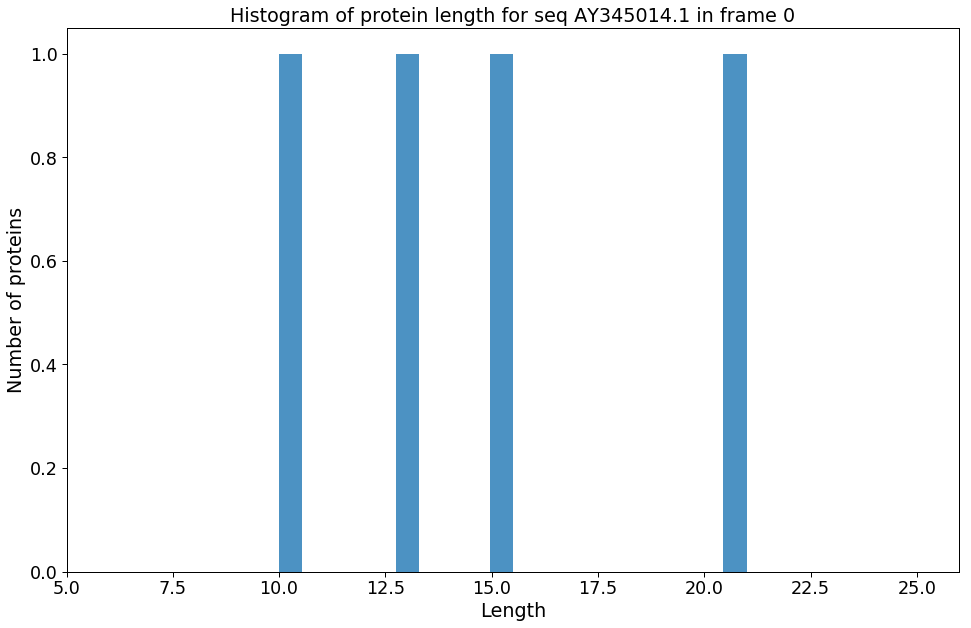


Current frame is  1
It has been found 16 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	8



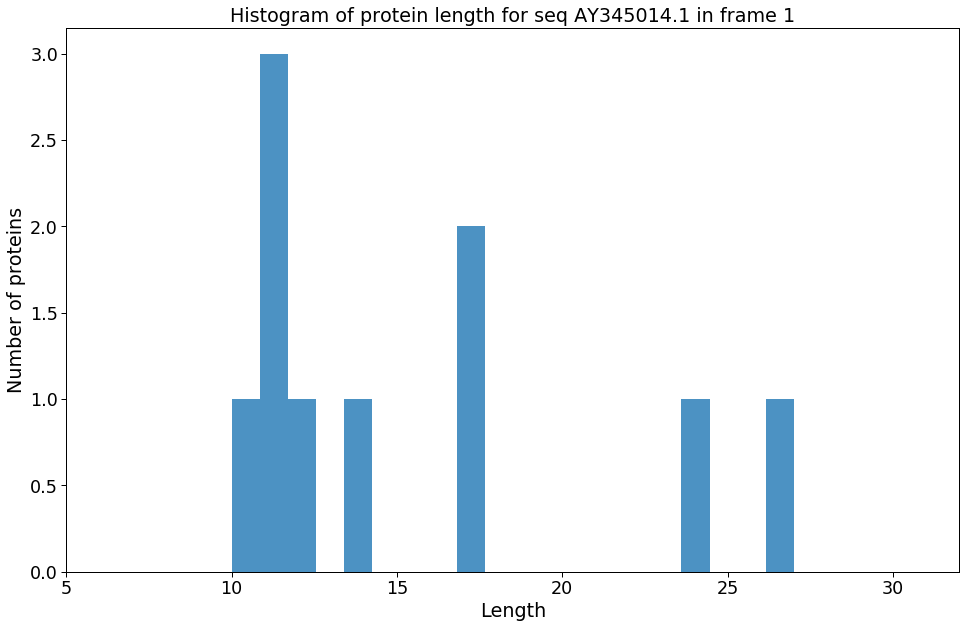


Current frame is  2
It has been found 16 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	2



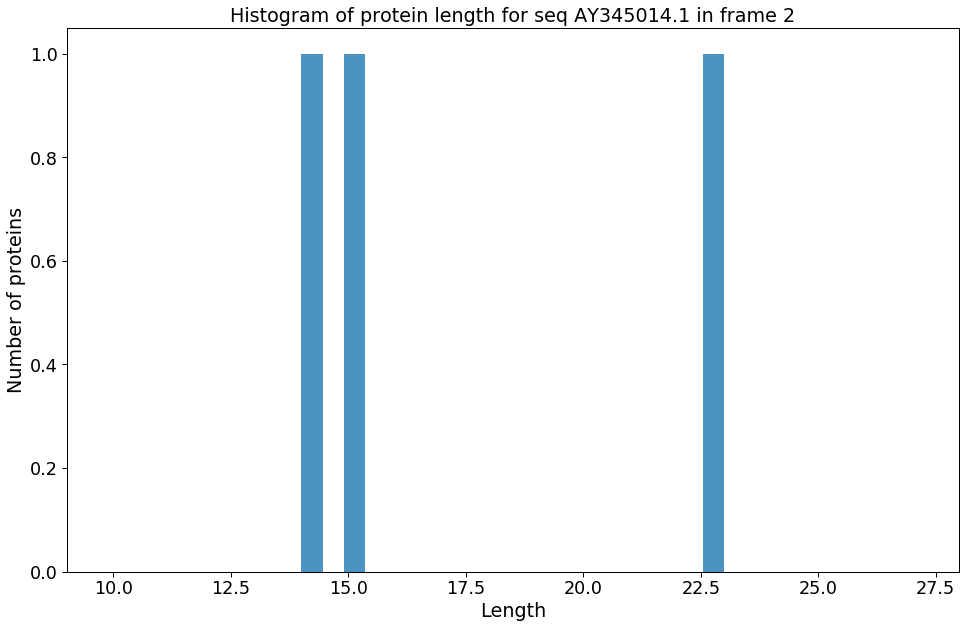


Current frame is  3
It has been found 13 proteins

Protein length by bins:
Bin size = 20
Bin	Score



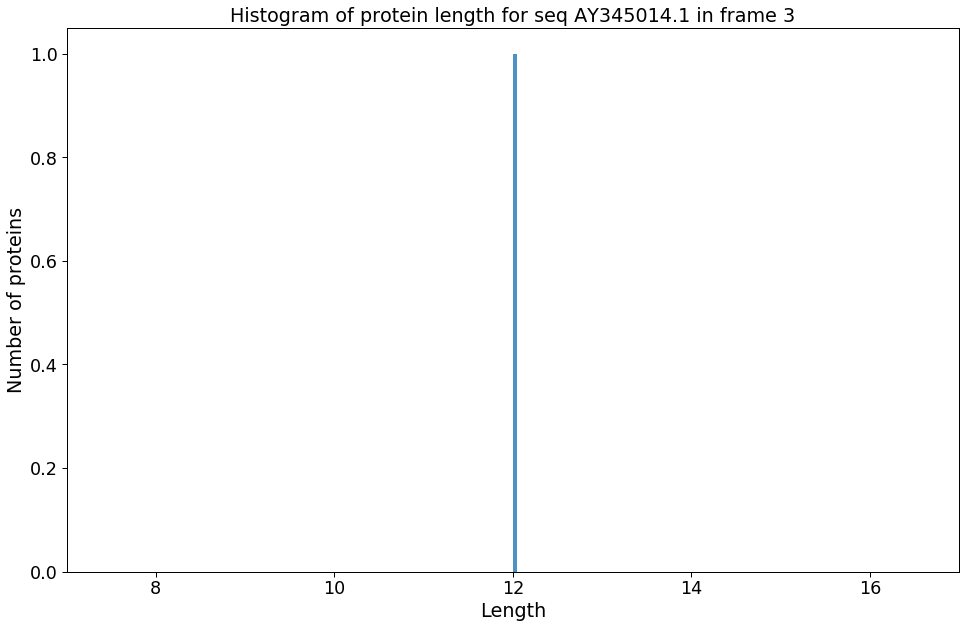


Current frame is  4
It has been found 15 proteins

Protein length by bins:
Bin size = 20
Bin	Score



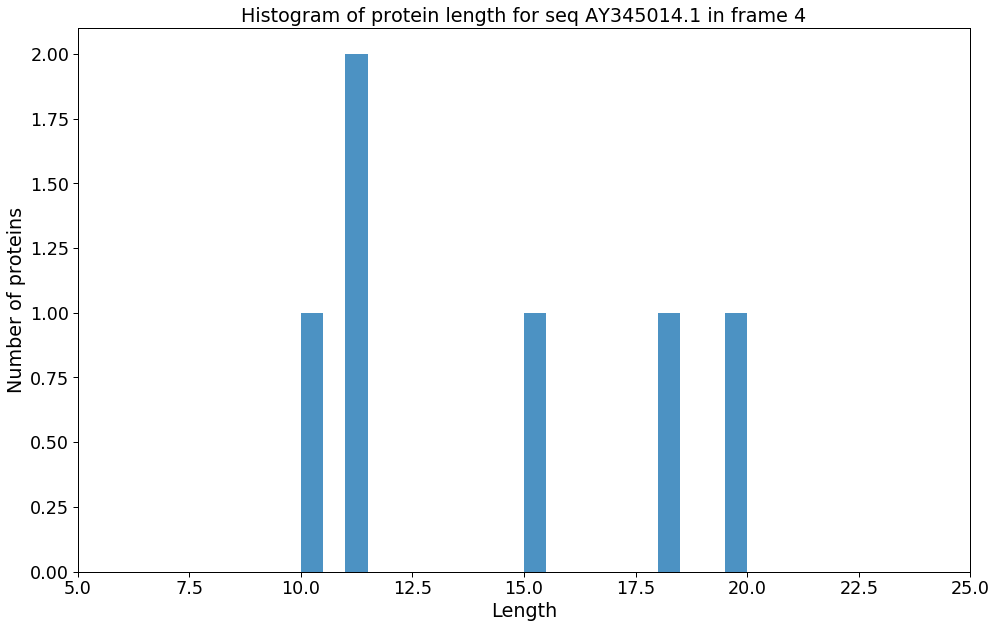


Current frame is  5
It has been found 9 proteins

Protein length by bins:
Bin size = 20
Bin	Score



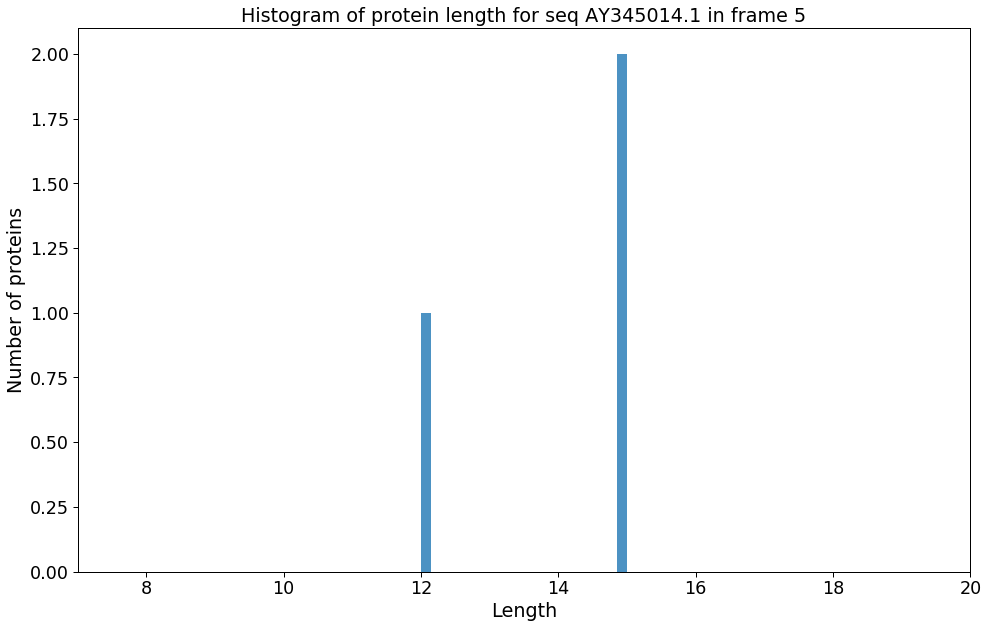


Done


In [94]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr
# попробуем сделать все более правильно, так как митохондрии и бактерии имеют разные генетические коды

import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna


root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    file = "/home/pavel/Desktop/ORF_SMTB/Nuc_pairs_count/seq.fasta" # str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")

minimal_len_prot = 10 # int(input("Type the minimal protein length "))
maximal_len_prot = 100 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
codone_log_button = "y" # str(input("Do you want to have a codon log file? [y]/[n] "))
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4
table_code = "Vertebrate Mitochondrial"


code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score


def revComp(seq): #Reverse complement
    seq2 = ''
    d = {'A':'T','T':'A','C':'G','G':'C','M':'K','K':'M','R':'Y','Y':'R','S':'S','W':'W','N':'N'}
    for i in range(len(seq)):
        seq2 = d[seq[i]] + seq2
    return seq2


def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
    
    

log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    #>>> mito_table.stop_codons
    #['TAA', 'TAG', 'AGA', 'AGG']
    #>>> mito_table.start_codons
    #['ATT', 'ATC', 'ATA', 'ATG', 'GTG']

    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------


with open(file, "r") as in_file:
    seqs={}
    for line in in_file:
        line = line.rstrip()
        if len(line) > 0:
            if line[0] == ">":
                words = line.split()
                name = words[0][1:]
                seqs[name] = ''
            else:
                seqs[name] = seqs[name] + line



for record in seqs.keys():
    sequence = seqs[record]
    name = record
    print("Seq name is ", name)
    
    
    basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
    if not os.path.exists(basicdir): # если нет basicdir, то создаем
        os.makedirs(basicdir)
    os.chdir(basicdir) # заходим в неё
    # теперь работаем и сохраняем только в ней
        
    
    #complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
    #sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

    # можно с помощью функции
    #print(sequence)
    sequence_rev = revComp(sequence)

    nuc_stat = nuc_stat_counter(sequence)
    print("")
    print("Basic information about the sequence ", name)
    print("")
    print("Nucleotide composition:")
    for s in nuc_stat.keys():
        print(str(s), nuc_stat[s])
    print("")
    print("GC%", getGC(sequence))
    print("")
    
    orf_dict = {}
    for i in range(3):  # перебираем каждую из рамок на прямой цепи
        print("Iteration", i)
        frame = i
        orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
        orf_dict[i] = orfs
        #print(orf_dict)
    
    for j in range(3): # и на обратной
        print("Iteration", -j)
        frame_rev = j
        orfs_rev = orf_finder(sequence_rev, frame_rev)
        orf_dict[j + 3] = orfs_rev
        #print(orf_dict)
    
    # получили словари с ORFs по рамкам
    out_protein_orf_name = "out_protein_orf_" + str(name.split(" ")[0]) + ".txt"
    with open(out_protein_orf_name, "w") as out_file:
        out_file.write("Nuc_seq" + "\t" + "Amino_seq" + "\t" + "SD_seq" + "\t" + "SD_score" + "\t" + "Srtand" + "\t" + "Frame" + "\t" + "Left_border" + "\t" + "Right_border" + "\t" + "Ama_len" + "\t" + "GC%" + "\t" + "GC_fold_change" + "\t" + "ScoreTr" + "\n")

        for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
            print("Current frame is ",i)
            bin_len_list = []
            prot_calc = 0 # заводим счетчики для полипептидов          
            
            if int(i) <= 2:
                #print(sequence)
                code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)
                #print("Codone composition of the seq:")
                #for s in code_calc_seq.keys():
                #    print(str(s), code_calc_seq[s])
                #print("")
                
                #for s in amino_info_collector_seq.keys():
                #    print(str(s), amino_info_collector_seq[s])
                #print("")
                    
            if int(i) > 2:
                #print(sequence_rev)
                code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)
                #print("Codone composition of the seq:")
                #for s in code_calc_seq.keys():
                #    print(str(s), code_calc_seq[s])
                #print("")
                
                #for s in amino_info_collector_seq.keys():
                #    print(str(s), amino_info_collector_seq[s])
                #print("")
    
            for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
    
                prot_calc += 1
                if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                    left_border = int(orf_dict[i][j][0]) - 1
                    right_border = int(orf_dict[i][j][1]) - 1
                        
                    subseq = sequence[left_border:right_border]
                    line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                    if len(line) >= minimal_len_prot and len(line) <= maximal_len_prot: 
                        #print(line)
                        bin_len_list = bin_len_list + [len(line)]
                        SD_seq = sequence[left_border - 20:left_border]
                        #print(len(SD_seq))
                        if len(SD_seq) == 20:
                            #print("OK")
                            SD_score = checkSD(SD_seq)
                        else:
                            SD_score = 0.0
                                
                        code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                        scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                        out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "+" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\n")
                    else:
                        pass
                        
                if int(i) > 2 and len(orf_dict[i][j]) == 2:
                    left_border = int(orf_dict[i][j][0]) - 1
                    right_border = int(orf_dict[i][j][1]) - 1
    
                    subseq = sequence_rev[left_border:right_border]
                    line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                    if len(line) >= minimal_len_prot and len(line) <= maximal_len_prot: 
                        
                        #print(line)
                        bin_len_list = bin_len_list + [len(line)]
                        SD_seq = sequence_rev[left_border - 20:left_border]
                        #print(len(SD_seq))
                        if len(SD_seq) == 20:
                            #print("OK")
                            SD_score = checkSD(SD_seq)
                        else:
                            SD_score = 0.0
                        code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                        scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                        out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "-" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\n")

                    else:
                        pass
           

            print("It has been found " + str(prot_calc) + " proteins")
            print("")
                
            try:
                print("Protein length by bins:")
                print("Bin size =", bin_size)
                l = numpy.array(bin_len_list)
                bins = numpy.arange(0, max(l), bin_size)
                print("Bin" + "\t" + "Score")
                for s in range(1,len(bins)):
                    print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
                print("")
    
                if hist == "y":
                    fig = matplotlib.pyplot.gcf()
                    fig.set_size_inches(16, 10)
                    sns.set_context("paper", font_scale=2)
                
                    plt.hist(l, bin_size, alpha = 0.8)
                    plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                    plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                    plt.xlabel('Length')
                    plt.ylabel('Number of proteins')
                        
                    plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                    plt.show()
                print("")
            except ValueError:
                continue

    # нужно вернуться в корень и все повторить
    os.chdir(root)
    
    print("Done")  # the end

In [95]:
final_table = pd.read_csv("/home/pavel/Desktop/ORF_SMTB/ORF_finder/results_for_AY345014.1/out_protein_orf_AY345014.1.txt", sep='\t')
final_table

Nuc_seq  \
0   ATGGGCTCACCATATATTCACAGTTGGAATAGATGTAGATACTCGA...   
1   ATGAAGTACTTAAACGTATATTTTAGTTACATTAAAAAGGACCTAG...   
2       ATGTCTGTCAAGTCTTATGATATCTGGAATCCTTTTAAAAGTATT   
3             ATGGATAAATGGGGGTCAGCTGTCTTCATAAAATTTTAT   
4                ATGGTAATACCTTTAATGATTGGGGGTTTTGGAAAC   
5   ATGGTCCCACTTTTAATTGGGGCTCCTGATATAAGATTCCCTCGAA...   
6   ATGTCTTCCCTATTAGGTGCTATTAACTTTATTACAACAATTTTTA...   
7   ATGCGGGCTCCAGGGATTACTATGGAACGAGTGAGACTATTCGTTT...   
8   ATGCTATTAACTGATCGAAACTTTAATACTAGATTCTTTGACCCTG...   
9          ATGCCTCGGCGATATTCGGACTATCCTGATGCCTACTTTAAG   
10  ATGGTCATACAAGTAGTTTCATGTATTATGATTTCCCGAAATAAGA...   
11  ATGAAATGTCTGTCAAGTCTTATGATATCTGGAATCCTTTTAAAAG...   
12  ATGATATCTGGAATCCTTTTAAAAGTATTTAGTACTTTCAAGTCAA...   
13                  ATGATAGTTTATATCTATTTATTAAAGGGAAAC   
14         ATGGAAGACGAGGGCCTTTACCTGCTCCACTGTGATGAGTTC   
15  ATGATTATTTATTTTGTAGTTCCGCAGGGAAGTACTTATTCATACA...   
16   ATGGGGGTCAGCTGTCTTCATAAAATTTTATTGAACTTACTCTTAAGG   
17  ATGAAGACAGCTGACCCCCATTTATCCATTCATTCCAGACTTCAAT...   
18  ATGATGGGTGTATTTGCCGAGTTCCTTCTTAGAATTTTATTGTATT...   
19  ATGTCCATTAACACAAAGTTTTTAGATCGTCTTATTTCGGGAAATC...   
20  ATGAGCTTTAGCCAATGTCTCATGTATAGTTATTCCAGTTATTACA...   
21                  ATGAAAATGGGCAACTACATAATAAGTGTCGTG   
22  ATGGGCTGTTACAATTACATTATAAAAATGATCATCACCAAGGAAA...   
23                  ATGATCATCACCAAGGAAAGCCCCTGCTGTTCC   
24  ATGCTTTTTGATGTTTTTAATTACTTGATTATTACTAATTCAAACA...   
25               ATGAATAAGTACTTCCCTGCGGAACTACAAAATAAA   
26      ATGAAGAAAATTATAATAAAAGCATGGGCTGTTACAATTACATTA   

                      Amino_seq                SD_seq  SD_score Srtand  Frame  \
0                    MGSPYIHSWN  GGTATTTTAGGATTTATTGT   0.00000      +      0   
1         MKYLNVYFSYIKKDLGRLGIF  TCTGTAACTCCTTTATAAAG   0.00000      +      0   
2               MSVKSYDIWNPFKSI  AAAAGGTTTTTAGGGATGAA   0.00000      +      0   
3                 MDKWGSAVFMKFY  TTAATTGAAGTCTGGAATGA   0.00496      +      0   
4                  MVMPLMIGGFGN  CTTTTATTATAATTTTCTTC   0.00000      +      1   
5                   MVPLLIGAPDM  TTGGGGGTTTTGGAAACTGA   0.00000      +      1   
6   MSSLLGAINFITTIFNMRAPGITMERV  TTTCTTTACACTTAGCAGGG   0.00000      +      1   
7                   MRAPGITMERV  TTATTACAACAATTTTTAAT   0.00000      +      1   
8                    MLLTDRNFNT  TGCTAGCAGGTGCTATTACT   0.00000      +      1   
9                MPRRYSDYPDAYFK  ACTTCTTAGGGTTAGCCGGT   0.00000      +      1   
10            MVMQVVSCIMISRNKTI  AGTTTTTTACCTTTTGAATA   0.00000      +      1   
11     MKCLSSLMMSGILLKVFSTFKSTL  TAAACAAAAGGTTTTTAGGG   0.00000      +      1   
12            MMSGILLKVFSTFKSTL  TGAAATGTCTGTCAAGTCTT   0.00000      +      1   
13                  MMVYIYLLKGN  AACCTATCGTCGAAACATTA   0.00000      +      1   
14               MEDEGLYLLHCDEF  TAGTTGACTAATAACTCTTT   0.00000      +      2   
15      MIIYFVVPQGSTYSYIISFLPFE  AGATTTTTATATAGTATGGA   0.00000      +      2   
16              MGVSCLHKILLNLLL  AGTCTGGAATGAATGGATAA   0.00496      +      2   
17                 MKTADPHLSIHS  AGTAAGTTCAATAAAATTTT   0.00000      -      3   
18                   MMGVFAEFLL  GCTATGTTTTTGTTAAACAG   0.00000      -      4   
19           MSINTKFLDRLISGNHNT  TATTGCAACAAAACCTAATT   0.00000      -      4   
20              MSFSQCLMYSYSSYY  GCAAAAAATATCACCAAGAA   0.00000      -      4   
21                  MKMGNYMMSVV  GCTCCTATTGATAAAACATA   0.00000      -      4   
22         MGCYNYIMKMIITKESPCCS  AAGAAAATTATAATAAAAGC   0.00000      -      4   
23                  MIITKESPCCS  GTTACAATTACATTATAAAA   0.00000      -      4   
24              MLFDVFNYLIITNSN  AATTTTATTGTATTTACTAA   0.00000      -      5   
25                 MNKYFPAELQNK  AGGTAAAAAACTAATGATGT   0.00000      -      5   
26              MKKIMMKAWAVTITL  CAATCATTAAAGGTATTACC   0.00000      -      5   

    Left_border  Right_border  Ama_len     GC%  GC_fold_change     ScoreTr  
0           810           903       31  0.4086        1.165098  17505.5694  
1          1494          1

Теперь подтянем разметку из .gb файла.

Start script
Seq name is  MF029692.1

Basic information about the sequence  MF029692.1

Nucleotide composition:
A 6783
T 5622
G 1160
C 2417

GC% 0.2238

Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration -1
Iteration -2
Current frame is  0
It has been found 870 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	204
2	139
3	60
4	29
5	12
6	6
7	2



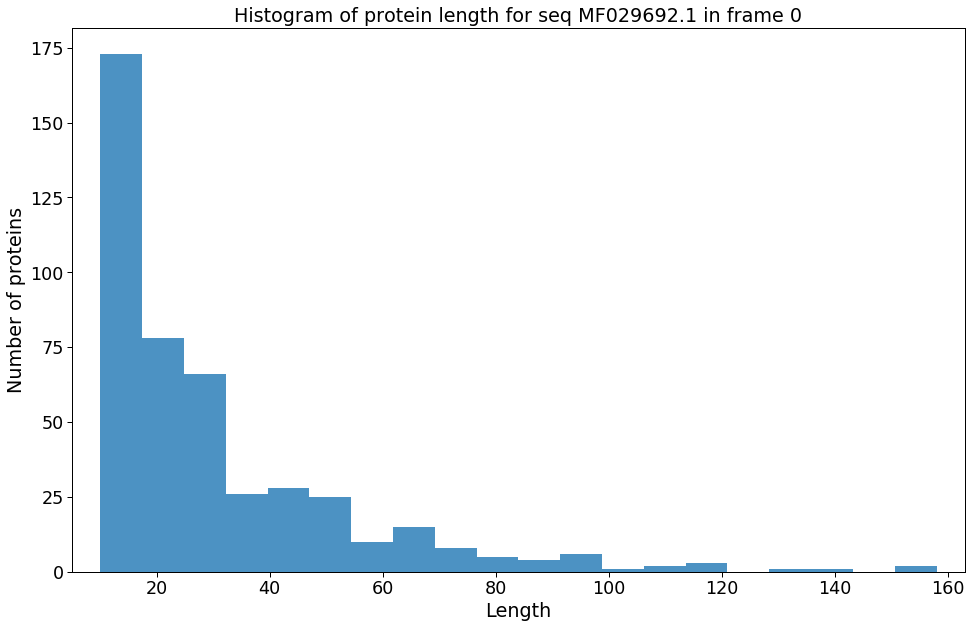


Current frame is  1
It has been found 787 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	172
2	108
3	43
4	4
5	3
6	5



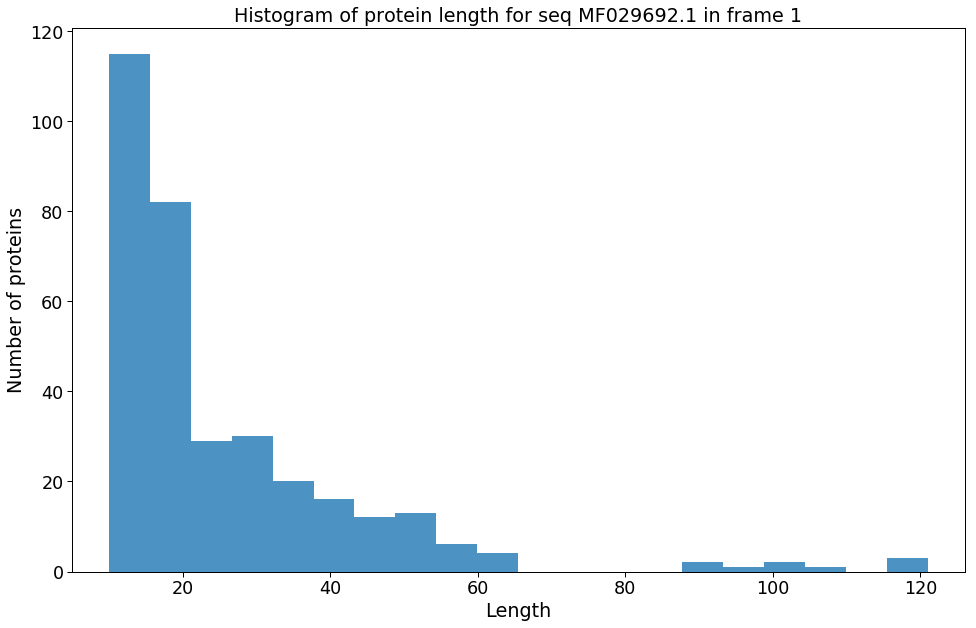


Current frame is  2
It has been found 893 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	210
2	101
3	60
4	17
5	10
6	7



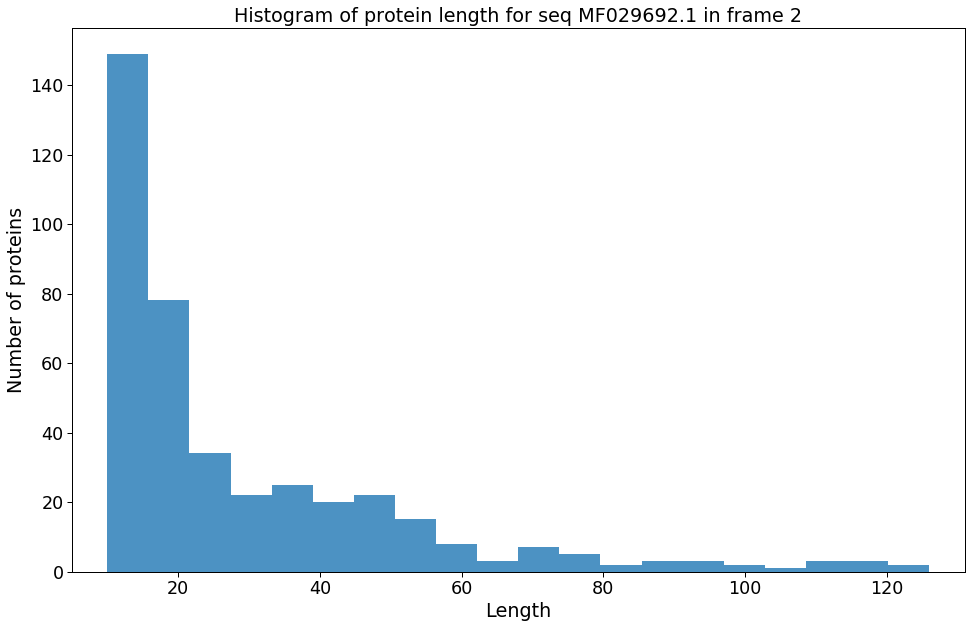


Current frame is  3
It has been found 935 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	217
2	99
3	37
4	11
5	9



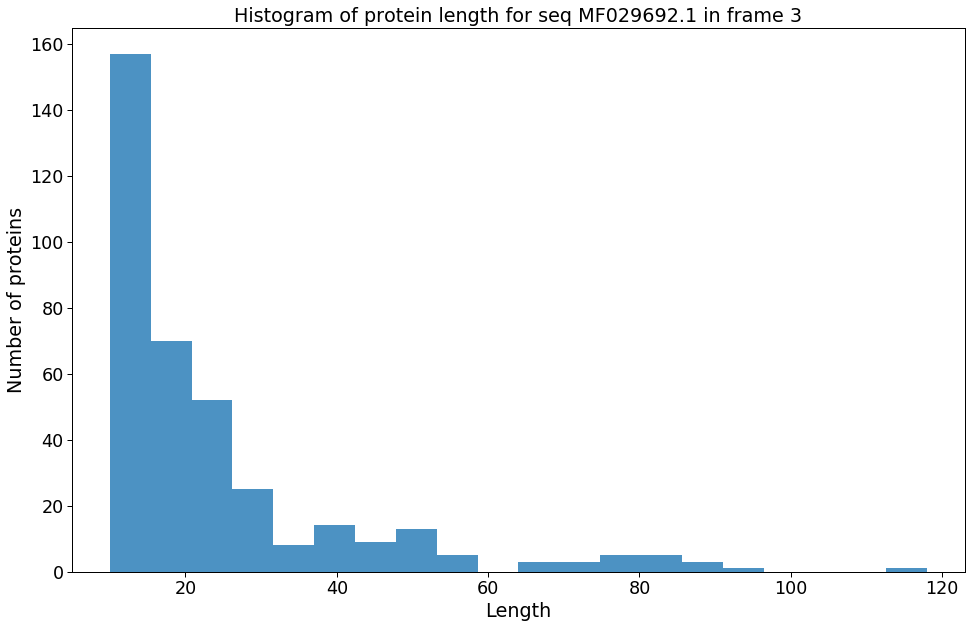


Current frame is  4
It has been found 824 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	181
2	71
3	39
4	5
5	7
6	3
7	8
8	3
9	4
10	2
11	2
12	3
13	4
14	2
15	4



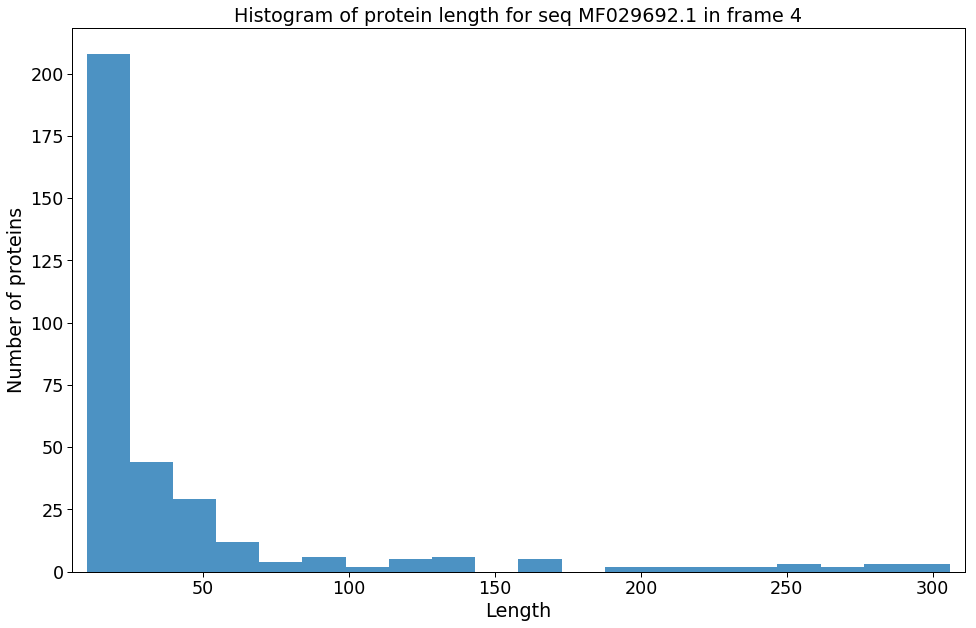


Current frame is  5
It has been found 908 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	205
2	151
3	53
4	21
5	9



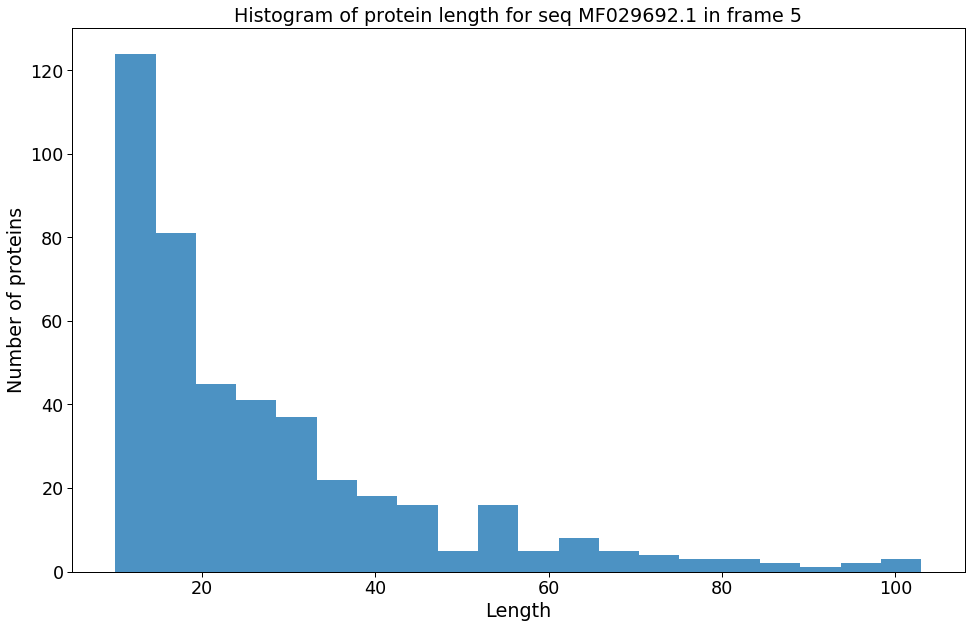


Done


In [197]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr
# попробуем сделать все более правильно, так как митохондрии и бактерии имеют разные генетические коды
# сделал подтягивание разметки

import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import generic_dna


root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    file = "/home/pavel/Desktop/ORF_SMTB/Nuc_pairs_count/seq.fasta" # str(input("Type the name of fasta file "))
except IOError:
    print ("Wrong file name!")

minimal_len_prot = 10 # int(input("Type the minimal protein length "))
maximal_len_prot = 10000 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
codone_log_button = "y" # str(input("Do you want to have a codon log file? [y]/[n] "))
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4
table_code = "Vertebrate Mitochondrial"


code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score


def revComp(seq): #Reverse complement
    seq2 = ''
    d = {'A':'T','T':'A','C':'G','G':'C','M':'K','K':'M','R':'Y','Y':'R','S':'S','W':'W','N':'N'}
    for i in range(len(seq)):
        seq2 = d[seq[i]] + seq2
    return seq2


def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
    
    

log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    #stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    #start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    stop_codons = ['TAA', 'TAG', 'AGA', 'AGG']  # стоп кодоны
    start_codon = ['ATT', 'ATC', 'ATA', 'ATG', 'GTG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()

    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        delta = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if delta > 0:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------

record = SeqIO.read("/home/pavel/Desktop/ORF_SMTB/Mitochondrial complete sequences/sequence.gb", "genbank")
features_list = []
for feature in record.features:
    if feature.type != "gene":
        features_list.append([int(feature.location.start), int(feature.location.end), feature.strand, feature.type, str(feature.qualifiers).split("'")[3]])
#print(features_list)        

sequence = str(record.seq)
name = record.id
print("Seq name is ", name)
    
    
basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
if not os.path.exists(basicdir): # если нет basicdir, то создаем
    os.makedirs(basicdir)
os.chdir(basicdir) # заходим в неё
# теперь работаем и сохраняем только в ней
        
    
#complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
#sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

# можно с помощью функции
#print(sequence)
sequence_rev = revComp(sequence)

nuc_stat = nuc_stat_counter(sequence)
print("")
print("Basic information about the sequence ", name)
print("")
print("Nucleotide composition:")
for s in nuc_stat.keys():
    print(str(s), nuc_stat[s])
print("")
print("GC%", getGC(sequence))
print("")
    
orf_dict = {}
for i in range(3):  # перебираем каждую из рамок на прямой цепи
    print("Iteration", i)
    frame = i
    orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
    orf_dict[i] = orfs
    #print(orf_dict)
    
for j in range(3): # и на обратной
    print("Iteration", -j)
    frame_rev = j
    orfs_rev = orf_finder(sequence_rev, frame_rev)
    orf_dict[j + 3] = orfs_rev
    #print(orf_dict)
    
# получили словари с ORFs по рамкам
out_protein_orf_name = "out_protein_orf_" + str(name.split(" ")[0]) + ".txt"
with open(out_protein_orf_name, "w") as out_file:
    out_file.write("Nuc_seq" + "\t" + "Amino_seq" + "\t" + "SD_seq" + "\t" + "SD_score" + "\t" + "Srtand" + "\t" + "Frame" + "\t" + "Left_border" + "\t" + "Right_border" + "\t" + "Ama_len" + "\t" + "GC%" + "\t" + "GC_fold_change" + "\t" + "ScoreTr" + "\t" + "Features" + "\n")
    for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
        print("Current frame is ",i)
        bin_len_list = []
        prot_calc = 0 # заводим счетчики для полипептидов          
            
        if int(i) <= 2:
            #print(sequence)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)
            #print("Codone composition of the seq:")
            #for s in code_calc_seq.keys():
            #    print(str(s), code_calc_seq[s])
            #print("")
                
            #for s in amino_info_collector_seq.keys():
            #    print(str(s), amino_info_collector_seq[s])
            #print("")
                    
        if int(i) > 2:
            #print(sequence_rev)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)
            #print("Codone composition of the seq:")
            #for s in code_calc_seq.keys():
            #    print(str(s), code_calc_seq[s])
            #print("")
                
            #for s in amino_info_collector_seq.keys():
            #    print(str(s), amino_info_collector_seq[s])
            #print("")
    
        for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
    
            prot_calc += 1
            if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                if len(line) >= minimal_len_prot and len(line) <= maximal_len_prot: 
                    #print(line)
                    bin_len_list = bin_len_list + [len(line)]
                    SD_seq = sequence[left_border - 20:left_border]
                    #print(len(SD_seq))
                    if len(SD_seq) == 20:
                        #print("OK")
                        SD_score = checkSD(SD_seq)
                    else:
                        SD_score = 0.0
                                
                    code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                    scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                    features_for_orfs = []
                    for e in features_list[1:]:
                        if left_border > e[0] and right_border < e[1] and e[2] == 1:
                            features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
                            #print(e)
                            #print(left_border, right_border)
                            
                    out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "+" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
                else:
                    pass
             
            
            ###############################
            if int(i) > 2 and len(orf_dict[i][j]) == 2:
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
    
                subseq = sequence_rev[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                if len(line) >= minimal_len_prot and len(line) <= maximal_len_prot: 
                        
                    #print(line)
                    bin_len_list = bin_len_list + [len(line)]
                    SD_seq = sequence_rev[left_border - 20:left_border]
                    #print(len(SD_seq))
                    if len(SD_seq) == 20:
                        #print("OK")
                        SD_score = checkSD(SD_seq)
                    else:
                        SD_score = 0.0
                    code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                    scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    features_for_orfs = []
                    for e in features_list[1:]:
                        if left_border > e[0] and right_border < e[1] and e[2] == -1:
                            features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
                            #print(e)
                            #print(left_border, right_border)
                            
                    out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "-" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence_rev)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
                else:
                    pass
                 

        print("It has been found " + str(prot_calc) + " proteins")
        print("")
                
        try:
            print("Protein length by bins:")
            print("Bin size =", bin_size)
            l = numpy.array(bin_len_list)
            bins = numpy.arange(0, max(l), bin_size)
            print("Bin" + "\t" + "Score")
            for s in range(1,len(bins)):
                print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
            print("")
    
            if hist == "y":
                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(16, 10)
                sns.set_context("paper", font_scale=2)
                
                plt.hist(l, bin_size, alpha = 0.8)
                plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                plt.xlabel('Length')
                plt.ylabel('Number of proteins')
                        
                plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                plt.show()
            print("")
        except ValueError:
            continue

print("Done")  # the end

In [264]:
import statistics

final_table = pd.read_csv("/home/pavel/Desktop/ORF_SMTB/ORF_finder/results_for_MF029692.1/out_protein_orf_MF029692.1.txt", sep='\t')
final_table['index'] = range(0, len(final_table))

GC_list = list(final_table["GC_fold_change"])

stdev_GC_list = statistics.stdev(GC_list)
mean_GC_list = statistics.mean(GC_list)
print(stdev_GC_list, mean_GC_list)

final_table_GC_cleaned = final_table[list(final_table["GC_fold_change"] >= mean_GC_list + stdev_GC_list) or list(final_table["GC_fold_change"] <= mean_GC_list - stdev_GC_list)]
final_table_GC_cleaned[final_table_GC_cleaned["SD_score"] != 0.0]
#final_table_GC_cleaned

sort_final_table_GC_cleaned = final_table_GC_cleaned.sort_values('SD_score',ascending=False)

ofile = open("my_fasta.fasta", "w")
for i, j in zip(final_table_GC_cleaned["index"], final_table_GC_cleaned["Amino_seq"]):
    ofile.write(">" + str(i) + "\n" + j + "\n")
ofile.close()

sort_final_table_GC_cleaned

0.35697441125162716 0.9597275795930527


Nuc_seq  \
2301      ATAGCTAAATCGACAGAAGGTCCTATGTGAGCTAAATTTTTTGAG   
699   ATTAATGCCCCATTAATAATCTGTAATACAGGATGAGTTTTTCGTA...   
902          ATGAACTGTCTATCCCCCTCTCTCAAAAAATTTAGCTCACAT   
913                      ATGATTAGCTACAATTTATGGATCCCCTAT   
794                   ATCAGTAACTTGAGCACATCACTCATTAATAAA   
1469  ATCGTCGTGGTATACCAGCTAAGCCTAAAAAATGTTGTGGGAAAAA...   
85    ATTCTAGGAGCTATTAATTTTATTACTACTATTATTAATATACGTT...   
92    ATAGAACGACTCCCTTTATTTGTATGATCTGTATTTATTACAGCCG...   
2347            ATTGGAGGTCAACATGACCCAATATCTATATTAGGTGCT   
327          ATTAGTAATTACAGTAGCACCTCAAAATGATATCTGCCCCCA   
38                    ATTAAGTGGCCGAAATACCAAGCACTAGACTTT   
1658            ATCGGGCTCCTTTCGATTTTGCAGAAGGGGAATCTGAAT   
2076                  GTGGATTTATTGTTGGTTGGGAAGGAGCTGTTT   
1766  ATTAGTGGATTTATTGTTGGTTGGGAAGGAGCTGTTTTAATAATAA...   
456                ATACATCTAAAGTTTATAATGGACTACGATGAGGAA   
1659            ATGTTGAGTATGGGGCGGTTGGTTTTGCATTATTATTTA   
1660                     ATGGGGCGGTTGGTTTTGCATTATTATTTA   
1393                     ATTTTACTAGGTTTTGAGGTGTTGACATTG   
815    ATCCTTCCTGATATACCCGATCCCCATTTTCTATACGATTCTTTTTAT   
1863      ATAGACAGTTCATCCGGTACCAGCTCCTCTTTTTACCGCAGCTGA   
1481  ATCCGGTACCAGCTCCTCTTTTTACCGCAGCTGAAGAAAGTAGTAA...   
407   ATATCAACAGACTCCCCTAACTGGATATGTAAAACCGCCAAACCTT...   
406   ATTATATCAACAGACTCCCCTAACTGGATATGTAAAACCGCCAAAC...   
1767  ATTGTTGGTTGGGAAGGAGCTGTTTTAATAATAATTTGTCATCGGT...   
554   ATTATGGACAATGTTCAGAAATCTGTGGTGCAAACCACTCATTTAT...   
555   ATGGACAATGTTCAGAAATCTGTGGTGCAAACCACTCATTTATACC...   
1449                     ATAGATTTAGTTGATTTAGACGTCCTGGGA   
2304  ATATCTGGAGCCCCTAATATTAAGGGGACTAATCAGTTACCAAATC...   
1482  ATCTTATATTATTTATACGGGGAAAAGCTATATCTGGAGCCCCTAA...   
2288  ATACCAAATCCTGGTAAGATTAAAATGTATACTTCTGGATGACCAA...   
...                                                 ...   
538   ATCGAAATTTCAACACAACTTTTTTTGATCCAAGAGGAGGAGGTGA...   
536                      ATTTTATTTTCGGAATTTGATCAGGCCTCC   
535   ATAAAGACATTGGTACATTATATTTTATTTTCGGAATTTGATCAGG...   
534   ATCATAAAGACATTGGTACATTATATTTTATTTTCGGAATTTGATC...   
533   ATATGCGATGAATATTTTCAACAAATCATAAAGACATTGGTACATT...   
461    ATTGATGAGGATCATAAACTAATATTAAGTGGCCGAAATACCAAGCAC   
460   ATACTTTTGTATATTGATGAGGATCATAAACTAATATTAAGTGGCC...   
616   ATTATTATTAAAACAGCTCCTTCCCAACCAACAATAAATCCACTAA...   
618   ATTAAAACAGCTCCTTCCCAACCAACAATAAATCCACTAATAACTC...   
798   ATGTTTAATACGAATTATAATAAATCATTTTTCTTCTTCACACCAC...   
701   ATCTGTAATACAGGATGAGTTTTTCGTAATGAACTAAGCATACTTA...   
795   ATCTTTTTCTATCTCTGACAGAATTTATGGATCAACATTCTTCGTA...   
793    ATTAGCCTCTGGAGTATCAGTAACTTGAGCACATCACTCATTAATAAA   
792   ATGTTGACCTCCAATTTACATCTTTCCTCTAAACCCTTTTCAAATT...   
760                      ATCTATTTTTGAGGTATGAACCCAACAGCT   
745   ATGCGGATTATCAAATTATATCAACAGACTCCCCTAACTGGATATG...   
712   ATAAAAACCAACCTGGTTTTCACCGGTTTGAACTCAGATCATGTAA...   
709                      ATTTGGACCCTTACGTATTTGAAAATATCT   
706                ATACCTAGCCCGAACTCAAATAAACAAAAATCTAAA   
686       ATTACAGTAGCACCTCAAAATGATATCTGCCCCCAAGGTAATACA   
619   ATAAATCCACTAATAACTCCAGCTAATATAATCCCTATATGTCCAA...   
685   ATATATGGAACTACAGAAACCAAATTAGTAATTACAGTAGCACCTC...   
684   ATTCAATATACTAAAACTTCACCAATATATGGAACTACAGAAACCA...   
683   ATAAATGGAAACAAAAAATGAAAACAAAAAAAACGGCTTAATGTAG...   
682   ATAATAAATGGAAACAAAAAATGAAAACAAAAAAAACGGCTTAATG...   
681   ATTACTAAACCTACAATAATAAATGGAAACAAAAAATGAAAACAAA...   
674   ATTACTAAACTAACTACACCACCCAACTTATTAGGAATAGAACGTA...   
673   ATAGATATTACTAAACTAACTACACCACCCAACTTATTAGGAATAG...   
620          ATAACTCCAGCTAATATAATCCCTATATGTCCAATAGAAGAA   
1092  ATTAAACCTACTTTATTTGGACCCTTACGTATTTGAAAATATCTTA...   

                                              Amino_seq                SD_seq  \
2301                                    MAKSTEGPMWAKFFE  CTGCTAAATGTAAGGAGAAA   
699                          INAPLMICNTGWVFRNELSMLMFKYP  TAACAGGAGATGGTAAATCA   
902                                      MNCLSPSLKKFSSH  AAAAGAGGAGCTGGTACCGG   
913                                          MISYNLWIPY  ACAGGAAT

In [214]:
final_table_GC_cleaned

Nuc_seq  \
0                     ATGACTCGAAATCCTTTTCACTTAGTTGAATTT   
7                     ATAATCCAATGATGACGTGATATTATTCGAGAA   
8                        ATCCAATGATGACGTGATATTATTCGAGAA   
14    ATAGATATTGGGTCATGTTGACCTCCAATTTACATCTTTCCTCTAA...   
15    ATTGGGTCATGTTGACCTCCAATTTACATCTTTCCTCTAAACCCTT...   
30    ATTTATGGATCAACATTCTTCGTAGCAACAGGATTTCATGGACTAC...   
37    ATAAATCATTTTTCTTCTTCACACCACTTTGGATTTGAAGCTGCTG...   
38                    ATTAAGTGGCCGAAATACCAAGCACTAGACTTT   
39           ATACCAATCAAGAAATGAAAATTCATATATGGTTTCGACCCA   
40                 ATCAAGAAATGAAAATTCATATATGGTTTCGACCCA   
42                       ATACCCTTGTTTCAGTGAAAAGCCAAAATT   
50    ATTTGAATGTGGATTTGATCCTTCCTGATATACCCGATCCCCATTT...   
51    ATGTGGATTTGATCCTTCCTGATATACCCGATCCCCATTTTCTATA...   
52    ATTTGATCCTTCCTGATATACCCGATCCCCATTTTCTATACGATTC...   
65           GTGCCCCTTTTCATCTATGATTACCCTCTATATGTAAAAATA   
68    ATGCGATGAATATTTTCAACAAATCATAAAGACATTGGTACATTAT...   
69    ATATTTTCAACAAATCATAAAGACATTGGTACATTATATTTTATTT...   
70    ATTGGTACATTATATTTTATTTTCGGAATTTGATCAGGCCTCCTAG...   
71              ATTTTCGGAATTTGATCAGGCCTCCTAGGTACATCCTTA   
72                       ATTTGATCAGGCCTCCTAGGTACATCCTTA   
73    ATAATTCGAACAGAATTAGGTCAACCAGGATCTTTATTAAATGATG...   
74    ATTCGAACAGAATTAGGTCAACCAGGATCTTTATTAAATGATGATC...   
75    ATTGTTACAGCCCATGCATTTGTAATAATTTTTTTTTTGGTTATAC...   
76    ATAATTTTTTTTTTGGTTATACCTGTTATAATTGGAGGATTTGGTA...   
77    ATTTTTTTTTTGGTTATACCTGTTATAATTGGAGGATTTGGTAACT...   
78    ATACCTGTTATAATTGGAGGATTTGGTAACTGATTAGTCCCCTTAA...   
79    ATAATTGGAGGATTTGGTAACTGATTAGTCCCCTTAATATTAGGGG...   
80    ATTGGAGGATTTGGTAACTGATTAGTCCCCTTAATATTAGGGGCTC...   
81        ATATTAGGGGCTCCAGATATAGCTTTTCCCCGTATAAATAATATA   
82    ATAGGACCTTCTGTCGATTTAGCTATTTTCTCCTTACATTTAGCAG...   
...                                                 ...   
2273  ATAAATCCTAAAGATCATAATATAGGAGGGGTATATTTAATAGGGG...   
2274                     ATAGGAGGGGTATATTTAATAGGGGATCCA   
2275  ATTGTAGCTAATCATCTAAAAACTTTAATTCCTGTTGGGATGGCAA...   
2276  ATTCCTGTTGGGATGGCAATAATTATTGTTGCGGCTGTAAAATATG...   
2277  ATGGCAATAATTATTGTTGCGGCTGTAAAATATGCTCGTGTATCAA...   
2278  ATAATTATTGTTGCGGCTGTAAAATATGCTCGTGTATCAACATCTA...   
2279  ATTATTGTTGCGGCTGTAAAATATGCTCGTGTATCAACATCTATTC...   
2280  ATTGTTGCGGCTGTAAAATATGCTCGTGTATCAACATCTATTCCAA...   
2286  ATATGGGAAATTATACCAAATCCTGGTAAGATTAAAATGTATACTT...   
2287  ATTATACCAAATCCTGGTAAGATTAAAATGTATACTTCTGGATGAC...   
2288  ATACCAAATCCTGGTAAGATTAAAATGTATACTTCTGGATGACCAA...   
2289  ATTAAAATGTATACTTCTGGATGACCAAAAAATCAAAATAAATGTT...   
2290  ATGTATACTTCTGGATGACCAAAAAATCAAAATAAATGTTGATATA...   
2291  ATTGGGTCACCTCCTCCTCTTGGATCAAAAAAAGTTGTGTTGAAAT...   
2292  GTGTTGAAATTTCGATCGGTTAAAAGTATAGTAATTGCACCAGCAA...   
2293                  ATAGTAATTGCACCAGCAAGTACTGGTAGTGAA   
2299  ATAGATGAGATTCCTGCTAAATGTAAGGAGAAAATAGCTAAATCGA...   
2300  ATTCCTGCTAAATGTAAGGAGAAAATAGCTAAATCGACAGAAGGTC...   
2301      ATAGCTAAATCGACAGAAGGTCCTATGTGAGCTAAATTTTTTGAG   
2302  ATATTATTTATACGGGGAAAAGCTATATCTGGAGCCCCTAATATTA...   
2303  ATACGGGGAAAAGCTATATCTGGAGCCCCTAATATTAAGGGGACTA...   
2304  ATATCTGGAGCCCCTAATATTAAGGGGACTAATCAGTTACCAAATC...   
2310  ATTACAAATGCATGGGCTGTAACAATTACATTATATAATTGATCAT...   
2336  ATAATTACATGTAGTCCATGAAATCCTGTTGCTACGAAGAATGTTG...   
2337   ATTACATGTAGTCCATGAAATCCTGTTGCTACGAAGAATGTTGATCCA   
2343  ATTATAGATTGGATTGCAGAGTTTAAATTATTATTTATTAATGAGT...   
2344  ATAGATTGGATTGCAGAGTTTAAATTATTATTTATTAATGAGTGAT...   
2345  ATTGCAGAGTTTAAATTATTATTTATTAATGAGTGATGTGCTCAAG...   
2346      ATTAATGAGTGATGTGCTCAAGTTACTGATACTCCAGAGGCTAAT   
2347            ATTGGAGGTCAACATGACCCAATATCTATATTAGGTGCT   

                                              Amino_seq                SD_seq  \
0                                           MTRNPFHLVEF                   NaN   
7                                           MIQWWRDIIRE  TTATATTAATAATTCTAACT   
8                                            IQWWRDIIRE  TATTAATAATTCTAACTATA   
14    MDIGSCWPPIYIFPLNPFQIPLLNTAILLASGVSVTWAHHSLMNNN...  ATAGAAGT

In [261]:
#parse BLAST results and save as genbank file
import os
import sys
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import Entrez
from Bio import SeqIO
Entrez.email= "pavel-kravchenk0@yandex.ru"

def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    local_file = open("blast_" + record_id + ".xml", 'w')

    counter = 1
    for x in output:
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
    
    local_file.close()
    print("Finished genbank processing.")


In [114]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr
# попробуем сделать все более правильно, так как митохондрии и бактерии имеют разные генетические коды
# сделал подтягивание разметки
# и поиск по бласту(почти всегда работает)
# есть отсечка по нуклеотидным последовательностям, но на больших данных долго считается


import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import statistics
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import Entrez
from Bio import SeqIO
Entrez.email= "pavel-kravchenk0@yandex.ru"
from Bio.SeqUtils import GC
from time import clock




root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    fasta_or_gb = "fasta" # str(input("Which format do you want to use? [fasta]/[gb]/[fasta+gb] "))
    file_fasta = root + "/sequence.fasta" # str(input("Type the name of fasta file "))
    file_gb = root + "/sequence.gb" # str(input("Type the name of gb file "))
except IOError:
    print ("Wrong file name!")

    
minimal_len_prot = 110 # int(input("Type the minimal protein length "))
maximal_len_prot = 100000 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4
table_code = "Vertebrate Mitochondrial"


code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score




def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
    
def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    local_file = open("blast_" + record_id + ".fasta", 'w')

    counter = 1
    for x in output:
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
    
    local_file.close()
    print("Finished genbank processing.")
    

log_file = open("log.txt", "w") # обертка логера
def log_wrapper(name):
    def real_decorator(func):
        def decorated_func(*args, **kwargs):
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function started".format(name, now) + "\n")
            result = func(*args, **kwargs)
            now = datetime.datetime.now()
            log_file.write("{}, Date: {}, Function ended".format(name, now) + "\n")
            return result
        return decorated_func
    return real_decorator


@log_wrapper("orf_finder log")
def orf_finder(sequence, frame): # модуль для поиска ORFs
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    #stop_codons = ['TAA', 'TAG', 'AGA', 'AGG']  # стоп кодоны
    #start_codon = ['ATT', 'ATC', 'ATA', 'ATG', 'GTG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()
    
    print("start/stop OK")
    print(len(start_positions), len(stop_positions))
    
    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if minimal_len_prot_3 < delta and maximal_len_prot_3 > delta:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
        print("Progress is {:2.1%}".format(start_positions.index(position_start)/len(start_positions), end="\r"))
    return orffound


@log_wrapper("module_fasta_writer log")
def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


@log_wrapper("nuc_stat_counter log")
def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------
start = clock()
record = SeqIO.read(file_gb, "genbank")
features_list = []
for feature in record.features:
    if feature.type != "gene":
        #print(feature.qualifiers, str(feature.qualifiers).split("'"))
        #print(str(feature.qualifiers).split("'")[3])
        features_list.append([int(feature.location.start), int(feature.location.end), feature.strand, feature.type, str(feature.qualifiers).split("'")[3]])
#print(features_list)        



with open(file_fasta, "r") as in_file: # открываем файл с одной последовательностью и считываем по строчкам
    sequence = []
    name = ""
    read_lines = in_file.readlines()
    for i in range(len(read_lines)):
        if read_lines[i][0] != ">":
            sequence.append(read_lines[i].strip())
        else:
            name = read_lines[i]
    
sequence = "".join(sequence)  # собираем все строчки в последовательность
print(sequence[:10])
name = record.id
print("Seq name is ", name)
print("seq OK")
print("") 
    
basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
if not os.path.exists(basicdir): # если нет basicdir, то создаем
    os.makedirs(basicdir)
os.chdir(basicdir) # заходим в неё
# теперь работаем и сохраняем только в ней
print("dir OK")
print("")      
    
#complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
#sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

# можно с помощью функции
#print(sequence)
sequence = Seq(sequence, generic_dna)
sequence_rev = str(sequence.reverse_complement())
print("rev_seq OK")
print("")

sequence = str(sequence)

print("GC%", getGC(sequence))
print("")
    
end = clock()
print(round(end - start,5), "seconds for preparations")
start = clock()

orf_dict = {}
for i in range(3):  # перебираем каждую из рамок на прямой цепи
    print("Iteration", i)
    frame = i
    orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
    orf_dict[i] = orfs
    #print(len(orf_dict.keys()))
    end = clock()
    print(round(end - start,5), "seconds for iteration")
    start = clock()

for j in range(3): # и на обратной
    print("Iteration", -j)
    frame_rev = j
    orfs_rev = orf_finder(sequence_rev, frame_rev)
    orf_dict[j + 3] = orfs_rev
    #print(len(orf_dict.keys()))
    end = clock()
    print(round(end - start,5), "seconds for iteration")
    start = clock()
    
print("orf_dict OK")
print("")
# получили словари с ORFs по рамкам
out_protein_orf_name = "out_protein_orf_" + str(name) + ".txt"
with open(out_protein_orf_name, "w") as out_file:
    out_file.write("Nuc_seq" + "\t" + "Amino_seq" + "\t" + "SD_seq" + "\t" + "SD_score" + "\t" + "Srtand" + "\t" + "Frame" + "\t" + "Left_border" + "\t" + "Right_border" + "\t" + "Ama_len" + "\t" + "GC%" + "\t" + "GC_fold_change" + "\t" + "ScoreTr" + "\t" + "Features" + "\n")
    for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
        print("Current frame is ",i)
        bin_len_list = []
        prot_calc = 0 # заводим счетчики для полипептидов          
            
        if int(i) <= 2:
            #print(sequence)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)
            #print("Codone composition of the seq:")
            #for s in code_calc_seq.keys():
            #    print(str(s), code_calc_seq[s])
            #print("")
                
            #for s in amino_info_collector_seq.keys():
            #    print(str(s), amino_info_collector_seq[s])
            #print("")
                    
        if int(i) > 2:
            #print(sequence_rev)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)
            #print("Codone composition of the seq:")
            #for s in code_calc_seq.keys():
            #    print(str(s), code_calc_seq[s])
            #print("")
                
            #for s in amino_info_collector_seq.keys():
            #    print(str(s), amino_info_collector_seq[s])
            #print("")
    
        for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
            prot_calc += 1
            if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                bin_len_list = bin_len_list + [len(line)]
                SD_seq = sequence[left_border - 20:left_border]
                if len(SD_seq) == 20:
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = 0.0
                                
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))

                out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "+" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
            else:
                pass
             
            
            ###############################
            if int(i) > 2 and len(orf_dict[i][j]) == 2:
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                #print(left_border, right_border)
    
                subseq = sequence_rev[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
   
                #print(line)
                bin_len_list = bin_len_list + [len(line)]
                SD_seq = sequence_rev[left_border - 20:left_border]
                #print(len(SD_seq))
                if len(SD_seq) == 20:
                    #print("OK")
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = 0.0
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
                        #print(e)
                        #print(left_border, right_border)
                            
                left_border = len(sequence) - int(orf_dict[i][j][1]) - 1
                right_border = len(sequence) - int(orf_dict[i][j][0]) - 1
                out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "-" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence_rev)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
            else:
                pass
                 

        print("It has been found " + str(prot_calc) + " proteins")
        print("")
                
        try:
            print("Protein length by bins:")
            print("Bin size =", bin_size)
            l = numpy.array(bin_len_list)
            bins = numpy.arange(0, max(l), bin_size)
            print("Bin" + "\t" + "Score")
            for s in range(1,len(bins)):
                print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
            print("")
    
            if hist == "y":
                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(16, 10)
                sns.set_context("paper", font_scale=2)
                
                plt.hist(l, bin_size, alpha = 0.8)
                plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                plt.xlabel('Length')
                plt.ylabel('Number of proteins')
                        
                plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                #plt.show()
                plt.gcf().clear()
            print("")
        except ValueError:
            continue

            
            
print(round(end - start,5), "seconds for the body")


final_table = pd.read_csv(basicdir + "/out_protein_orf_" + str(name) + ".txt", sep='\t')
final_table['index'] = range(0, len(final_table))

GC_list = list(final_table["GC_fold_change"])

stdev_GC_list = statistics.stdev(GC_list)
mean_GC_list = statistics.mean(GC_list)
print(stdev_GC_list, mean_GC_list)

final_table_GC_cleaned = final_table[list(final_table["GC_fold_change"] >= mean_GC_list + stdev_GC_list) or list(final_table["GC_fold_change"] <= mean_GC_list - stdev_GC_list)]
final_table_GC_cleaned[final_table_GC_cleaned["SD_score"] != 0.0]
final_table_GC_cleaned

sort_final_table_GC_cleaned = final_table_GC_cleaned.sort_values('SD_score',ascending=False)

#ofile = open("my_fasta.fasta", "w")
#for i, j in zip(final_table_GC_cleaned["index"], final_table_GC_cleaned["Amino_seq"]):
#    ofile.write(">" + str(i) + "\n" + j + "\n")
#ofile.close()



sort_final_table_GC_cleaned.head()

#for i, j in zip(final_table_GC_cleaned["index"], final_table_GC_cleaned["Nuc_seq"]):
#    print(i,j)
#    blast_search(str(i), j)


print("Done")  # the end

Start script
ATGTCTATGG
Seq name is  NC_025928.1
seq OK

dir OK

rev_seq OK

GC% 0.2827

0.00519 seconds for preparations
Iteration 0
start/stop OK
110 569
Progress is 99.1%
0.01363 seconds for iteration
Iteration 1
start/stop OK
90 408
Progress is 98.9%
0.00828 seconds for iteration
Iteration 2
start/stop OK
117 514
Progress is 99.1%
0.01344 seconds for iteration
Iteration 0
start/stop OK
71 470
Progress is 98.6%
0.0082 seconds for iteration
Iteration -1
start/stop OK
64 425
Progress is 98.4%
0.00638 seconds for iteration
Iteration -2
start/stop OK
68 489
Progress is 98.5%
0.00735 seconds for iteration
orf_dict OK

Current frame is  0
It has been found 108 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	90
2	10
3	5
4	0
5	2
6	0


Current frame is  1
It has been found 89 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	70
2	10
3	2
4	2
5	2
6	1


Current frame is  2
It has been found 115 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	100
2	8
3	3
4	1
5	1

<Figure size 1152x720 with 0 Axes>

In [115]:
print(len(sort_final_table_GC_cleaned[0:]))
sort_final_table_GC_cleaned


Nuc_seq  \
0    ATGTCTATGGGTATGGAAAGATGATTTAATTCTACAAATGCTAAAG...   
1    ATGGGTATGGAAAGATGATTTAATTCTACAAATGCTAAAGATATAG...   
2    ATGGAAAGATGATTTAATTCTACAAATGCTAAAGATATAGGTACAC...   
3    ATGATATTCTTCATGGTCGACAATTGAAGACTATTTAATTTTAATT...   
4    ATGGTCGACAATTGAAGACTATTTAATTTTAATTTTCAAGCTAGCA...   
5    ATGCCATCTATTCTTCAAACTAAAGCACGTAGAGTGTTACGTTATT...   
6    ATGGATGAGAATTCTAGCTTAGATGACGTTGTAAGCTTAGAACAGC...   
7    ATGGGCCAAGAAATAAGAGATAGATTACGTAAACAAAGAGGTACTC...   
8    ATGTATGATTCAATAAGTATTCATCATAAAACTTTAAATAACTGTT...   
9    ATGCCTGGGAACTAACTAAATTAATGTTTAGAACCCATCAGAGACT...   
10   ATGAAAATAATAATTTATTTGACCATTCTAAATCAATTAATAGATT...   
11   ATGGTGATGGAAGTTTTTCGATTGTCAGAGTAGCTGAAAGAAAATG...   
12   ATGGAAGTTTTTCGATTGTCAGAGTAGCTGAAAGAAAATGAACCCT...   
13   ATGAAATATTAGAAAATCCCAATTTATCTACTCAAGATAAAGATAA...   
14   ATGAAGTTAATGATACAAATAAAGCTAAATCTGTTATGAGTAAATA...   
15   ATGATACAAATAAAGCTAAATCTGTTATGAGTAAATATTGACTTAT...   
16   ATGCCTTTGAAATAACTCAAAAATTAGATTTTATCGTTTTAAAAGC...   
17   ATGTGAAATATAAAGGTAACTATGAAAAATTAAATAGTATAAGAGA...   
18   ATGAAAAATTAAATAGTATAAGAGAAAATATAAGAGTTTTCAGACA...   
19   ATGAAGGTATAGTCCAAACTATCATGAAAATGATAGAAATAACGAT...   
20   ATGTTATCCCCCATTATCAGGATTACAAAGTCACAGTGGACCAAGT...   
21   ATGAGCCGTAGTTATAACAGCAGTATTACTTTTATTATCATTACCT...   
22   ATGCTTATTTTATTATAAATTATTAAGTATCTTCAGAGACTATTCG...   
23   ATGTTTTAAATCTTATTTAAATATAGATCGTAAATTCTTTTCTGTA...   
24   ATGAGGTACGCCTACTAATAATGGAGAATTTGATCCTAAATTTTCT...   
25   ATGTAAATTTGAATTATCGCAAAGACAAAATGATCATAATTATGAA...   
26   ATGGCGACATATTGAGTGTCTGCCTTAAACAGTTTTGTTTATGAGG...   
27   ATGAGACCTGGTCTAGCAGGCCAAGAATATTTTTTTGGGTATTACA...   
28   ATGAGTAACTAAAGGAAGAATTCAATTAAATACAGTTGAAATAAAA...   
29   ATGAGAGCAAGATGTTAAAATACTAGAACATCTCTGTTCATTATTT...   
..                                                 ...   
484  ATGATCAAAATAATTAATCACCTTTTTAGCTGAACCAAAACTAGTT...   
485  ATGATTATATAAATTATTAGAATCATTTATTTTAAATTCTAGATTT...   
486  ATGCCCATCTCCATCTATCAAACCAGCTAAATAATGCCCAAATTGT...   
487  ATGCCCAAATTGTTCATCGTTTAGGGGTTTTAAATGAGTAGCCACA...   
488  ATGAGTAGCCACATGAATAGAAATATTTTTTATTGTTTCAGTATTG...   
489  ATGAATAGAAATATTTTTTATTGTTTCAGTATTGTCGCATATAGTC...   
490  ATGCTACATTTTAGTGTGTAACGTGTAACACTAAAATGTTTGGACC...   
491  ATGAGCTTTCATACTCTTCAATTCATATATCTTAGGCACTAAGTGC...   
492  ATGACCGTTTACATCATTAATAAGATTTAGAAAACCTTCTTTACTA...   
493  ATGTAATCTATATCTTAGTGCACTGACACCTGATCTTAATTTAATT...   
494  ATGAATTGATTTTATGTTTAACAAACGTATGGCCTCTGAAGTTCCT...   
495  ATGCTACATATGAAGCAGATTTTTTCGTTATTAAGTTATAGTTATT...   
496  ATGAAGCAGATTTTTTCGTTATTAAGTTATAGTTATTAAAATAAGT...   
497  ATGAACAGAGATGTTCTAGTATTTTAACATCTTGCTCTCATTTTTG...   
498  ATGTATTAAATCCTTTTACAAATTCTTCAAATTTTTCCTTTCTACG...   
499  ATGAAGTATTAAAATTACGGTCTGTAAGAACCATTGTAATACCCAA...   
500  ATGGTTAATTAATTAACCTCATAAACAAAACTGTTTAAGGCAGACA...   
501  ATGACAATACTTTTATTCAATCTTTATAGTTTAAATATTTACTAGA...   
502  ATGATGGAATTTTTCTTTTTACAGAAAAGAATTTACGATCTATATT...   
503  ATGGAATTTTTCTTTTTACAGAAAAGAATTTACGATCTATATTTAA...   
504  ATGATAATAAAAGTAATACTGCTGTTATAACTACGGCTCATCCGAA...   
505  ATGGGGGATAACATTTTTGTATTTATAACCTCATATTTAGTCGCGG...   
506  ATGAGCTATAGCTTTTAAAACGATAAAATCTAATTTTTGAGTTATT...   
507  ATGAACAATACGAGTAGAAGCTTTATTTACAAGATAAAAACTTCCT...   
508  ATGTATAGCTCTTAAATTATAAGTACTCTGAGTTAATTTAAAAAAT...   
509  ATGGAAATTATCTTTATTTTCGTAATATTTAAATCTATTAATTGAT...   
510  ATGGTCAAATAAATTATTATTTTCATTAGGATGCTCTACGTTTAGT...   
511  ATGCTCTACGTTTAGTCTCTGATGGGTTCTAAACATTAATTTAGTT...   
512  ATGGGTTCTAAACATTAATTTAGTTAGTTCCCAGGCATATTGTCTT...   
513  ATGTACGGACTATATCTTTATCTTTGAATATTATAAAATATACACT...   

                                             Amino_seq                SD_seq  \
0                                               MSMGME                   NaN   
1                                                 MGME                   NaN   
2                                                   ME                   NaN   
3                                            MMFFMVDNW  TTACAGCTCACGCTATATTA   
4                                                M

In [116]:
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord

features = []
for i,j,k,q in zip(sort_final_table_GC_cleaned["Left_border"], sort_final_table_GC_cleaned["Right_border"], sort_final_table_GC_cleaned["Srtand"], sort_final_table_GC_cleaned["Features"]):
    print(i,j,k,q)
    if k == "+":
        features.append(GraphicFeature(start=i, end=j, strand="+1", color='#ffcccc', label=q))
    if k == "-":
        #print(len(sequence))
        features.append(GraphicFeature(start=i, end=j, strand="-1", color='#cffccc', label=q))

#features

0 477 + []
6 477 + ['CDS_CO1_1']
12 477 + ['CDS_CO1_1']
201 1203 + ['CDS_CO1_1']
213 1203 + ['CDS_CO1_1']
546 1203 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg17_1']
636 1203 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg17_1']
753 1203 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg17_1']
861 1203 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg17_1']
1854 2202 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
1917 2268 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2016 2367 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2022 2367 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2286 2628 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2403 2760 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2412 2760 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg18_1']
2520 2868 + ['CDS_CO1_1', 'intron_CO1_1']
2730 3063 + ['CDS_CO1_1']
2751 3207 + ['CDS_CO1_1']
2859 3207 + ['CDS_CO1_1']
2976 3345 + ['CDS_CO1_1']
3150 3495 + ['CDS_CO1_1']
3282 3615 + ['CDS_CO1_1', 'intron_CO1_1', 'CDS_heg19_1']
3339 3711 + ['CDS_CO1_1', 'intron_CO1_1', 

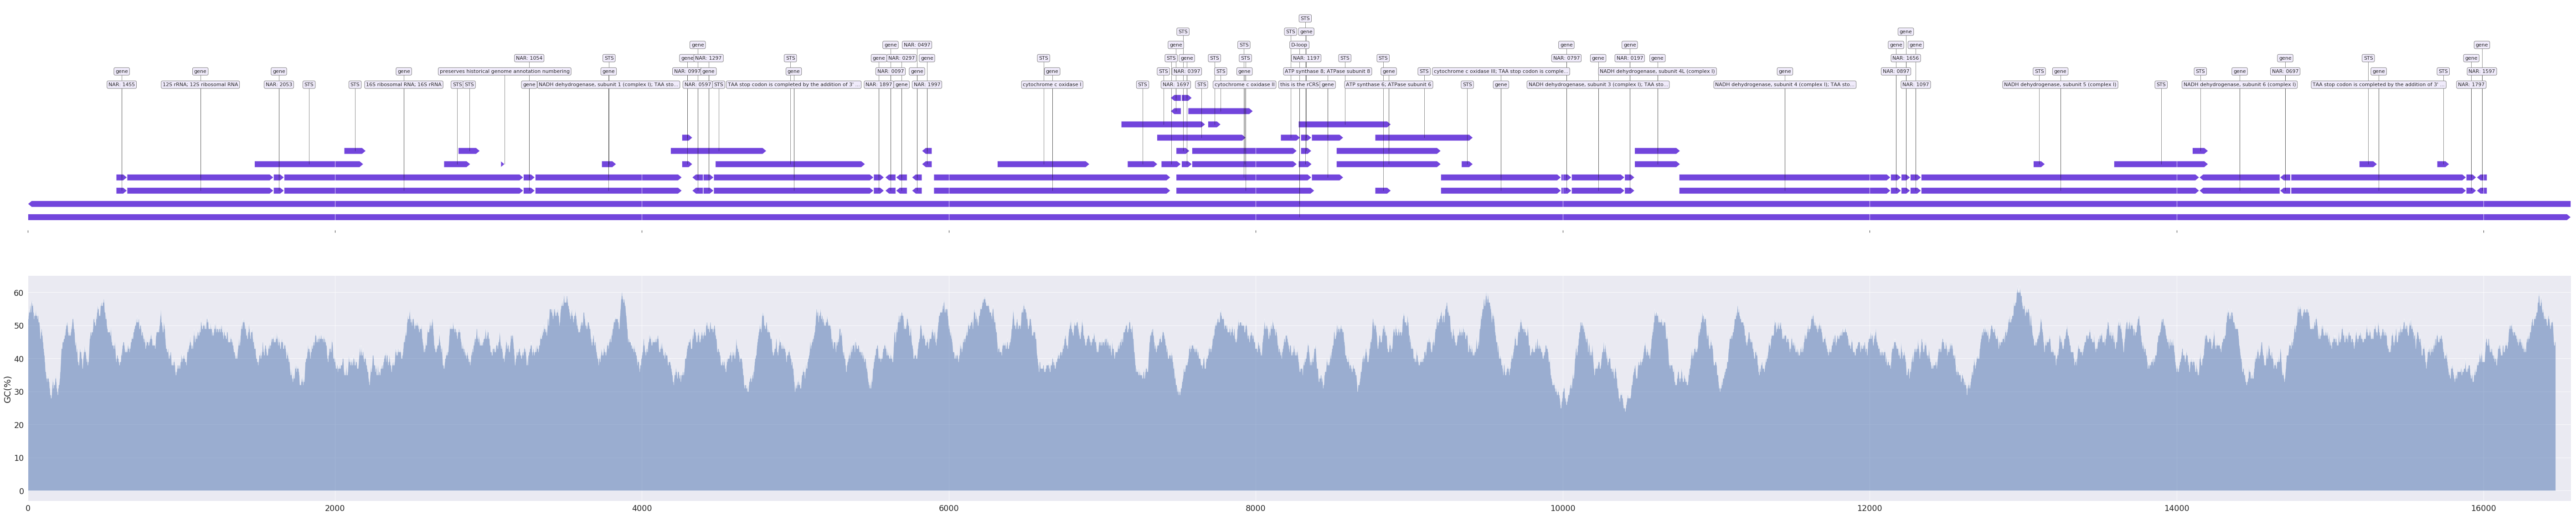

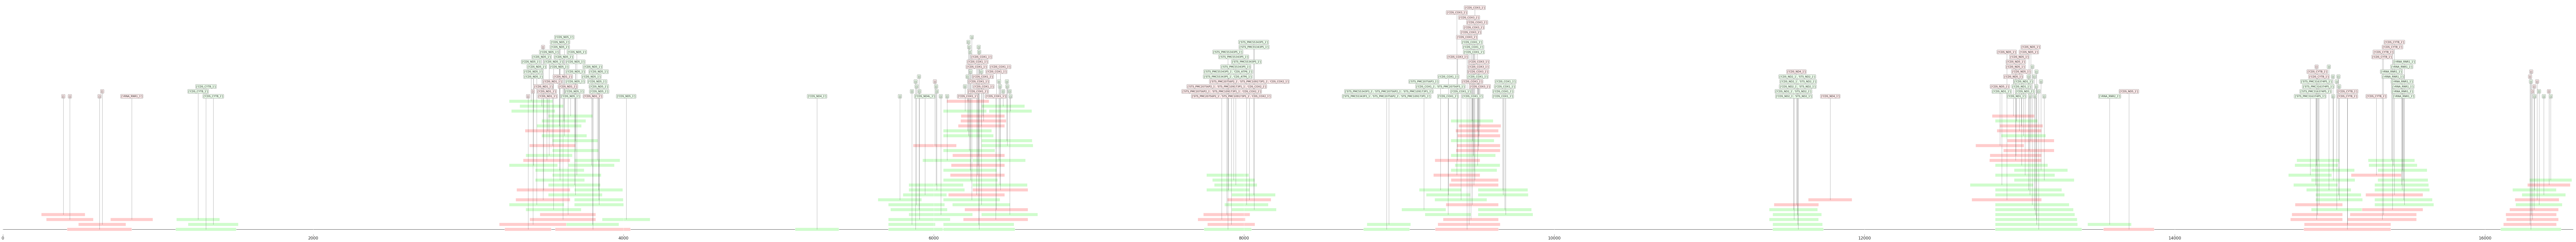

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 20), sharex=True)

# Parse the genbank file, plot annotations
record = SeqIO.read(root + "/sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=100, ax=ax2)

my_record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
ax, _ = my_record.plot(figure_width=200)


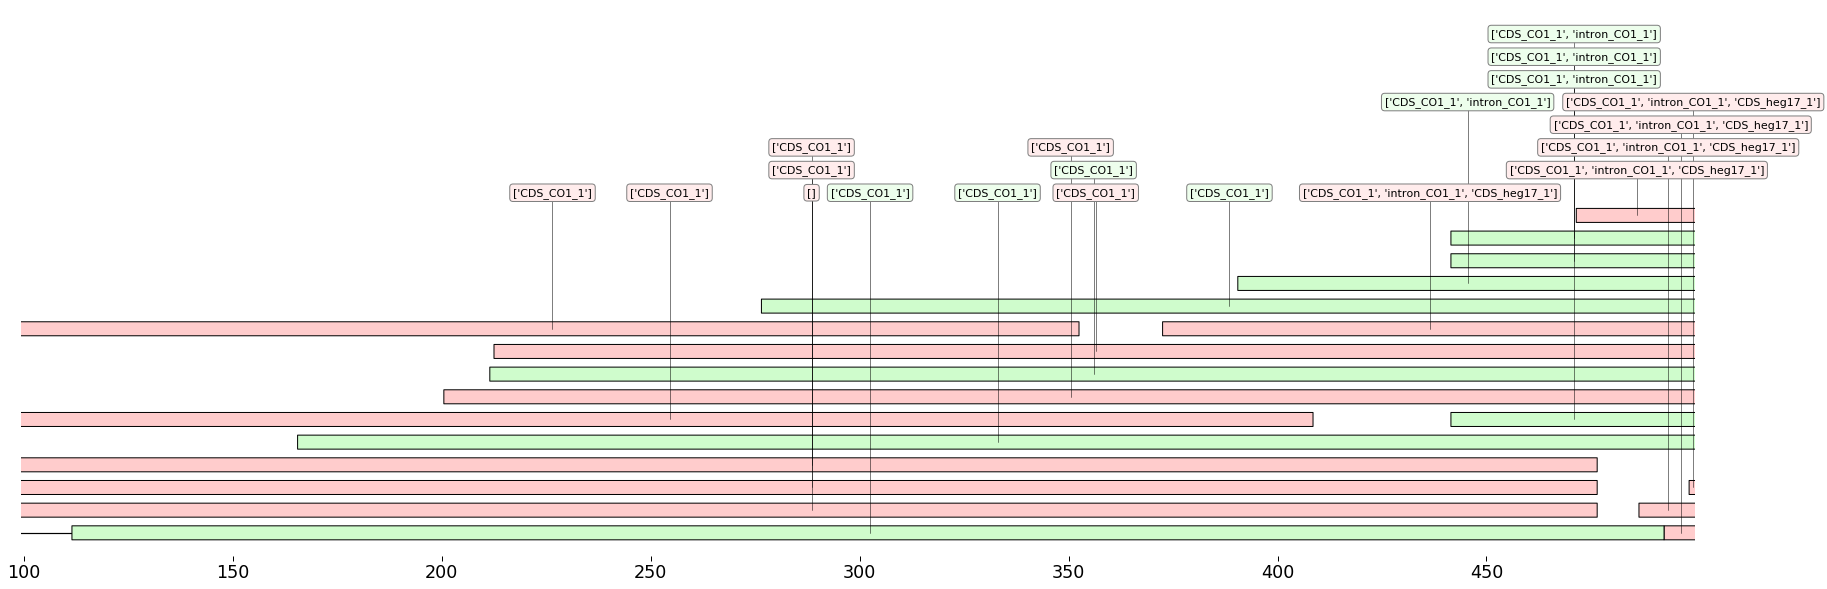

In [121]:
record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
cropped_record = record.crop((100, 500))
ax, _ = cropped_record.plot(figure_width=30)

In [ ]:
import sys # импортируем библиотеки
import numpy
import math
import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
import re
import sys
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import statistics
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
from Bio import Entrez
from Bio import SeqIO
Entrez.email= "pavel-kravchenk0@yandex.ru"
from Bio.SeqUtils import GC
from time import clock
from dna_features_viewer import GraphicFeature, GraphicRecord, CircularGraphicRecord
from dna_features_viewer import BiopythonTranslator
import subprocess
import random
from random import randrange 
import argparse
from itertools import groupby
import itertools
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, Gapped
from Bio import Phylo
from Bio.Align.Applications import ClustalwCommandline
from sys import argv
from Bio import AlignIO
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from scipy import stats
from __future__ import print_function, division
import matplotlib.pyplot as plt
from IPython.core import page
page.page = print
import networkx as nx
from skbio import DNA, TabularMSA
import skbio.io
from skbio.alignment import local_pairwise_align_ssw, global_pairwise_align_nucleotide

Start script
Seq name is  NC_012920.1
GC% 0.4436

Iteration 0
Progress is 99.4%
Iteration 1
Progress is 99.4%
Iteration 2
Progress is 99.4%
Iteration 0
Progress is 99.6%
Iteration -1
Progress is 99.6%
Iteration -2
Progress is 99.6%
Current frame is  0
It has been found 180 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	126
2	24
3	11
4	9
5	6
6	1
7	1
8	1


Current frame is  1
It has been found 166 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	117
2	40
3	6


Current frame is  2
It has been found 180 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	129
2	30
3	11
4	4


Current frame is  3
It has been found 255 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	215
2	29
3	3
4	4
5	0
6	1


Current frame is  4
It has been found 255 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	241


Current frame is  5
It has been found 230 proteins

Protein length by bins:
Bin size = 20
Bin	Score
1	212
2	16


Done


<Figure size 1152x720 with 0 Axes>

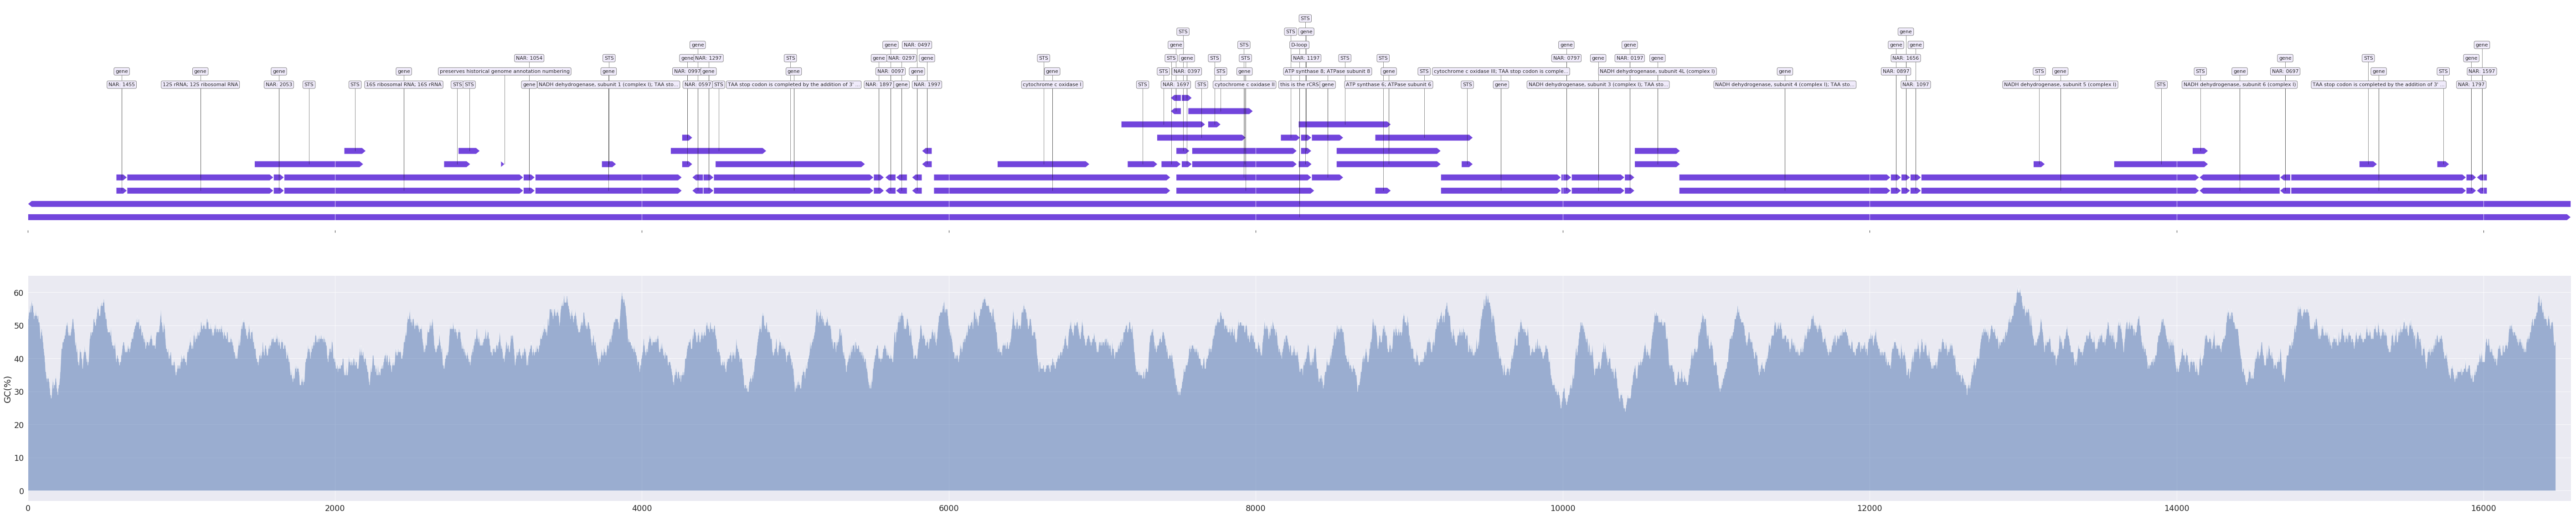

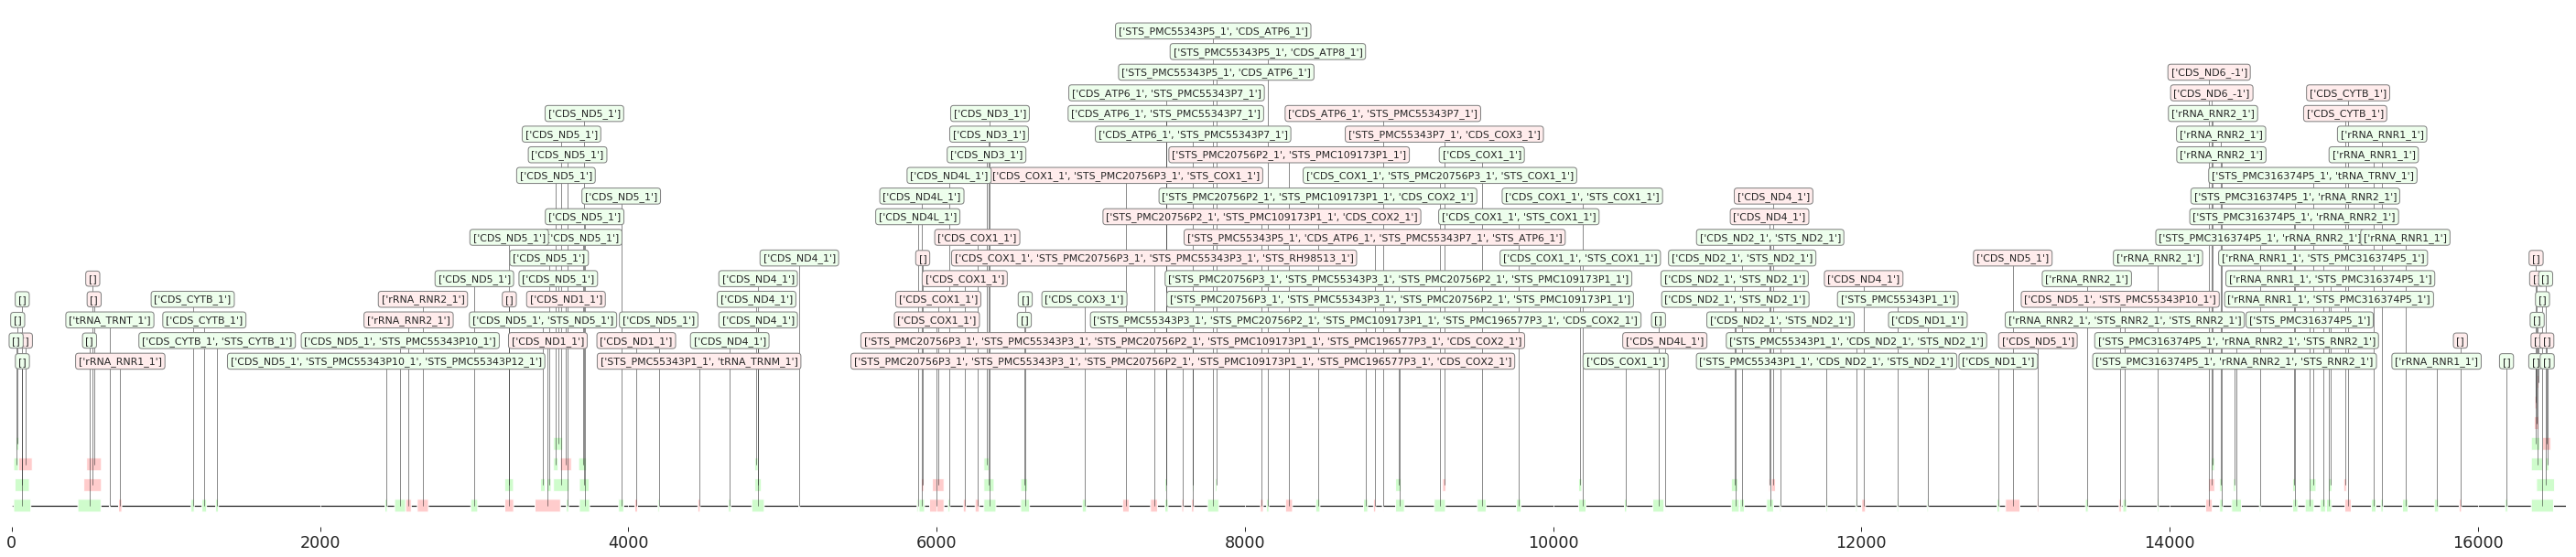

In [29]:
# Python 3.6 скрипт для поиска ORFs и выгрузки простейшей статистики.
# все расписано максимально подробно. То же можно закодить на полстраницы
# с помощью, например, специальных библиотек из biopython 
# http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc8 

# Можно подавать файлы с несколькими последовательностями и сохранять их в свои директории, 
# чтобы не путались. Также добавил ограничение на длину сверху и создал свой формат для записи.
# Формат таблицы: Nuc_seq	Amino_seq	SD_seq	SD_score	Srtand	Frame	Left_border	Right_border	Len	GC%	GC_fold_change	ScoreTr
# попробуем сделать все более правильно, так как митохондрии и бактерии имеют разные генетические коды
# сделал подтягивание разметки
# и поиск по бласту(почти всегда работает)
# есть отсечка по нуклеотидным последовательностям, но на больших данных долго считается
# добавил визуализацию


root = "/home/pavel/Desktop/ORF_SMTB/ORF_finder" # os.getcwd() # просто корень, где будем работать
os.chdir(root)
        
print("Start script") # задаем стартовые параметры
try:
    fasta_or_gb = "fasta" # str(input("Which format do you want to use? [fasta]/[gb]/[fasta+gb] "))
    file_fasta = root + "/sequence.fasta" # str(input("Type the name of fasta file "))
    file_gb = root + "/sequence.gb" # str(input("Type the name of gb file "))
except IOError:
    print ("Wrong file name!")

    
minimal_len_prot = 1 # int(input("Type the minimal protein length "))
maximal_len_prot = 100000 # int(input("Type the maximal protein length "))
minimal_len_prot_3 = minimal_len_prot * 3 # получили длину в нуклеотидах
maximal_len_prot_3 = maximal_len_prot * 3
hist = "y" # str(input("Do you want to see a prot histogram visualization? [y]/[n] "))
bin_size = 20 # int(input("Type the bin size for protein histogram "))
round_param = 4
table_code = "Vertebrate Mitochondrial"


code_calc = {"UUU": 0, "UUC": 0, "UUA": 0, "UUG": 0, # словарь для хранения встреченных кодонов
    "UCU": 0, "UCC": 0, "UCA": 0, "UCG": 0,
    "UAU": 0, "UAC": 0, "UAA": 0, "UAG": 0,
    "UGU": 0, "UGC": 0, "UGA": 0, "UGG": 0,
    "CUU": 0, "CUC": 0, "CUA": 0, "CUG": 0,
    "CCU": 0, "CCC": 0, "CCA": 0, "CCG": 0,
    "CAU": 0, "CAC": 0, "CAA": 0, "CAG": 0,
    "CGU": 0, "CGC": 0, "CGA": 0, "CGG": 0,
    "AUU": 0, "AUC": 0, "AUA": 0, "AUG": 0,
    "ACU": 0, "ACC": 0, "ACA": 0, "ACG": 0,
    "AAU": 0, "AAC": 0, "AAA": 0, "AAG": 0,
    "AGU": 0, "AGC": 0, "AGA": 0, "AGG": 0,
    "GUU": 0, "GUC": 0, "GUA": 0, "GUG": 0,
    "GCU": 0, "GCC": 0, "GCA": 0, "GCG": 0,
    "GAU": 0, "GAC": 0, "GAA": 0, "GAG": 0,
    "GGU": 0, "GGC": 0, "GGA": 0, "GGG": 0}

SD = ({'A':0.29,'T':0.47,'G':0.11,'C':0.13},
      {'A':0.42,'T':0.00,'G':0.15,'C':0.43},
      {'A':0.81,'T':0.11,'G':0.00,'C':0.08},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.00,'T':0.00,'G':1.0,'C':0.00},
      {'A':0.97,'T':0.00,'G':0.02,'C':0.01},
      {'A':0.23,'T':0.07,'G':0.66,'C':0.04},)

code = {"UUU": "F", "UUC": "F", "UUA": "L", "UUG": "L", # словарь для перекодирования
    "UCU": "S", "UCC": "S", "UCA": "S", "UCG": "S",
    "UAU": "Y", "UAC": "Y", "UAA": "STOP", "UAG": "STOP",
    "UGU": "C", "UGC": "C", "UGA": "STOP", "UGG": "W",
    "CUU": "L", "CUC": "L", "CUA": "L", "CUG": "L",
    "CCU": "P", "CCC": "P", "CCA": "P", "CCG": "P",
    "CAU": "H", "CAC": "H", "CAA": "Q", "CAG": "Q",
    "CGU": "R", "CGC": "R", "CGA": "R", "CGG": "R",
    "AUU": "I", "AUC": "I", "AUA": "I", "AUG": "M",
    "ACU": "T", "ACC": "T", "ACA": "T", "ACG": "T",
    "AAU": "N", "AAC": "N", "AAA": "K", "AAG": "K",
    "AGU": "S", "AGC": "S", "AGA": "R", "AGG": "R",
    "GUU": "V", "GUC": "V", "GUA": "V", "GUG": "V",
    "GCU": "A", "GCC": "A", "GCA": "A", "GCG": "A",
    "GAU": "D", "GAC": "D", "GAA": "E", "GAG": "E",
    "GGU": "G", "GGC": "G", "GGA": "G", "GGG": "G",
    "AAN": "!", "AUN": "!", "ACN": "!", "AGN": "!",
    "UAN": "!", "UAN": "!", "UAN": "!", "UAN": "!",
    "GAN": "!", "GAN": "!", "GAN": "!", "GAN": "!",
    "CAN": "!", "CAN": "!", "CAN": "!", "CAN": "!",
    "ANN": "!", "UNN": "!", "GNN": "!", "CNN": "!"}


def checkSD(SD_seq): 
    score = 0
    for n in range(len(SD_seq)-7):
        sub = SD_seq[n:n+7]
        subscore = 1
        for l in range(len(sub)):
            if sub[l] in SD[l]:
                subscore *= SD[l][sub[l]]
            else:
                subscore *= 0
        score = max(subscore, score)
    return score




def getGC(seq): #Calculate GC content
    total = 0
    GC = 0
    seqTot = seq.replace('N','')
    seqNoAT = re.sub('[ATN]', '', seq)
    total += len(seqTot)
    GC += len(seqNoAT)
    return round(GC/total, round_param)


def scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot): #Score self Trtable against global tr table (compare frequencies of each codon)
    score = 0
    for key in code_calc_prot.keys():
        if code[key] in amino_info_collector_prot:
            code_calc_prot[key] = code_calc_prot[key]/amino_info_collector_prot[code[key]]
        else:
            code_calc_prot[key] = 0

    for key in code_calc_prot.keys():
        score += (code_calc_prot[key] - code_calc_seq[key])**2 #Score is sum of the squares of the differences
    return round(score, round_param)
   
    
def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    local_file = open("blast_" + record_id + ".fasta", 'w')

    counter = 1
    for x in output:
        print(x)
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
        print("Progress is {:2.1%}".format(list(output.keys()).index(x)/len(list(output.keys())), end="\r"))
        
    local_file.close()
    print("Finished genbank processing.")
    
    

def orf_finder(sequence, frame): # модуль для поиска ORFs
    #stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    #start_codon = ['ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    stop_codons = ['TGA', 'TAG', 'TAA']  # стоп кодоны
    start_codon = ['ATA', 'ATG'] # старт кодоны (есть дополнительные старт кодоны - )
    
    start_positions = []
    stop_positions = []
    position_dict = {}
    orffound = {}
    #print(sequence)
    
    for i in range(frame, len(sequence), 3):  # рубим последовательнсть на тройки
        codon = sequence[i:(i + 3)].upper()
        #print(codon)
        if codon in start_codon:  # проверяем на вхождение в старт\стоп кодоны
            start_positions += str(i+1).splitlines()
        if codon in stop_codons:
            stop_positions += str(i+1).splitlines()
    
    if len(start_positions) >= 1 and len(stop_positions) >= 1:
        counter = 0
        for position_start in start_positions:  # делаем словарь ORFs
            for position_stop in stop_positions:
                delta = int(position_stop) - int(position_start)
                if minimal_len_prot_3 < delta and maximal_len_prot_3 > delta:
                    nameorf = "orf" + str(counter)
                    counter += 1
                    orffound[nameorf] = position_start, position_stop
                    break
                else:
                    pass
        print("Progress is {:2.1%}".format(start_positions.index(position_start)/len(start_positions), end="\r"))
    return orffound


def module_fasta_writer(out_file, line):  # модуль для записи в fasta формате 
    start_point = 0 # writes in fasta format by 60 nums in each line
    end_point = 60
    if len(line) > 60:
        len_line = len(line)
        while len_line > 0:
            j = line[start_point:end_point]
            len_line = len_line - 60
            out_file.write(j + "\n")
            start_point = start_point + 60
            end_point = end_point + 60
    else:
        out_file.write(line + "\n")


def codon_stat(line_in, frame=0):
    line_in = line_in.replace('T', 'U') # делаем из ДНК РНК ;)
    amino_info_collector = {}
    code_calc_tmp = code_calc.copy()
    #print(line_in)
    #print(code_calc_tmp)

    for i in range(frame, len(line_in), 3):
        #print(i)
        codon = line_in[i:(i + 3)]
        #print(codon)
        if codon in code_calc_tmp.keys(): # считаем кодоны
            code_calc_tmp[codon] = int(code_calc_tmp[codon]) + 1

        if codon in code.keys(): # считаем аминокислоты, но другим способом
            ama = code[codon]
            if ama in amino_info_collector.keys():
                amino_info_collector[ama] = int(amino_info_collector[ama]) + 1
            else:
                amino_info_collector[ama] = 1
    
    #print(code_calc_tmp, amino_info_collector)
    return code_calc_tmp, amino_info_collector


def nuc_stat_counter(sequence): # модуль для подсчета нуклеотидов
    nuc_collector = {}
    for i in range(len(sequence)):
        nuc = sequence[i]
        if nuc in nuc_collector.keys():
            nuc_collector[nuc] = int(nuc_collector[nuc]) + 1
        else:
            nuc_collector[nuc] = 1
    return nuc_collector


# bonus for many sequences ----------------------
start = clock()
record = SeqIO.read(file_gb, "genbank")
features_list = []
c = 0
for feature in record.features:
    if feature.type != "gene":
        if c == 2:
            #print(feature.qualifiers, str(feature.qualifiers).split("'"))
            #print(str(feature.qualifiers).split("'"))
            features_list.append([int(feature.location.start), int(feature.location.end), feature.strand, feature.type, str(feature.qualifiers).split("'")[3]])
        else:
            c +=1
#print(features_list)        



with open(file_fasta, "r") as in_file: # открываем файл с одной последовательностью и считываем по строчкам
    sequence = []
    name = ""
    read_lines = in_file.readlines()
    for i in range(len(read_lines)):
        if read_lines[i][0] != ">":
            sequence.append(read_lines[i].strip())
        else:
            name = read_lines[i]
    
sequence = "".join(sequence)  # собираем все строчки в последовательность
#print(sequence[:10])
name = record.id
print("Seq name is ", name)
   
basicdir = os.path.abspath('results_for_{name}/'.format(name=name)) # директория для общих файлов
    
if not os.path.exists(basicdir): # если нет basicdir, то создаем
    os.makedirs(basicdir)
os.chdir(basicdir) # заходим в неё
# теперь работаем и сохраняем только в ней
   
#complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}  # делаем reverse-complement последовательности
#sequence_rev = "".join(complement.get(base, base) for base in reversed(sequence))

# можно с помощью функции
#print(sequence)
sequence = Seq(sequence, generic_dna)
sequence_rev = str(sequence.reverse_complement())

sequence = str(sequence)

print("GC%", getGC(sequence))
print("")
    
orf_dict = {}
for i in range(3):  # перебираем каждую из рамок на прямой цепи
    print("Iteration", i)
    frame = i
    orfs = orf_finder(sequence, frame) # запускаем функцию поиска (последовательность, рамка)
    orf_dict[i] = orfs

for j in range(3): # и на обратной
    print("Iteration", -j)
    frame_rev = j
    orfs_rev = orf_finder(sequence_rev, frame_rev)
    orf_dict[j + 3] = orfs_rev

# получили словари с ORFs по рамкам
out_protein_orf_name = "out_protein_orf_" + str(name) + ".txt"
with open(out_protein_orf_name, "w") as out_file:
    out_file.write("Nuc_seq" + "\t" + "Amino_seq" + "\t" + "SD_seq" + "\t" + "SD_score" + "\t" + "Srtand" + "\t" + "Frame" + "\t" + "Left_border" + "\t" + "Right_border" + "\t" + "Ama_len" + "\t" + "GC%" + "\t" + "GC_fold_change" + "\t" + "ScoreTr" + "\t" + "Features" + "\n")
    for i in orf_dict.keys():  # for frame in dict --- для каждой из рамок
        print("Current frame is ",i)
        bin_len_list = []
        prot_calc = 0 # заводим счетчики для полипептидов          
            
        if int(i) <= 2:
            #print(sequence)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence, i)

        if int(i) > 2:
            #print(sequence_rev)
            code_calc_seq, amino_info_collector_seq = codon_stat(sequence_rev, i-3)

        for j in orf_dict[i]:  # for orf in frame --- для каждой ORF
            prot_calc += 1
            if int(i) <= 2 and len(orf_dict[i][j]) == 2: 
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
                bin_len_list = bin_len_list + [len(line)]
                SD_seq = sequence[left_border - 20:left_border]
                if len(SD_seq) == 20:
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = 0.0
                                
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))

                out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "+" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
            else:
                pass
             
            
            ###############################
            if int(i) > 2 and len(orf_dict[i][j]) == 2:
                left_border = int(orf_dict[i][j][0]) - 1
                right_border = int(orf_dict[i][j][1]) - 1
                        
                subseq = sequence_rev[left_border:right_border]
                line = str(Seq(subseq, generic_dna).translate(table=table_code, to_stop=True))   
   
                #print(line)
                bin_len_list = bin_len_list + [len(line)]
                SD_seq = sequence_rev[left_border - 20:left_border]
                #print(len(SD_seq))
                if len(SD_seq) == 20:
                    SD_score = checkSD(SD_seq)
                else:
                    SD_score = 0.0
                code_calc_prot, amino_info_collector_prot = codon_stat(subseq)
                scoreTr_result = scoreTr(code_calc_seq, amino_info_collector_seq, code_calc_prot, amino_info_collector_prot)    
                    
                features_for_orfs = []
                for e in features_list[1:]:
                    if left_border > e[0] and right_border < e[1]:
                        features_for_orfs.append(str(e[3]) + "_" + str(e[4]) + "_" + str(e[2]))
   
                left_border = len(sequence) - int(orf_dict[i][j][1]) - 1
                right_border = len(sequence) - int(orf_dict[i][j][0]) - 1
                out_file.write(subseq + "\t" + line + "\t" + SD_seq + "\t" + str(SD_score) + "\t" + "-" + "\t" + str(i) + "\t" + str(left_border) + "\t" + str(right_border) + "\t" + str(int((right_border - left_border)/3)) + "\t" + str(getGC(subseq)) + "\t" + str(getGC(subseq)/getGC(sequence_rev)) + "\t" + str(scoreTr_result) + "\t" + str(features_for_orfs) + "\n")
            else:
                pass
                 

        print("It has been found " + str(prot_calc) + " proteins")
        print("")
                
        try:
            print("Protein length by bins:")
            print("Bin size =", bin_size)
            l = numpy.array(bin_len_list)
            bins = numpy.arange(0, max(l), bin_size)
            print("Bin" + "\t" + "Score")
            for s in range(1,len(bins)):
                print(str(s) + "\t" + str(len(l[numpy.digitize(l, bins) == s])))
            print("")
    
            if hist == "y":
                fig = matplotlib.pyplot.gcf()
                fig.set_size_inches(16, 10)
                sns.set_context("paper", font_scale=2)
                
                plt.hist(l, bin_size, alpha = 0.8)
                plt.xlim([min(bin_len_list)- 5, max(bin_len_list) + 5])
                plt.title("Histogram of protein length for seq {name} in frame {frame}".format(name=name, frame=i))
                plt.xlabel('Length')
                plt.ylabel('Number of proteins')
                        
                plt.savefig('Histogram_of_protein_length_name_{name}_frame_{frame}.png'.format(name=name, frame=i), dpi=100)
                #plt.show()
                plt.gcf().clear()
            print("")
        except ValueError:
            continue

            

features = []
for i,j,k,q in zip(final_table["Left_border"], final_table["Right_border"], final_table["Srtand"], final_table["Features"]):
    #print(i,j,k,q)
    if k == "+":
        features.append(GraphicFeature(start=i, end=j, strand="+1", color='#ffcccc', label=q))
    if k == "-":
        #print(len(sequence))
        features.append(GraphicFeature(start=i, end=j, strand="-1", color='#cffccc', label=q))

#features


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 20), sharex=True)

# Parse the genbank file, plot annotations
record = SeqIO.read(root + "/sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=True)

# Plot the local GC content
def plot_local_gc_content(record, window_size, ax):
    gc_content = lambda s: 100.0*len([c for c in s if c in "GC"]) / len(s)
    yy = [gc_content(record.seq[i:i+window_size])
          for i in range(len(record.seq)-window_size)]
    #print(yy)
    xx = np.arange(len(record.seq)-window_size)
    #print(xx)
    ax.fill_between(xx, yy, alpha=0.5)
    ax.set_ylabel("GC(%)")

plot_local_gc_content(record, window_size=100, ax=ax2)

my_record = GraphicRecord(sequence_length=len(sequence), sequence=sequence, features = features)
ax, _ = my_record.plot(figure_width=50)


print("Done")  # the end

In [21]:
def blast_search(record_id, record):
    #Do blastn search and search results in xml file
    print("Starting QBlast search...")
    result_handle = NCBIWWW.qblast("blastn", "nt", record, hitlist_size=20, format_type="XML", genetic_code="Vertebrate Mitochondrial")
    blast_results = result_handle.read()
    save_file = open("blast_" + record_id + ".xml", "w")
    print("Writing QBlast search results...")
    save_file.write(blast_results)
    save_file.close()
    print("Finished QBlast.")

    #Open blast xml and load the blast record
    result_handle = open("blast_" + record_id + ".xml")
    blast_records = NCBIXML.parse(result_handle)
    blast_record = blast_records.__next__()

    #Store all accession ids
    output = {}
    for x in blast_record.alignments:
        output[x.accession] = [x.length]
    print("Total " + str(len(output)) + " records retrieved.")

    #Do entrez.efetch to retrieve all records in genbank file, store locally
    name = "blast_" + record_id + ".fasta"
    local_file = open(name, 'w')

    counter = 1
    for x in output:
        print(x)
        print("Downloading genbank records " + str(counter) + "...")
        try:
            handle = Entrez.efetch(db="nucleotide",id = x,rettype="fasta", )
            local_file.write(handle.read())
            handle.close()
        except:
            print("Accsession id is not found")
        counter = counter + 1
        print("Progress is {:2.1%}".format(list(output.keys()).index(x)/len(list(output.keys())), end="\r"))
        
    local_file.close()
    print("Finished genbank processing.")
    return name

names = []
for i, j in zip(final_table["index"][:3], final_table["Nuc_seq"][:3]):
    print(i,j)
    name = blast_search(str(i), j)
    names.append(name)
    p = subprocess.Popen("clustalw {file}".format(file=name), shell=True)
    p.wait()



1118 ATGGTTAGGTCTACGGAGGCTCCAGGGTGGGAGTAGTTCCCTGCTAAGGGAGGGTAGACTGTTCAACCTGTTCCTGCTCCGGCCTCCACTATAGCAGATGCGAGCAGGAGTAGGAGAGAGGGAGGTAAGAGTCAGAAGCTTATGTTGTTTATGCGGGGAAACGCCATATCGGGGGCACCGATTATTAGGGGAACTAGTCAGTTGCCAAAGCCTCCGATTATGATGGGTATTACTATGAAGAAGATTATTACAAATGCATGGGCTGTGACGATAACGTTG
Starting QBlast search...
Writing QBlast search results...
Finished QBlast.
Total 20 records retrieved.
MN150713
Progress is 0.0%
MN150712
Progress is 5.0%
MN053904
Progress is 10.0%
MN125706
Progress is 15.0%
MN163828
Progress is 20.0%
MN163832
Progress is 25.0%
MN125705
Progress is 30.0%
MN163282
Progress is 35.0%
MN125704
Progress is 40.0%
MN124446
Progress is 45.0%
MK069579
Progress is 50.0%
MK069578
Progress is 55.0%
MK069577
Progress is 60.0%
MK069576
Progress is 65.0%
MK069574
Progress is 70.0%
MK069572
Progress is 75.0%
MK069571
Progress is 80.0%
MK069569
Progress is 85.0%
MK069567
Progress is 90.0%
MK069565
Progress is 95.0%
Finished genbank processing.
1176 ATGTTGATAGTAGAATGATGGCTAGGGTGACTTCATATG

KeyboardInterrupt: 

In [22]:
tree = Phylo.read(names[0].split(".")[0] + ".dnd", 'newick')
#print(tree)
#tree.ladderize()
#Phylo.draw(tree)
Phylo.draw_ascii(tree)

  _______________________________________________________________ MN150713.1
 |
 | MN150712.1
 |
 , MN163832.1
 |
 | MN124446.1
 |
 , MN053904.1
 |
 | MK069579.1
 |
 |, MK069577.1
 ,|
 || MK069571.1
 |
 , MK069567.1
 |
 | MK069565.1
 |
_|, MK069576.1
 ||
 ||_ MK069569.1
 |
 | MN163828.1
 |
 , MK069578.1
 |
 |_ MK069574.1
 |
 | MK069572.1
 |
 , MN125706.1
 |
 | MN125705.1
 |
 , MN163282.1
 |
 | MN125704.1



In [23]:
#print(names[0].split(".")[0] + ".aln")

al = AlignIO.read("/home/pavel/Desktop/ORF_SMTB/ORF_finder/results_for_NC_012920.1/blast_217.aln", "clustal")
#al = AlignIO.read(names[0].split(".")[0] + ".aln", "clustal")

#print(al)
align = []
for i in range(len(al)):
    align.append( DNA(str("".join(al[i])), {'id': "s"+str(i)}) )

    
def compare_seqs(sub_seq1, sub_seq2):
    if sub_seq1 == sub_seq2:
        return True
    else:
        return False
    
sub_seq = list(final_table["Nuc_seq"])[0]
#print(sub_seq)
seq = align[0]
for i in range(len(align)):
    for j in range(len(align[0])):
        #print(seq[i: i + len(sub_seq)])
        if compare_seqs(sub_seq, seq[j: j + len(sub_seq)]):
            print(j, "OK")
        else:
            continue

In [24]:
sub_seq

'ATGGTTAGGTCTACGGAGGCTCCAGGGTGGGAGTAGTTCCCTGCTAAGGGAGGGTAGACTGTTCAACCTGTTCCTGCTCCGGCCTCCACTATAGCAGATGCGAGCAGGAGTAGGAGAGAGGGAGGTAAGAGTCAGAAGCTTATGTTGTTTATGCGGGGAAACGCCATATCGGGGGCACCGATTATTAGGGGAACTAGTCAGTTGCCAAAGCCTCCGATTATGATGGGTATTACTATGAAGAAGATTATTACAAATGCATGGGCTGTGACGATAACGTTG'